## Packages installation

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

## Import packages

In [ ]:
import numpy
import numpy as np
from PIL import Image, ImageDraw
import os
import glob
from tqdm import tqdm
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss, JaccardLoss
from torch.utils.data import Dataset, DataLoader
#from torcheval.metrics.functional import multiclass_f1_score, multiclass_accuracy, multiclass_precision, multiclass_recall

import cv2
import albumentations as A
from albumentations import Compose, Resize
from albumentations.pytorch.transforms import ToTensorV2

from skimage.measure import label, regionprops, find_contours
import skimage
from skimage.util.shape import view_as_blocks
from skimage import io
from skimage.transform import resize

from pathlib import Path
import yaml

## Model configuration

### docs

In [ ]:
"""
Docs

model.eval() is equivalent to model.train(False): only affects some modules like Dropout, batchnorm, etc.
model.extra_repr() : extra representation of the module. Can reimplement it to customise its behaviour
model.get_submodule(target) -> get a submodule of a module
  e.g : model_fruits.get_submodule("model.encoder")

Module.state_dict() -> Python dictionary that maps the modules' to the tensors parameters
  E.G :
      for param_tensor in model.state_dict():
          print(param_tensor, "\t", model.state_dict()[param_tensor].size())

model.load_state_dict(state_dict, strict=True, assign=False) -> Load the state of the model from a dict saved

Module.named_children() -> iterateur sur tous les sous module nommé (name, SubModule), (name, SubModule), etc.
  model_fruits.get_submodule("model.encoder.blocks").named_children()

Module.named_modules(memo=None, prefix='', remove_duplicate=True) -> for all the network
Module.parameters(recurse=True) -> all the parameters of the module, it is used for optimisation



Saving & Loading Model for Inference
-> ============================= Save/Load state_dict (Recommended) ================
  model = TheModelClass(*args, **kwargs)
  to save :
    torch.save(model.state_dict(), PATH)
  to load:
    model = TheModelClass(*args, **kwargs)
    model.load_state_dict(torch.load(PATH))
    model.eval()

    When saving a model for inference, it is only necessary to save the trained model’s learned parameters.
    Saving the model’s state_dict with the torch.save() function will give you the most flexibility for restoring
    the model later, which is why it is the recommended method for saving models.

    A common PyTorch convention is to save models using either a .pt or .pth file extension.

    Remember that you must call model.eval() to set dropout and batch normalization layers to evaluation
    mode before running inference. Failing to do this will yield inconsistent inference results.

    If you only plan to keep the best performing model (according to the acquired validation loss),
    don’t forget that best_model_state = model.state_dict() returns a reference to the state and not
    its copy! You must serialize best_model_state or use best_model_state = deepcopy(model.state_dict())
    otherwise your best best_model_state will keep getting updated by the subsequent training iterations.
    As a result, the final model state will be the state of the overfitted model.

================================== Save/Load Entire Model =====================================================
Save:
  torch.save(model, PATH)
Load:
  # Model class must be defined somewhere
  model = torch.load(PATH)
  model.eval()

============== Saving & Loading a General Checkpoint for Inference and/or Resuming Training ====================
SAVE :
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            ...
            }, PATH)
            file extension recommended is .tar

LOAD :
  model = TheModelClass(*args, **kwargs)
  optimizer = TheOptimizerClass(*args, **kwargs)

  checkpoint = torch.load(PATH) -> Load the saved checkpoint
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']

  model.eval()
  # - or -
  model.train()

# ======================== Saving and loading across devices =================
device = torch.device("cuda") # or cpu, etc.
model.load_state_dict(torch.load(PATH, map_location=device))
If the model was saved using cuda device and want to load it using cpu device, we
need to specify the map_location. Then call model.to(device) to convert tensors to
the specific device tensors types"""

### code

In [ ]:

from typing import Callable, Union, List, Optional, Tuple

# ================== Custom exceptions : put it in a exceptions.py or errors.py ===============================
class InvalidFileError(Exception):
  """
  This exception is raised if the given file is not among the recognized files extensions like .jpg, .yml, etc

  message: explanation message
  """
  def __init__(self, message):
    self.message = message

    super().__init__(self.message)


class InvalidShapeError(Exception):
  """
  This exception is raised if the given image doesn't match the expected shape

  message: explanation message
  """
  def __init__(self, message):
    self.message = message

    super().__init__(self.message)


class InvalidTypeError(Exception):
  """
  This exception is raised if the type received is not what is expected

  message: explanation message
  """
  def __init__(self, message):
    self.message = message

    super().__init__(self.message)


# ================= Utils files ==========
ALLOWED_IMAGES_EXTENSIONS = [".jpg", ".jpeg"]
def check_yaml(model_architecture="unet", config_file=None):
  """
  Check if the config file is valid for the given architecture.
  We must open the file using the yaml library then check the configuration
  it must contain some attributes.
  """

  def _check_unet_cfg(config_file):
    """Checking for unet"""
    return True

  if model_architecture == "unet":
    return _check_unet_cfg(config_file)


def get_unet_config(path):
  """

  """
  if check_yaml(model_architecture="unet", config_file=path):
    with open(path, "r") as f:
      config = yaml.safe_load(f)
      model_name = config['architecture_config']['model_name']
      encoder = config['architecture_config']['encoder_name']
      encoder_depth = config['architecture_config']['encoder_depth']
      encoder_weights = config['architecture_config']['encoder_weights']
      decoder_use_batchnorm = config['architecture_config']['decoder_use_batchnorm']
      decoder_attention_type = config['architecture_config']['decoder_attention_type']
      decoder_channels = config['architecture_config']['decoder_channels']
      in_channels = config['architecture_config']['in_channels']
      n_classes = config['architecture_config']['classes']
      activation = config['architecture_config']['activation']
      cpkt_path = config['architecture_config']['checkpoint_path']

      return {
          "model_name": model_name,
          "encoder_name": encoder,
          "encoder_depth": encoder_depth,
          "decoder_use_batchnorm": decoder_use_batchnorm,
          "decoder_channels": tuple(decoder_channels),
          "decoder_attention_type": decoder_attention_type,
          "in_channels": in_channels,
          "classes": n_classes,
          "activation": activation,
          "cpkt_path": cpkt_path
      }


def build_model_from_dict_config(config=None, architecture="unet"):
  """Build a unet model from the configuration
  args:
    config: a dictionary containing the keywords along with their values to build
    the model from
    architecture: one of the base architecture available in segmentation-models-pytorch
      "unet", "fpn", "pspnet", etc.
  """
  if architecture == "unet":
    return smp.Unet(**config)
  else:
    raise NotImplementedError("Can only build a model for unet. please implement for others")

def get_device():

    DEVICE = 'cpu'
    #
    if torch.cuda.is_available():
        DEVICE = "cuda"

    return DEVICE


def correct_config_dict_for_model(arch="unet", config_dict=None):
  if arch == "unet":
    correct_attributes_unet = ["encoder_name", "encoder_depth", "encoder_weights", \
                              "decoder_use_batchnorm", "decoder_channels", \
                              "decoder_attention_type", "in_channels", "classes", "activation"]
    correct_config = {key: config_dict[key] for key in config_dict if key in correct_attributes_unet}

    correct_config_ = {}
    for key in correct_config:
      if key in ("activation", "decoder_attention_type") and correct_config[key] in ("None", "none"):
        correct_config_[key] = None
      else:
        correct_config_[key] = correct_config[key]

    return correct_config_


def preprocess_input_for_prediction(image: Union[str, np.ndarray, torch.Tensor],
                                    add_batch_dimension: bool = True,
                                    width: int = 640, height: int = 640,
                                    channel_first: bool = False,
                                    normalize: bool = True,
                                    transforms_callback: Callable[..., torch.Tensor] = None) -> torch.Tensor:
    """
    preprocesses an input image to make it ready for prediction

    parameters :
        image : a path to the file or a np.ndarray or a torch.Tensor
        add_batch_dimension :
        width : the output x_size
        height : the output y_size
        channel_first : if the input image is an image or a numpy ndarray, it specifies whether the channel dimension
            is first (channels, rows, cols) or last (rows, cols, channels). Default to False means (rows, cols, channels)
        normalize: whether to normalize the input image or not. Will be normalize by 255. Default to True
        transforms_callback: a  callable that can accept a numpy array and return a torch.Tensor
            with parameters <image_array, x_size, y_size, add_batch_dimension> in this order

    return torch.Tensor

    """
    if isinstance(image, str):
        if Path(image).exists():
            if Path(image).suffix in ALLOWED_IMAGES_EXTENSIONS:
                path = str(Path(image)).replace("\\", "/")
                image_array = io.imread(path, as_gray=False)
            else:
                raise InvalidFileError(f"{image} is not a valid format. \
                                             Accepted formats are {ALLOWED_IMAGES_EXTENSIONS}")
        else:
            raise FileNotFoundError(f"Cannot find the file {image}. Please provide the right path to the image.")
    elif isinstance(image, np.ndarray):
        image_array = image
    else: # It is a tensor
        image_array = image.numpy(force=True)

    # Check the dimensions of the image : number of dimensions then number of channels
    if len(image_array.shape) == 3:
        # Check if the number of channels is 3
        if channel_first:
          if image_array.shape[0] != 3:
            raise InvalidShapeError(f"The image is expected to have 3 channels, found {image_array.shape[0]}")
          else:
            image_array = image_array.transpose((1, 2, 0))
        elif not channel_first:
            if image_array.shape[-1] != 3:
                raise InvalidShapeError(f"The image is expected to have 3 channels, found {image_array.shape[-1]}")
    else:
        raise InvalidShapeError(f"Your image has len(image_array.shape) dimensions. The expected number of dimensions \
                                    is 3")

    if normalize:
        image_array = image_array / 255.0

    # If a callback is provided, it will be returned, else, the image will be resized
    if transforms_callback is not None:
        return transforms_callback(image_array, width, height, add_batch_dimension)
    else:
        image_tensor = Compose([
            Resize(height, width),
            ToTensorV2() # Transfor from HWC to CHW
        ])(image=image_array)["image"]

    # Add a batch dimension to the image_tensor (channels, rows, cols) -> (1, channels, rows, cols)
    if add_batch_dimension:
        image_tensor = torch.unsqueeze(image_tensor, dim=0)

    return image_tensor.type(torch.float)


def check_dict_keys_for_train(dict_, keys):
  """
  Check if the dict contains the keys
  """
  for key in keys:
    if key not in dict_:
      raise KeyError(f"{key} is not in the dict")
    else:
      if not isinstance(dict_[key], str):
        raise TypeError(f"{dict_[key]} must be a path to the data")
      if not Path(dict_[key]).exists():
        raise FileNotFoundError(f"{dict_[key]} is not found! please check your path!")



### Model

In [ ]:
class SegmentationModel(nn.Module):
  """Class de base pour la segmentation d'images"""
  """
  args:
    model :
      - yaml config file containing the models configuration
      - pretrained_model : .pt file
    type :
      - pretrained
      - config_file
  """
  def __init__(self, model: str = None, model_name="unet"):
    super().__init__()
    self.model_config = model
    self.model_name = model_name
    self.model = None
    self.model_building_config = None
    self.trainer = None

    # Build the model form the configuration
    self._build_model()
    self.to(get_device())

  def __call__(self, x):
    """
    Effectuer une prédiction
    """
    return self.model(x)


  def forward(self, x):
    """
    Effectuer une prédiction
    """
    return self.model(x)

  def fit(self, donnees_dict: dict=None, augmentations: A.Compose = None, batch_size=8, image_size=640, save_dir=None, epochs=100, train_checkpoint=None):
    """Train the model
    donnees_dict : the data to use for training :
      - train_images: images and masks for training
      - train_masks: masks for training
      - val_images: images and masks for validation
      - val_masks: masks for validation
    batch_size : the batch size to use for training
    image_size : the image size to use for training
    save_dir : the directory to save the model
    """
    # vérifier la validité des paramètres
    if not isinstance(epochs, int):
      raise TypeError("epochs must be an integer")
    if not isinstance(donnees_dict, dict):
      raise TypeError("data must be a dictionary")
    else:
      check_dict_keys_for_train(dict_=donnees_dict, keys=["train_images", "train_masks", "val_images", "val_masks"])
    """if augmentations is not None:
      if not isinstance(augmentations, A.Compose):
        raise TypeError("augmentations must be an instance of A.Compose")"""
    if not isinstance(batch_size, int):
      raise TypeError("batch_size must be an integer")
    if not isinstance(image_size, int):
      raise TypeError("image_size must be an integer")

    if save_dir is not None and not isinstance(save_dir, str):
      raise TypeError("save_dir must be a string")

    if not Path(save_dir).parent.exists():
      raise FileNotFoundError(f"{save_dir} not found! Check the directory!")
    else:
      Path(save_dir).mkdir(exist_ok=True)

    if save_dir is None:
      save_dir = str(Path().cwd() / "runs")
      Path(save_dir).mkdir(exist_ok=True)

    # --------------- Get train and val data configs --------------------
    n_classes = self.model_building_config["classes"]
    if n_classes == 1:
      classes_pixels_values = [0, 255]
      classes_names = ["background", "Cadre"]
      labels_mapping = {0: 0, 255: 1}
    elif n_classes == 3:
      classes_pixels_values = [0, 128, 255]
      classes_names = ["background", "fruit", "edge"]
      labels_mapping = {0: 0, 128: 1, 255: 2}
    else:
      raise ValueError("Only 1 or 3 classes are supported!")

    train_data_dict = {"images": donnees_dict["train_images"], "labels_masks": donnees_dict["train_masks"]}
    val_data_dict = {"images": donnees_dict["val_images"], "labels_masks": donnees_dict["val_masks"]}

    train_data_cfg = DatasetConfig(batch_size, image_size, augmentations, n_classes,
                                   classes_pixels_values, classes_names, labels_mapping,
                                   data_config=train_data_dict)
    val_data_cfg = DatasetConfig(batch_size, image_size, None, n_classes,
                                 classes_pixels_values, classes_names, labels_mapping,
                                 data_config=val_data_dict)
    # ----------------- Send the task to to trainer --------------- data, model, epochs, save_dir
    self.trainer = Trainer(model=self, _data={"train": train_data_cfg, "val": val_data_cfg}, epochs=epochs, save_dir=save_dir)
    self.trainer.train(train_checkpoint)

  def predict(self, image: Union[str, np.ndarray] = None, tilling: bool = False, tile_size: int = 360, prediction_size: int = 640, device="cpu"):
    """
    Effectuer une prédiction en utilisant le modèle pré-entrainé.
    image : chemin vers l'image à utilisé ou une image numpy
    tilling : spécifie si on doit faire une prédiction en tuillage. Si True, on doit spécifier n_rows et n_cols
    tile_size: nombre de lignes et colonnes de la tuile. tuile de 2 * 2 découpe l'image en 4 blocks
    prediction_size: taille à laquelle l'image doit être redimensionnée lors pour la prédiction
    """
    if isinstance(image, str):
      if Path(image).exists():
        image_array = io.imread(image)
      else:
        raise FileNotFoundError(f"{image} was not found! please check the good path of your file")
    elif isinstance(image, np.ndarray):
      image_array = image
    else:
      raise TypeError("image must be a string or a numpy array")

    # Check for tile, tile_size, prediction_size and save_path
    if isinstance(tilling, bool):
      if tilling:
        if not isinstance(tile_size, int):
          raise TypeError("tile_size must be an integer")
        if self.model_building_config["classes"] != 3:
          raise ValueError("Only 3 classes are supported for tuiling!")
    else:
      raise TypeError("tilling must be a boolean")

    if not isinstance(prediction_size, int):
          raise TypeError("prediction_size must be an integer")

    # Check the dimensions of the image : HWC with C=3
    if len(image_array.shape) != 3:
      raise InvalidShapeError(f"The image is expected to have 3 channels, found {image_array.shape[-1]}")
    elif image_array.shape[-1] != 3:
      raise InvalidShapeError(f"The image is expected to have 3 channels, found {image_array.shape[-1]}")

    # Put the model on eval mode
    self.eval()
    original_shape = image_array.shape
    prediction_size = find_closest_dividor(initial_number=prediction_size, divisor=32)
    if tilling:
      # Tile the image :
      tiling_results = tile_image(image=image_array, tile_height=tile_size, tile_width=tile_size)
      tiles, n_rows, n_columns, block_shape = tiling_results.values()
      tile_predictions = []
      for r in range(n_rows):
        for c in range(n_columns):
          tile = tiles[r, c].reshape(block_shape)
          # Preprocess the tile for prédiction
          tile_tensor = preprocess_input_for_prediction(image=tile, width=prediction_size, height=prediction_size, normalize=True)
          with torch.no_grad():
            # Predict the mask
            tile_tensor = tile_tensor.to(device)
            tile_mask = self.model(tile_tensor)
            tile_mask = torch.squeeze(tile_mask, dim=0)
            tile_mask = torch.softmax(tile_mask, dim=0)
            tile_mask = torch.argmax(tile_mask, dim=0)
            tile_mask = torch.squeeze(tile_mask, dim=0).cpu().numpy()
            # Resize the tile back to its original size
            tile_mask = resize(tile_mask, (block_shape[0], block_shape[1]), preserve_range=True).astype(np.uint8)
            # Add the prediction to the list of predictions
            tile_predictions.append(tile_mask)
      # Concat tiles predictions
      prediction = concat_tiles(tile_predictions, n_rows, n_columns)
      return prediction
    else:
    # Preprocess the image
      image_tensor = preprocess_input_for_prediction(image=image_array, width=prediction_size, height=prediction_size, normalize=True)
      with torch.no_grad():
        # Predict the mask
        image_tensor = image_tensor.to(device)
        mask = self.model(image_tensor)
      # Delete the batch dimension
      mask = torch.squeeze(mask, dim=0)
      # Apply an activation function
      if self.model_building_config["classes"] == 1:
        mask = torch.sigmoid(mask)
        mask = torch.round(mask)
      else:
        mask = torch.softmax(mask, dim=0)
        mask = torch.argmax(mask, dim=0)

      # Convert the mask to a numpy array
      mask = torch.squeeze(mask, dim=0).cpu().numpy()
      mask = resize(mask, (original_shape[0], original_shape[1]), preserve_range=True).astype(np.uint8)
      # Convert the mask to a numpy array
      return mask

  def _build_model(self):
    """Build the model from a configuration file or from pretrained weights"""
    if Path(self.model_config).exists():
      if Path(self.model_config).suffix in (".yaml", ".yml"):
        return self._build_model_from_yaml()
      elif Path(self.model_config).suffix in (".pt", ".tar"):
        self._build_pretrained_model(device="cpu")
      else:
        raise InvalidFileError(f"{self.model} is not a recognized file.\n Accepted formats are .yml/.yaml/.pt/.tar")
    else:
      raise FileNotFoundError(f"{self.model} was not found! please check the good path of your file")

  def _build_model_from_yaml(self):
    """
    Build the model from yaml configuration file

    if the .yaml/.yml config file is valid, the model will be built
    else:
      raise InvalidConfigFileError("The file self.model_config is not valid")
    """
    if self.model_name == "unet":
      model_config_path = str(Path(self.model_config)).replace("\\", "/")
      if check_yaml(model_architecture="unet", config_file=model_config_path):
        config = get_unet_config(model_config_path)
        self.model_building_config = correct_config_dict_for_model(arch="unet", config_dict=config)
        self.model = build_model_from_dict_config(config=self.model_building_config, architecture="unet")

        # Add a key to specify the models name :
        self.model_building_config["model_name"] = "unet"

        if Path(config["cpkt_path"]).exists():
          self._restore_model_weights(config["cpkt_path"], device=get_device())

  def _restore_model_weights(self, weights, device):
    """Restore a model from weights

     weights : path to the weights file or a dict containing the model weights
    """
    try:
      if isinstance(weights, dict):
        self.load_state_dict(weights)
      else:
        self.load_state_dict(torch.load(weights, map_location=torch.device(device)))
    except:
      raise RuntimeWarning("Failed to load the model weights. Please make sure that the weights file is valid.")

  def _build_pretrained_model(self, device=get_device()):
    """
    Build the model from pretrained weights

    If the model config ends with .pt or .tar, the model will be built

    This file should contain these keys :
      "building_config" : the model configuration. A dict containing the keys
                    "model_name" along with the model architecture keys
      "model_state_dict" : the model weights

    """
    loaded_config = torch.load(self.model_config, map_location=device)
    self.model_building_config = loaded_config["building_config"]
    model_name = self.model_building_config["model_name"]
    arch_config = {
       key:self.model_building_config[key] for key in self.model_building_config
        if key != "model_name"
    }
    if model_name == "unet":
      self.model = build_model_from_dict_config(config=arch_config, architecture="unet")
      model_weights = loaded_config["model_state_dict"]
      # Load the model state
      self._restore_model_weights(model_weights, device)
      # self.load_state_dict(model_weights)
    elif model_name == "fpn":
      self.model = build_model_from_dict_config(config=arch_config, architecture="fpn")
    elif model_name == "unet++":
      self.model = build_model_from_dict_config(config=arch_config, architecture="unet++")

  def __repr__(self):
    return super().__repr__()

  def save(self, path, kwargs=None):
    """Save the model to a file
    This will save informations relative to the model' architecture along with the weights

    Allowed extensions are .pt or .tar

    """
    if kwargs is None:
      kwargs = {}
    if Path(path).suffix in (".pt", ".tar"):
      torch.save({
          "building_config": self.model_building_config,
          "model_state_dict":  self.state_dict(),
          **kwargs
        }, path)

In [ ]:
a = torch.load("ModelsTraining/Train_Unet_Fruits_AugsResize960/weights/last.pt", map_location=get_device())
a.keys()

dict_keys(['building_config', 'model_state_dict'])

In [ ]:
# -- model fruits ----
model_fruits = SegmentationModel("ModelsTraining/Train_Unet_Fruits_AugsResize960/weights/last.pt")

In [ ]:
from skimage import morphology


def visPred(img, mask, pred):
    fig, axes = plt.subplots(1, 4, figsize=(30, 10))

    axes[0].imshow(img)
    axes[0].axis("off")
    axes[0].set_title("image")

    axes[1].imshow(mask, cmap="gray")
    axes[1].axis("off")
    axes[1].set_title("Mask")

    axes[2].imshow(pred, cmap="gray")
    axes[2].axis("off")
    axes[2].set_title("prediction")

    axes[3].imshow(np.multiply(mask, pred), cmap="gray")
    axes[3].axis("off")
    axes[3].set_title("prediction")

def post_process_fruits_mask(mask, border_to=0):
    # assign border to background
    new_mask = np.copy(mask)
    new_mask[mask==2] = border_to
    new_mask *= 255
    return new_mask

def erode_mask(mask, kernel_size, n_iters=1):
    return cv2.erode(mask, kernel=np.ones((kernel_size, kernel_size)), iterations=n_iters)

def dilate_mask(mask, kernel_size, n_iters=1):
    return cv2.dilate(mask, kernel=np.ones((kernel_size, kernel_size)), iterations=n_iters)

def remove_small_holes(mask, threshold):
    return morphology.remove_small_holes(ar=mask, connectivity=2, area_threshold=threshold)

def remove_small_objects(mask, threshold):
    return morphology.remove_small_objects(ar=mask, connectivity=2, min_size=threshold)


def get_numberFruits(mask):
    return len(find_contours(mask))

# def find_fruits_by_region_props(mask, min_area=50):


In [ ]:
# dataframe des fruits
import pandas as pd
df = pd.read_csv("atf-1/valid/nombre_reel_fruits.csv")[["image", "true_number"]]
df.set_index("image", inplace=True)

In [ ]:
# ------------------- Prédiction du cadre -------------------------------------------------------
images_val = glob.glob("D:/MFE_Cheik_Parfait/Process/atf-1/valid/images/*.jpg")
vrai_masks = glob.glob("atf-1/valid/masks_cadre_validation/*.png")
model_cadre =  SegmentationModel("ModelsTraining/Train_FrameDetectionFinalAugs/weights/last.pt")


### prédiction

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from skimage.color import label2rgb

In [ ]:

def get_polygons(path_to_label_file: str, image_path: str):
        """
          Permet de récupérer les polygones présents dans un fichier donnée:
          return:
            polygones: [[(x, y), (x, y), (x, y)], ...]
        """
        if os.path.exists(path_to_label_file):
            with open(path_to_label_file) as file:
                content = file.readlines()
                if len(content) > 0:
                    polygones = []
                    imArray = np.asarray(Image.open(image_path).convert("RGBA"))
                    width, height = imArray.shape[1], imArray.shape[0]
                    for e in content:
                        pol = [float(i) for i in e.split(" ")[1:]]
                        pol = [(int(pol[j] * width), int(pol[j + 1] * height)) for j in range(0, len(pol), 2)]
                        polygones.append(pol)

                    return polygones

def polygon_to_bbox(polygon):
    x_values = [e[0] for e in polygon]
    y_values = [e[1] for e in polygon]

    x_min, x_max = min(x_values), max(x_values)
    y_min, y_max = min(y_values), max(y_values)

    return x_min, x_max, y_min, y_max

def bbox_to_point(bbox):
    """
    bbox:
        x_min, x_max, y_min, y_max

    """
    x = int((bbox[1] + bbox[0]) / 2)
    y = int((bbox[-1] + bbox[-2]) / 2)
    return x, y

def polygons_to_points(polygons):
    """
    polygons:
        [
            [(x, y), (x, y), ...],
            .....................,
            [(x, y), (x, y), ...]
        ]
    """
    points = []
    for polygon in polygons:
        bbox = polygon_to_bbox(polygon)
        point = bbox_to_point(bbox)
        points.append(point[0])
        points.append(point[1])

    return points

def get_label_points(path_to_label_file, image_path):
    """
    Convertir les coordonnées des fruits annotées en points
    """
    polygons = get_polygons(path_to_label_file, image_path)
    points = polygons_to_points(polygons)
    return points


def label_and_vis_pred_on_image(img_path, pred_mask, min_area):
    image = io.imread(img_path)
    # label image regions
    label_image = label(pred_mask)
    # to make the background transparent, pass the value of `bg_label`,
    # and leave `bg_color` as `None` and `kind` as `overlay`
    image_label_overlay = label2rgb(label=label_image, image=image, bg_label=0, saturation=1, alpha=0.6, image_alpha=1.0)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(image_label_overlay)

    for region in regionprops(label_image):
        # take regions with large enough areas
        if region.area >= min_area:
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle(
                (minc, minr),
                maxc - minc,
                maxr - minr,
                fill=False,
                edgecolor='red',
                linewidth=1,
                alpha=.8
            )
            ax.add_patch(rect)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

def get_bboxes(pred_mask, min_area):
    """
        bbox : [y_min, x_min, y_max, x_max]
    """
    label_image = label(pred_mask)
    bboxes = []
    for region in regionprops(label_image):
        # take regions with large enough areas
        if region.area >= min_area:
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            bboxes.append([minr, minc, maxr, maxc])

    return bboxes

def bboxe_to_point(bbox):
    y = int((bbox[0] + bbox[2]) / 2)
    x = int((bbox[1] + bbox[3]) / 2)
    return x, y

def bboxes_to_points(bboxes, tuple_of_points=True):
    points = []
    for bbox in bboxes:
        x, y = bboxe_to_point(bbox)
        if tuple_of_points:
            points.append((x, y))
        else:
            points.append(x)
            points.append(y)
    return points

def poins_to_mask(width, height, points):

    # Création du masque:
    # mode=L (8-bit pixels, grayscale)
    maskImage = Image.new(mode='L', size=(width, height), color="black")
    ImageDraw.Draw(maskImage).point(points, fill="white")
    return np.asarray(maskImage)

def get_number(mask_cadre, mask_fruits):
    """
        multiply the two masks then find the contours
    """
    return len(find_contours(np.multiply(mask_cadre, mask_fruits)))



In [ ]:
# -- model fruits ----
model_fruits = SegmentationModel("ModelsTraining/Train_No_tilling_Unet_fruits/weights/last.pt")


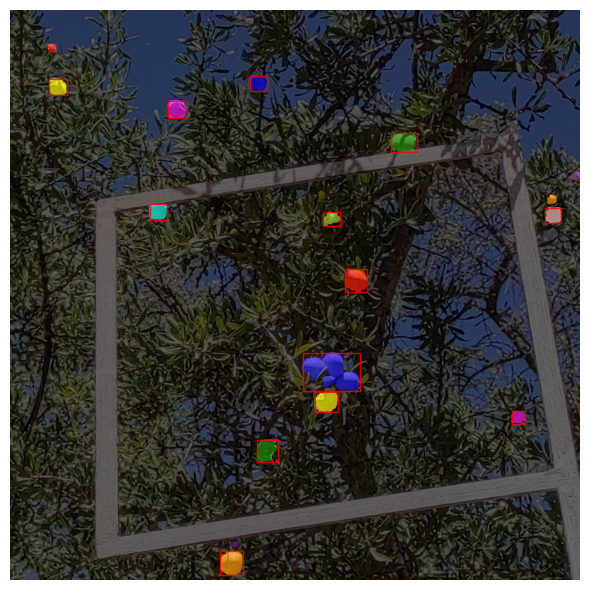

In [ ]:
img_path = "atf-1/train/images/BOU_10_CadreFruitEst_ArbreEch_1_V1_2022-04-02_jpg.rf.17dc80ae92da5176264e38f3eafdf330.jpg"
result = model_fruits.predict(image=img_path, tilling = True, tile_size = 960, prediction_size = 960)
result = post_process_fruits_mask(mask=result, border_to=0)
result = erode_mask(mask=result, kernel_size=5, n_iters=1)
result = dilate_mask(mask=result, kernel_size=5, n_iters=2)
label_and_vis_pred_on_image(img_path=img_path, pred_mask=result, min_area=400)

In [ ]:
paths_true_masks = sorted(glob.glob("atf-1/valid/masks_cadre_validation/*.png"))
paths_pred_masks = sorted(glob.glob("D:/MFE_Cheik_Parfait/Process/atf-1/valid/masks_cadre_predit/*.png"))
labels_paths = sorted(glob.glob("atf-1/valid/labels/*.txt"))
paths_val_images = sorted(glob.glob("atf-1/valid/images/*.jpg"))

tile_sizes = [480, 640, 960]
pred_sizes = [640, 960, 1080]
min_areas = [0, 25, 50]


list_models = [
    "ModelsTraining/TrainUnetFruitsSCSEAttention/weights/last.pt"
]

list_paths_to_save = [
    "ModelsTraining/TrainUnetFruitsSCSEAttention/"
]

In [ ]:


for model_path, save_path in zip(list_models, list_paths_to_save):
    print(f" ================== Model : {model_path} ===========================")
    model_fruits = SegmentationModel(model_path)
    f_csv = save_path + "prediction_final_k_3_tilling_multiparams.csv"

    with open(f_csv, "w+") as f:
        f.write("image,tile_size,pred_size,min_area,n_predit,n_reel\n")
        loop = tqdm(zip(paths_val_images, paths_true_masks, paths_pred_masks, labels_paths), total=len(paths_true_masks), desc=f"Saving results to {f_csv}...")
        for img_path, true_mask_path, pred_mask_path, label_path in loop:
            img_path = img_path.replace("\\", "/")
            true_mask_path = true_mask_path.replace("\\", "/")
            pred_mask_path = pred_mask_path.replace("\\", "/")
            label_path = label_path.replace("\\", "/")
            img_name = img_path.split("/")[-1]

            true_mask = io.imread(true_mask_path)
            pred_mask = io.imread(pred_mask_path)

            # -------------------------- get true number of fruits ----------------------------------
            points_labels = get_label_points(label_path, img_path)
            mask_true_fruits = poins_to_mask(true_mask.shape[1], true_mask.shape[0], points_labels)
            n_reel_fruits = get_number(true_mask, mask_true_fruits)



            for tile_size in tile_sizes:
                for pred_size in pred_sizes:
                    # ---------------------------------------- Predict and Postprocess -----------------------------------------------
                    result = model_fruits.predict(image=img_path, tilling = False, prediction_size = pred_size) # , tile_size = tile_size, prediction_size = tile_size
                    result = post_process_fruits_mask(mask=result)
                    result = erode_mask(mask=result, kernel_size=3, n_iters=1)
                    result = dilate_mask(mask=result, kernel_size=3, n_iters=1)
                    for min_area in min_areas:
                        pred_bboxes = get_bboxes(result, min_area=min_area)
                        pred_points = bboxes_to_points(pred_bboxes, tuple_of_points=False)
                        mask_points_fruits_predict = poins_to_mask(true_mask.shape[1], true_mask.shape[0], pred_points)

                        n_fruits_predit = get_number(pred_mask, mask_points_fruits_predict)
                        """fig, ax = plt.subplots(1, 4, figsize=(20, 10))
                        ax[0].imshow(mask_points_fruits_predict)
                        ax[0].set_title(str(n_fruits_predit) + "fruits")
                        ax[1].imshow(pred_mask)
                        ax[2].imshow(result)
                        ax[3].imshow(np.multiply(result, pred_mask))"""


                        f.write(f"{img_name},{tile_size},{pred_size},{min_area},{n_fruits_predit},{n_reel_fruits}\n")

 ================== Model : ModelsTraining/TrainUnetFruitsSCSEAttention/weights/last.pt ===========================


Saving results to ModelsTraining/TrainUnetFruitsSCSEAttention/prediction_final_k_3_tilling_multiparams.csv...: 100%|█| 


In [ ]:
bboxes = get_bboxes(pred_mask=result, min_area=400)
bboxes

[[243, 933, 274, 969],
 [319, 387, 347, 412],
 [328, 409, 379, 451],
 [445, 30, 472, 62],
 [470, 567, 529, 617],
 [549, 387, 586, 418],
 [672, 507, 715, 545],
 [708, 392, 745, 424],
 [750, 436, 782, 465],
 [832, 267, 869, 318],
 [841, 159, 871, 192],
 [930, 347, 975, 384],
 [947, 39, 982, 64]]

In [ ]:
save_path = "D:/MFE_Cheik_Parfait/Cadrespredits"
model_cadre =  SegmentationModel("ModelsTraining/Train_FrameDetectionFinalAugs/weights/last.pt")
images = glob.glob("D:/MFE_Cheik_Parfait/ImagesMFE/*.jpg")
for img_path in tqdm(images, total=len(images), desc=f"Saving predictions to  {save_path}..."):
    img_path = img_path.replace("\\", "/")
    f_name = img_path.split("/")[-1].replace(".jpg", ".png")
    f_path = os.path.join(save_path, f_name).replace("\\", "/")
    res = model_cadre.predict(image=img_path, tilling = False, prediction_size = 640)
    #res = remove_small_objects(mask=res, threshold=40000)
    res = remove_small_holes(mask=res, threshold=40000).astype(np.uint8)
    res = erode_mask(mask=res, kernel_size=11, n_iters=3)
    res = dilate_mask(mask=res, kernel_size=11, n_iters=1)
    io.imsave(f_path, res*255, check_contrast=False)

Saving predictions to  D:/MFE_Cheik_Parfait/Cadrespredits...:   0%|                           | 0/3756 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Temp\ipykernel_19432\3571973995.py:37: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  return morphology.remove_small_holes(ar=mask, connectivity=2, area_threshold=threshold)
Saving predictions to  D:/MFE_Cheik_Parfait/Cadrespredits...: 100%|██████████████| 3756/3756 [1:07:03<00:00,  1.07s/it]


In [ ]:
imgs_val = sorted(glob.glob("atf-1/valid/images/*.jpg"))
masks = sorted(glob.glob("atf-1/valid/masks_cadre_validation/*.png"))

tile_sizes = [640]
prediction_sizes =[640]


list_models = [
    "ModelsTraining/Train_No_tilling_Unet_fruits/weights/last.pt",
    "ModelsTraining/Train_No_tilling_Unet_fruits_RandomSizedCrop/weights/last.pt",
    "ModelsTraining/Train_Unet_Fruits_tuiles540/weights/last.pt"
]

list_paths_to_save = [
    "ModelsTraining/Train_No_tilling_Unet_fruits/",
    "ModelsTraining/Train_No_tilling_Unet_fruits_RandomSizedCrop/",
    "ModelsTraining/Train_Unet_Fruits_tuiles540/"
]


for model_path, save_path in zip(list_models, list_paths_to_save):
    model_fruits = SegmentationModel(model_path)
    f_csv = save_path + "prediction.csv"

    with open(f_csv, "w+") as f:
        f.write("image,tile_size,pred_size,n_predit,n_reel\n")
        loop = tqdm(zip(imgs_val, masks), total=len(masks), desc=f"Processing for {model_path}...")
        for img_path, mask_path in loop:
            img_path = img_path.replace("\\", "/")
            mask_path = mask_path.replace("\\", "/")

            img_name = img_path.split("/")[-1]
            n_reel = df.loc[img_name, "true_number"]

            mask = io.imread(mask_path)
            for tile_size in tile_sizes:
                for pred_size in prediction_sizes:
                    result = model_fruits.predict(image=img_path, tilling = True, tile_size = tile_size, prediction_size = pred_size)
                    result = post_process_fruits_mask(mask=result)
                    result = erode_mask(mask=result, kernel_size=5, n_iters=1)
                    result = dilate_mask(mask=result, kernel_size=5, n_iters=1)
                    result = remove_small_objects(mask=result, threshold=50)
                    result = remove_small_holes(mask=result, threshold=50)
                    result = np.multiply(mask, result)
                    n_fruits_predit = get_numberFruits(result)

                    f.write(f"{img_name},{tile_size},{pred_size},{n_fruits_predit},{n_reel}\n")





Processing for ModelsTraining/Train_No_tilling_Unet_fruits/weights/last.pt...:   0%|                                                                                   | 0/258 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Temp\ipykernel_14616\604713079.py:37: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  return morphology.remove_small_holes(ar=mask, area_threshold=threshold)
Processing for ModelsTraining/Train_No_tilling_Unet_fruits/weights/last.pt...: 100%|█████████████████████████████████████████████████████████████████████████| 258/258 [09:01<00:00,  2.10s/it]
Processing for ModelsTraining/Train_No_tilling_Unet_fruits_RandomSizedCrop/weights/last.pt...: 100%|█████████████████████████████████████████████████████████| 258/258 [09:01<00:00,  2.10s/it]
Processing for ModelsTraining/Train_Unet_Fruits_tuiles540/weights/last.pt...: 100%|██████████████████████████████████████████████████████████████████████████| 258/258 [08:57<00:00

### Analyse resultats

In [ ]:
# ----------- Voir la prédiction -----------------------
import pandas as pd
data = pd.read_csv("Train_Unet_Fruits_NoAugsDecoderAttentionSCSEp/prediction_final_k_3.csv")
data.head()

image  tile_size  min_area  \
0  BIG_11_CadreFruitNord_ArbreEch_1_V1_2022-03-26...        640         0   
1  BIG_11_CadreFruitNord_ArbreEch_1_V1_2022-03-26...        640        25   
2  BIG_11_CadreFruitNord_ArbreEch_1_V1_2022-03-26...        640        50   
3  BIG_11_CadreFruitNord_ArbreEch_1_V1_2022-03-26...        960         0   
4  BIG_11_CadreFruitNord_ArbreEch_1_V1_2022-03-26...        960        25   

   n_predit  n_reel  
0         1       2  
1         1       2  
2         1       2  
3         3       2  
4         3       2

In [ ]:
data.set_index(["tile_size", "pred_size"], inplace=True)

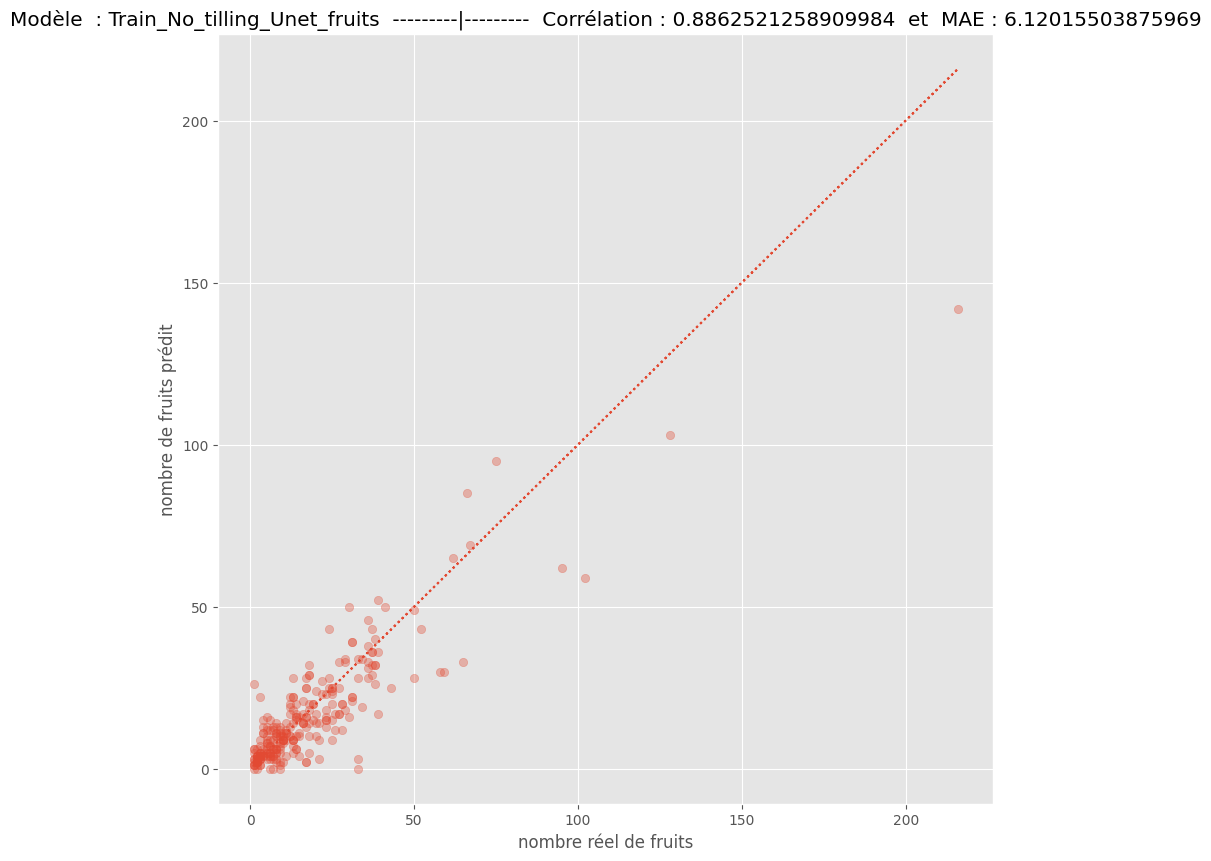

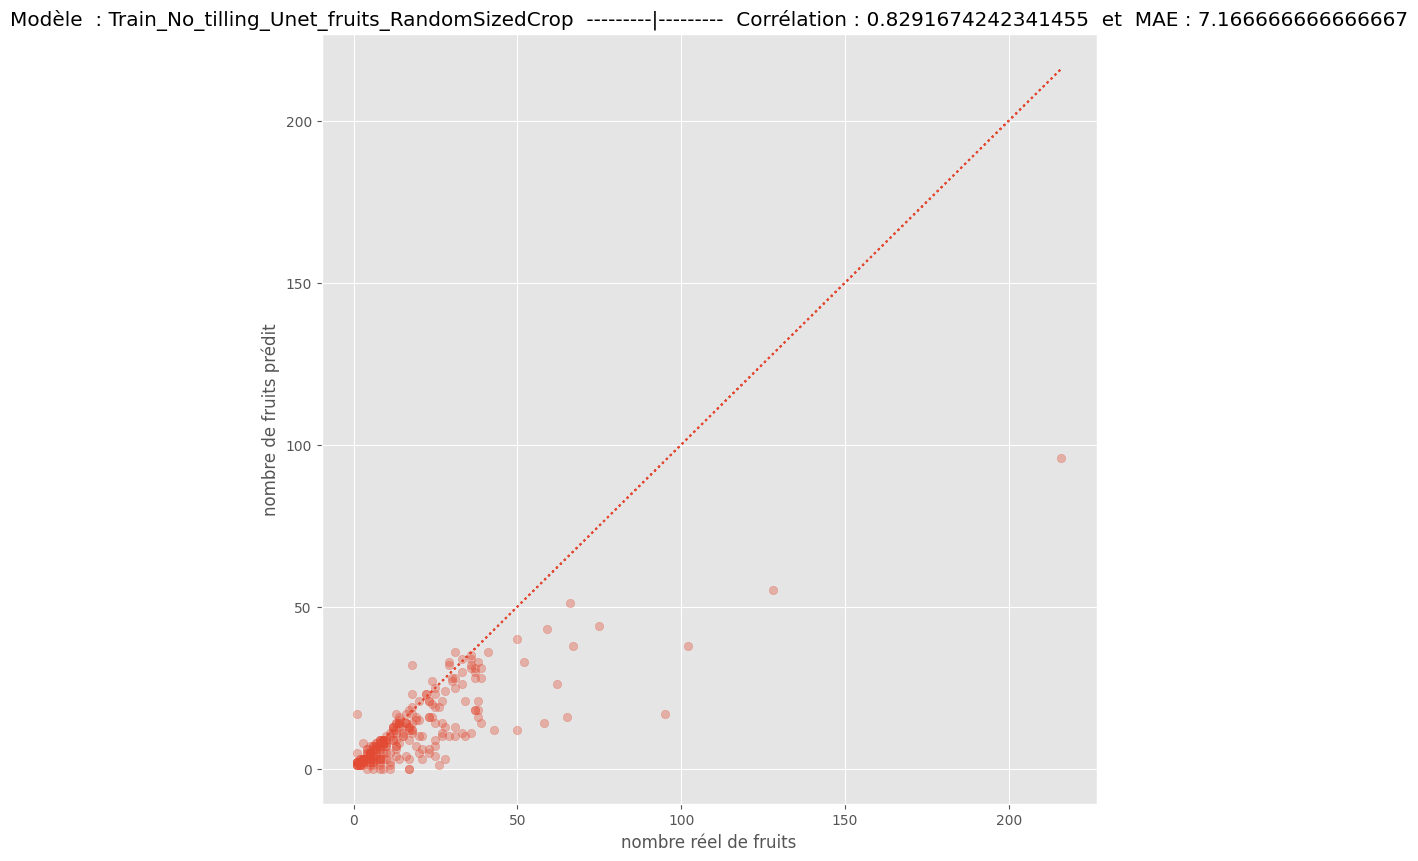

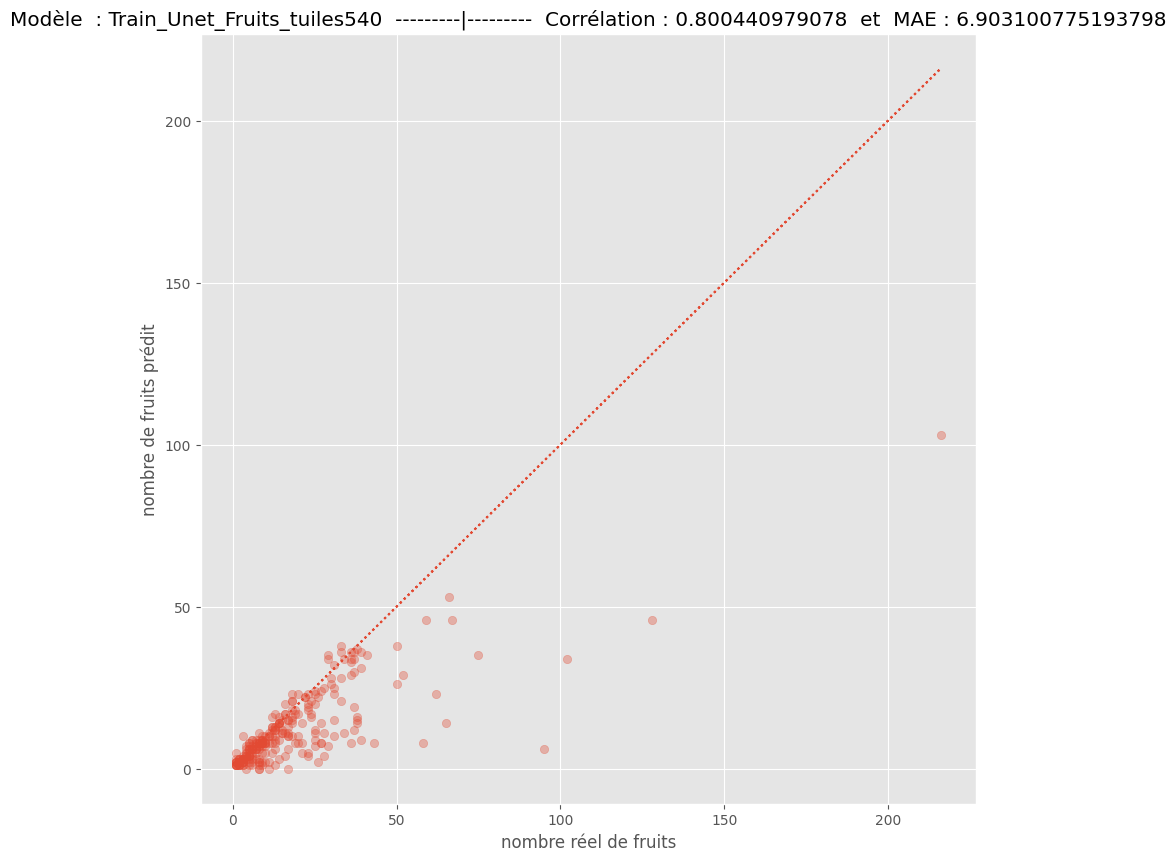

In [ ]:
# Correlation et mae
from sklearn.metrics import mean_absolute_error
import matplotlib as mpl
mpl.style.use("ggplot")

# ------------------------------------------------------------------------
tile_sizes = [640]
prediction_sizes =[640]
# ------------------------------------------------------------------------
list_paths_to_save = [
    "ModelsTraining/Train_No_tilling_Unet_fruits/",
    "ModelsTraining/Train_No_tilling_Unet_fruits_RandomSizedCrop/",
    "ModelsTraining/Train_Unet_Fruits_tuiles540/"
]

for csv_path in list_paths_to_save:
    data = pd.read_csv(csv_path + "prediction.csv")

    for tile_size in tile_sizes:
        for pred_size in prediction_sizes:
            data_ = data.query(f"tile_size=={tile_size} and pred_size=={pred_size}")
            corr = data_['n_predit'].corr(data_['n_reel'])
            mae = mean_absolute_error(data_["n_predit"], data_["n_reel"])

            fig, ax = plt.subplots(1, 1, figsize=(10, 10))
            ax.scatter(x=data_['n_reel'], y=data_['n_predit'], alpha=.35)
            ax.set_title(f"Modèle  : {csv_path.split('/')[1]}  ---------|---------  Corrélation : {corr}  et  MAE : {mae}")
            ax.set_xlabel("nombre réel de fruits")
            ax.set_ylabel("nombre de fruits prédit")
            ax.plot(data_['n_reel'], data_['n_reel'], linestyle = 'dotted')

### Data preparation

In [ ]:
import os, glob
from pathlib import Path

import numpy as np
from PIL import Image, ImageDraw
from tqdm import tqdm

from PIL.JpegImagePlugin import JpegImageFile
from PIL.PngImagePlugin import PngImageFile
# from PIL.Image import Image

import skimage
from skimage.util.shape import view_as_blocks
from skimage import io
from skimage.transform import resize

from typing import List, Tuple, Union


def find_good_length(initial_length: int, total_length: int):
    """
    Find the good length such that the total_length % good_length == 0

    args :
        initial_length : longueur initial
        total_length : la longueur total

    return :
        good_length : la longueur la plus proche de initial_length de telle sorte que
        total_length % good_length == 0
    """
    good_lower_length = 0
    good_higher_length = 0

    for width1 in range(initial_length, 0, -1):
        if total_length % width1 == 0:
            good_lower_length = width1
            break

    for width2 in range(initial_length, total_length + 1, 1):
        if total_length % width2 == 0:
            good_higher_length = width2
            break

    good_length = good_lower_length
    if abs(initial_length - good_higher_length) <= abs(initial_length - good_lower_length):
        good_length = good_higher_length

    return good_length

def find_closest_dividor(initial_number: int, divisor: int):
    """
    Find a number that can be divided by the dividor such that the this number is the closest to initial_number

    args :
        initial_number : le nombre initial à diviser par le diviseur
        divisor : le diviseur

    return :
        good_length : la longueur la plus proche de initial_length de telle sorte que
        total_length % good_length == 0
    """
    good_lower_length = 0
    good_higher_length = 0

    for width1 in range(initial_number, 0, -1):
        if width1 % divisor == 0:
            good_lower_length = width1
            break

    for width2 in range(initial_number, initial_number + divisor + 1, 1):
        if width2 % divisor == 0:
            good_higher_length = width2
            break

    good_length = good_lower_length
    if abs(initial_number - good_higher_length) <= abs(initial_number - good_lower_length):
        good_length = good_higher_length

    return good_length


def tile_image(image: Union[str, JpegImageFile, PngImageFile, Image.Image, np.ndarray],
               tile_height=None, tile_width=None):
    """
    Tuiler une image : la diviser en blocks de n_rows et n_columns
    Les lignes ou colonnes restantes sont ré-attribuées au block les plus proches

    image_name: name of the image with its extension
    n_rows: number of rows
    n_columns: number of columns
    save_path: path to save the image
    """
    if isinstance(image, str):
        if os.path.exists(image):
            image = io.imread(image)
        else:
            raise FileNotFoundError("Can't find the file")

    elif isinstance(image, JpegImageFile or PngImageFile or Image.Image):
        image = np.asarray(image)
    elif isinstance(image, np.ndarray):
        pass
    else:
        raise TypeError(
            "image must be a str, PIL.JpegImagePlugin.JpegImageFile, PIL.PngImagePlugin.PngImageFile, \
            PIL.Image.Image or np.ndarray")

    # Calcul de la taille de chaque patch

    image_shape = image.shape

    # path_height = image_shape[0] // n_rows
    # patch_width = image_shape[1] // n_columns

    # Find the patch width and height close to the initial values provided.
    patch_width = find_good_length(initial_length=tile_width, total_length=image_shape[1])
    path_height = find_good_length(initial_length=tile_height, total_length=image_shape[0])

    n_rows = image_shape[0] // path_height
    n_columns = image_shape[1] // patch_width

    block_shape = []
    if len(image_shape) == 3:
        block_shape = (path_height, patch_width, image_shape[2])
    else:
        block_shape = (path_height, patch_width)

    # Tuiler l'image en pach : n_rows, n_columns, channels
    patches = view_as_blocks(image, block_shape=block_shape)

    return {"patches": patches, "n_rows": n_rows, "n_columns": n_columns, "block_shape": block_shape}


def concat_tiles(tiles_list, n_rows, n_cols):
  """
  Concatenate tiles

  input:
    tiles_list : list of tiles [t1, t2, t3]
    n_rows : number of rows
    n_cols : number of columns

    n_rows * n_cols = len(tiles_list)
    """
  if len(tiles_list) != n_rows * n_cols:
    raise ValueError(f"Number of tiles must be equal to n_rows*n_columns = {n_rows*n_cols}")
  # Create a list of blocks concatenated horizontally
  h_blocks = [numpy.hstack(tiles_list[i*n_cols:(i+1)*n_cols]) for i in range(n_rows)]

  # Créér l'image finale en empilant ces blocks horizontal verticalement
  final_image = numpy.vstack(h_blocks)

  return final_image


class MaskImageConfig(object):
    """
  A configuration class for the mask image.

  We can define its outline width, background color, fill color, and outline color.

  "#000000" -> 0 is the default background color.\n
  "#808080" -> 128 is the default fill color.\n
  "#ffffff" -> 255 is the default outline color.
  """

    def __init__(self, outline_width: int = 3, background_color: str = "#000000",
                 fill_color: str = "#808080", outline_color: str = "#ffffff"):
        """
    Create a mask image configuration.
    Args:
      outline_width: the outline width of the objects in the mask image.
      background_color: the background color of the mask image. For what is not considered as objects
      fill_color: the fill color of the given objects in the mask image.
      outline_color: the outline color of the given objects mask image.

    """
        self.outline_width = outline_width
        self.background_color = background_color
        self.fill_color = fill_color
        self.outline_color = outline_color


"""
=================================== data preparation class ===================================
"""


def change_path_separator(data: str or list, sep_to_replace="\\", new_sep="/"):
    """

    :param data:
    :param sep_to_replace:
    :param new_sep:
    :return:
        data: with the new separator
    """

    def change_single_path_sep(path, old_sep, new_sep_):
        return str(path).replace(old_sep, new_sep_)

    if isinstance(data, str):
        return change_single_path_sep(data, sep_to_replace, new_sep)
    elif isinstance(data, list):
        return list(map(lambda e: change_single_path_sep(e, sep_to_replace, new_sep), data))
    else:
        raise NotImplementedError("Can only modify for str paths or list of str paths")


class DataPreparator(object):
    """
        A class to prepare data for training and validation
        It is characterised by its folder where we can find images and annotations in a specific format
    """

    def __init__(self, data_folder: str, mask_annotation_config: MaskImageConfig = None, data_format: str = "yolov8"):
        self.data_format = data_format
        self.data_folder = data_folder
        self.images = None
        self.annotations = None
        self.mask_annotation_config = mask_annotation_config

    def get_images_annotations(self):
        """
          Get the images and annotations
        """
        if self.data_format == "yolov8":
            self.images = list(map(str, (Path(self.data_folder) / "images").glob("*jpg")))
            self.annotations = list(map(str, (Path(self.data_folder) / "labels").glob("*.txt")))

            return self.images, self.annotations
        else:
            raise NotImplementedError

    def get_polygons(self, path_to_label_file: str, image_path: str):
        """
          Permet de récupérer les polygones présents dans un fichier donnée:
          return:
            polygones: [[(x, y), (x, y), (x, y)], ...]
        """
        if os.path.exists(path_to_label_file):
            if self.data_format == "yolov8":
                with open(path_to_label_file) as file:
                    content = file.readlines()
                    if len(content) > 0:
                        polygones = []
                        imArray = np.asarray(Image.open(image_path).convert("RGBA"))
                        width, height = imArray.shape[1], imArray.shape[0]
                        for e in content:
                            pol = [float(i) for i in e.split(" ")[1:]]
                            pol = [(int(pol[j] * width), int(pol[j + 1] * height)) for j in range(0, len(pol), 2)]
                            polygones.append(pol)

                        return polygones
            else:
                raise NotImplementedError("The data format is not supported")

    def create_img_mask(self, img_path, polygones_path):
        """
            Créer un mask d'image à partir d'une image et des ses annotations en polygone

            img_path : chemin de l'image
            polygones_path: chemin des polygones de l'image

            background_color: the background color of the image
            fill_color: couleur de remplissage du polygone
            outline_color: couleur de la ligne de contour du polygone
            outline_width: epaisseur de la ligne de contour
        """

        # Récupération des polygones correspondant à l'image
        data_polygones = self.get_polygons(polygones_path, img_path)

        # Convertire l'image en numpy_array
        imArray = np.asarray(Image.open(img_path).convert("RGBA"))

        # Mask image to be created characteristics
        outline_width = self.mask_annotation_config.outline_width
        background_color = self.mask_annotation_config.background_color
        fill_color = self.mask_annotation_config.fill_color
        outline_color = self.mask_annotation_config.outline_color

        # Création du masque:
        # mode=L (8-bit pixels, grayscale)
        maskImage = Image.new(mode='L', size=(imArray.shape[1], imArray.shape[0]), color=background_color)
        for pol in data_polygones:  # Dessiner chaque polygone sur l'image
            ImageDraw.Draw(maskImage).polygon(pol, outline=outline_color, fill=fill_color, width=outline_width)
            ImageDraw.Draw(maskImage).polygon(pol, outline=outline_color, fill=fill_color, width=outline_width)

        return maskImage

    def create_mask_annotations(self, tile: bool = True, tile_height=256, tile_width=256,
                                classes_to_satisfy: list = [128],
                                save_path=None, sub_folder=None):
        """
            Create masks from polygon annotations
            tile: if True, the images will be tiled
            tile_height: the width of the tile
            tile_width: the heigth of each tile.
                Note : tile_height and tile_width can be modified in the process
                if the width % tile_width and/or heigth % tile_height are not equal to 0.
            classes_to_satisfy : Classes values that must be in the tiles. Otherwise the tile masks with their
                corresponding image patch won't be saved
            save_path: path to save the masks
            sub_folder: sub folder to save the data in case the data is tiled
        """
        if save_path is None:
            save_path = self.data_folder
        if self.data_format == "yolov8":
            images, annotations = self.get_images_annotations()
            images, annotations = change_path_separator(images), change_path_separator(annotations)
            if len(images) > 0 and len(annotations) > 0:

                # Gestion des dossiers pour le stockage des données
                if tile:
                    if sub_folder is None and save_path == self.data_folder:
                        raise Exception("The save path is the same as the data folder. you must enter a sub_folder!")
                    elif save_path != self.data_folder and sub_folder is not None:
                        Path(save_path).mkdir(exist_ok=True)
                        (Path(save_path) / sub_folder).mkdir(exist_ok=True)
                        (Path(save_path) / sub_folder / "images").mkdir(exist_ok=True)
                        (Path(save_path) / sub_folder / "labels_masks").mkdir(exist_ok=True)

                        save_path = str(Path(save_path) / sub_folder)
                    else:
                        Path(save_path).mkdir(exist_ok=True)
                        save_path = str(Path(save_path) / sub_folder)
                else:
                    (Path(save_path) / "labels_masks").mkdir(exist_ok=True)
                    save_path = str(Path(save_path) / "labels_masks")
                loop = tqdm(enumerate(images), total=len(images), desc=f"Saving data to -> {save_path}...")
                for idx, image_path in loop:
                    image_name_sans_extension = image_path.split("/")[-1][:-4]
                    label_path = os.path.join(self.data_folder, f"labels/{image_name_sans_extension}.txt").replace("\\", "/")
                    # Si l'image a une annotation et que cette annotation n'est pas vide
                    if label_path in annotations and self.get_polygons(label_path, image_path):
                        mask_pil_image = self.create_img_mask(image_path, label_path)
                        if tile:
                            # Create the save path for images and labels_masks
                            save_images_path = str(Path(save_path) / "images")
                            save_masks_path = str(Path(save_path) / "labels_masks")

                            # Tile images and save them in their paths
                            image_name = image_name_sans_extension + ".png"
                            patches_sans_annotation = self.tile_image(mask_pil_image, image_name=image_name,
                                                                      tile_height=tile_height,
                                                                      tile_width=tile_width, save_path=save_masks_path,
                                                                      classes_to_satisfy=classes_to_satisfy)
                            self.tile_image(image_path, image_name=None, tile_height=tile_height, tile_width=tile_width,
                                            save_path=save_images_path, patches_to_discard=patches_sans_annotation)

                        else:
                            path_to_save = os.path.join(save_path, f"{image_name_sans_extension}.png")
                            mask_pil_image.save(path_to_save)
                    else:
                        loop.set_postfix(skip_for=f"{image_name_sans_extension}")

    def tile_image(self, image: Union[
        str, JpegImageFile, PngImageFile, Image.Image, np.ndarray],
                   image_name=None, tile_height=None, tile_width=None, save_path=None,
                   classes_to_satisfy: List[int] = [], patches_to_discard: List[str] = None):
        """
        Tuiler une image : la diviser en blocks de n_rows et n_columns
        Les lignes ou colonnes restantes sont ré-attribuées au block les plus proches

        image_name: name of the image with its extension
        n_rows: number of rows
        n_columns: number of columns
        save_path: path to save the image
        """
        save_file_name = ""
        if isinstance(image, str):
            if os.path.exists(image):
                save_file_name = image
            else:
                raise FileNotFoundError("Can't find the file")

        elif isinstance(image, JpegImageFile | PngImageFile | Image.Image):
            if image_name is None:
                raise ValueError("image_name must be defined")
            save_file_name = image_name

        elif isinstance(image, np.ndarray):
            if image_name is None:
                raise ValueError("image_name must be defined")
            save_file_name = image_name
        else:
            raise TypeError(
                "image must be a str, PIL.JpegImagePlugin.JpegImageFile, PIL.PngImagePlugin.PngImageFile, \
                PIL.Image.Image or np.ndarray")
        if isinstance(classes_to_satisfy, list):
            for e in classes_to_satisfy:
                if not isinstance(e, int):
                    raise ValueError("Classes to satisfy must be a list of integers")
        else:
            raise ValueError("Classes to satisfy must be a list of integers")

        # Tuiler l'image en patch : n_rows, n_columns, channels
        tiling_result = tile_image(image=image, tile_height=tile_height, tile_width=tile_width)

        n_rows = tiling_result["n_rows"]
        n_columns = tiling_result["n_columns"]
        patches = tiling_result["patches"]
        block_shape = tiling_result["block_shape"]

        if save_path is not None:
            # Patches that do not contain some classes
            non_valid_patches = []
            for r in range(n_rows):
                for c in range(n_columns):
                    patch_to_save = patches[r, c].reshape(block_shape)
                    file_name = save_file_name.split("/")[-1][:-4] + f"_row{r}_column{c}" + '.' + \
                                save_file_name.split('.')[-1]
                    if len(classes_to_satisfy) > 0:
                        uniques_classes = np.unique(patch_to_save).tolist()
                        save_patch = True
                        for cls in classes_to_satisfy:
                            if cls not in uniques_classes:
                                save_patch = False
                                non_valid_patches.append(file_name[:-4])
                                break
                        if save_patch:
                            file_path = os.path.join(save_path, file_name).replace("\\", "/")
                            io.imsave(file_path, patch_to_save,
                                      check_contrast=False)
                    else:
                        if file_name[:-4] not in patches_to_discard:
                            file_path = os.path.join(save_path, file_name).replace("\\", "/")
                            io.imsave(file_path, patch_to_save,
                                      check_contrast=False)
            return non_valid_patches
        else:
            patchs = []
            for r in range(n_rows):
                for c in range(n_columns):
                    patchs.append(patches[r, c].reshape(block_shape))

            return patchs



In [ ]:
# Create Masks for the model
maskconfig = MaskImageConfig(outline_width=0)

#train_data_preparator = DataPreparator(data_folder="atf-1/train", mask_annotation_config=maskconfig)
#train_data_preparator.create_mask_annotations(tile=False)
val_data_preparator = DataPreparator(data_folder="atf-1/valid", mask_annotation_config=maskconfig)
val_data_preparator.create_mask_annotations(tile=False)

Saving data to -> atf-1/valid/labels_masks...: 100%|██████████| 258/258 [00:16<00:00, 15.83it/s]


### Mask to yolov8 annotation

In [ ]:
# ================== Convert mask annotation to yolov8 =========================
def mask_annotation_to_yolov8(mask_annotation_path, reassignment_mapping={255: 0}):
  """
  Convert mask annotation to yolov8 format

  args:
    mask_annotation_path: path to the mask annotation
    save_path: path to save the converted mask annotation
    reassignment_mapping: dictionary of reassignment mapping

  return:
    objects_coordinates: list of objects coordinates that are normalized to the image shape
  """
  if isinstance(mask_annotation_path, str):
    if not Path(mask_annotation_path).exists():
      raise FileNotFoundError("Can't find the file")
  image = np.array(Image.open(mask_annotation_path))
  image_shape = image.shape
  if len(reassignment_mapping.keys()) > 0:
    for key in reassignment_mapping.keys():
      image[image == key] = reassignment_mapping[key]
      unik_values = np.unique(image)
  contours = find_contours(image)
  objects_coordinates = []
  for ctr in contours:
    rows = (ctr[:, 0] / image_shape[0]).tolist() # y
    cols = (ctr[:, 1] / image_shape[1]).tolist() # x
    obj = []
    for col, row in zip(cols, rows):
      obj.append(col)
      obj.append(row)
    # If the contour is not closed, close it
    if obj[0] != obj[-2] and obj[1] != obj[-1]:
      obj.append(obj[0])
      obj.append(obj[1])
    objects_coordinates.append(obj)
  return objects_coordinates


def create_yolov8_annotations_from_masks(images_folder, save_folder, reassignment_mapping={255: 0}, class_value=0):
  """
  Create yolov8 annotations from masks and save them in a folder

  args:
    images_folder: path to the images folder
    save_folder: path to save the annotations
    reassignment_mapping: dictionary of reassignment mapping

  return:
    None
  """
  if not Path(images_folder).exists():
    raise FileNotFoundError("Can't find the images folder")

  Path(save_folder).mkdir(exist_ok=True)
  list_images = list(Path(images_folder).glob("*.png"))
  loop = tqdm(list_images, total=len(list_images), desc=f"Saving annotations to :: {save_folder}")
  for file in loop:
    mask_path = str(file).replace("\\", "/")
    save_path = str(Path(save_folder) / file.name).replace("\\", "/")[:-4] + ".txt"
    objects_coordinates = mask_annotation_to_yolov8(mask_path, reassignment_mapping)
    with open(save_path, "w") as f:
      for obj in objects_coordinates:
        row = f"{class_value}"
        for e in obj:
          row += f" {e}"
        row += "\n"
        f.write(row)

In [ ]:
create_yolov8_annotations_from_masks(images_folder="/content/atf-1/valid/labels_masks", save_folder="/content/atf-1/valid/labels_yolov8", reassignment_mapping={255: 128})

Saving annotations to :: /content/atf-1/valid/labels_yolov8: 100%|██████████| 258/258 [00:15<00:00, 16.89it/s]


In [ ]:
img1 = "/content/atf-1/valid/labels_masks/BIG_16_CadreFruitOuest_ArbreEch_1_V1_2022-03-27_jpg.rf.b7c7c5fff4fcc0a4928b2e910c3394e9.png"
img2 = "/content/atf-1/valid/labels_masks/BIG_16_CadreFruitEst_ArbreEch_1_V1_2022-03-27_jpg.rf.7cbc082c7745ba916ea2e4a434707b63.png"
img3 = "/content/atf-1/valid/labels_masks/BIG_18_CadreFruitSud_ArbreEch_3_V1_2022-03-25_jpg.rf.c8d24730556249ba8039781394fad432.png"

Iage shape : (1080, 1080)


[[0.43703703703703706,
  0.3597222222222222,
  0.4361111111111111,
  0.3597222222222222,
  0.4351851851851852,
  0.3597222222222222,
  0.43425925925925923,
  0.3597222222222222,
  0.43333333333333335,
  0.3597222222222222,
  0.4324074074074074,
  0.3597222222222222,
  0.43148148148148147,
  0.3597222222222222,
  0.4305555555555556,
  0.3597222222222222,
  0.42962962962962964,
  0.3597222222222222,
  0.4287037037037037,
  0.3597222222222222,
  0.42777777777777776,
  0.3597222222222222,
  0.42685185185185187,
  0.3597222222222222,
  0.42592592592592593,
  0.3597222222222222,
  0.425462962962963,
  0.3592592592592593,
  0.42592592592592593,
  0.3587962962962963,
  0.4263888888888889,
  0.35833333333333334,
  0.4263888888888889,
  0.3574074074074074,
  0.4263888888888889,
  0.35648148148148145,
  0.4263888888888889,
  0.35555555555555557,
  0.42685185185185187,
  0.35509259259259257,
  0.4273148148148148,
  0.35462962962962963,
  0.4273148148148148,
  0.3537037037037037,
  0.42731481481481

In [ ]:
a = mask_annotation_to_yolov8(img3)
a_orig = np.array(Image.open(img3))

Unique values : [  0 128]


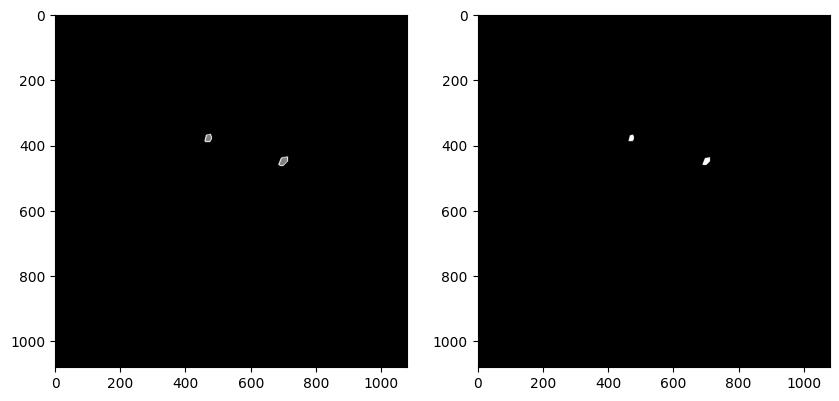

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(a_orig, cmap="gray")
ax[1].imshow(a, cmap="gray")

In [ ]:
ctrs1 = find_contours(a_orig)
ctrs2 = find_contours(a)
print(len(ctrs1), len(ctrs2))

2 2


In [ ]:
# contours : (row, column)

In [ ]:
ctrs2[0] / 1080
for e in (ctrs2[1] / 1080).tolist() :
  print(e)
  break

[0.4273148148148148, 0.6462962962962963]


In [ ]:
for ctr in ctrs1:
  print(ctr[:,1] / 1080.)
  break

[    0.43704     0.43611     0.43519     0.43426     0.43333     0.43241     0.43148     0.43056     0.42963      0.4287     0.42778     0.42685     0.42593     0.42546       0.425     0.42454     0.42407     0.42361     0.42315     0.42269     0.42269     0.42315     0.42361     0.42361     0.42361     0.42361
     0.42407     0.42454     0.42454     0.42454     0.42454       0.425     0.42546     0.42546     0.42546     0.42546     0.42593     0.42639     0.42639     0.42639     0.42639     0.42685     0.42731     0.42731     0.42778      0.4287     0.42963     0.43056     0.43102     0.43148     0.43241     0.43333
     0.43426     0.43519     0.43565     0.43611     0.43704     0.43796     0.43889     0.43935     0.43981     0.44028     0.44074      0.4412     0.44167     0.44213     0.44213     0.44213     0.44213     0.44259     0.44306     0.44352     0.44398     0.44398     0.44398     0.44398     0.44398     0.44398
     0.44398     0.44398     0.44398     0.44398     0.44398 

In [ ]:
print(ctrs1, type(ctrs1))

[array([[      391.5,         472],
       [      391.5,         471],
       [      391.5,         470],
       [      391.5,         469],
       [      391.5,         468],
       [      391.5,         467],
       [      391.5,         466],
       [      391.5,         465],
       [      391.5,         464],
       [      391.5,         463],
       [      391.5,         462],
       [      391.5,         461],
       [      391.5,         460],
       [        391,       459.5],
       [      390.5,         459],
       [        390,       458.5],
       [      389.5,         458],
       [        389,       457.5],
       [      388.5,         457],
       [        388,       456.5],
       [        387,       456.5],
       [      386.5,         457],
       [        386,       457.5],
       [        385,       457.5],
       [        384,       457.5],
       [        383,       457.5],
       [      382.5,         458],
       [        382,       458.5],
       [        381

### Datasets config

In [ ]:
import glob
import os
from typing import List, Dict
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from PIL import Image
import albumentations as A
from pathlib import Path

"""Data Documentation"""


def get_train_augs(image_size):
    return A.Compose([
        A.Resize(image_size, image_size)
    ])


def get_val_augs(image_size):
    return A.Compose([
        A.Resize(image_size, image_size)
    ])


class DatasetConfig(object):
    """
    Configuration for loading datasets
    """

    def __init__(self, batch_size: int = 8, image_size: int = 640, augmentations: A.Compose = None,
                 num_classes: int = 3, classes_pixels_values: List[int] = [0, 128, 255],
                 classes_names: List[str] = ["background", "fruit", "edge"],
                 labels_mapping: Dict[int, int] = {0: 0, 128: 1, 255: 2},
                 data_config=None):
        self.BATCH_SIZE = batch_size
        self.IMAGE_SIZE = image_size
        if augmentations is not None:
            self.AUGMENTATIONS = augmentations(self.IMAGE_SIZE)
        else:
            self.AUGMENTATIONS = self.getAugs(self.IMAGE_SIZE)
        self.NUM_CLASSES = num_classes
        self.CLASSES_PIXELS_VALUES = classes_pixels_values
        self.CLASSES_NAMES = classes_names
        self.LABELS_MAPPING = labels_mapping

        self.data_config = data_config
        self.LIST_IMAGES, self.LIST_ANNOTATIONS = self.getData()

        print("Nombre images :", len(self.LIST_IMAGES))
        print("Nombre annotations :", len(self.LIST_ANNOTATIONS))

    def getData(self):
        """
        Récupérer la liste des images et des annotations à partir du dossier contenant les images.
        le dossier doit être comme suit:
            images
            labels_masks
        :return:  absolute paths of
            liste_images list()
            liste_annotations list()
        """
        images_paths = list(Path(self.data_config["images"]).glob("*.jpg"))
        labels_paths = list(Path(self.data_config["labels_masks"]).glob("*.png"))

        images_paths = change_path_separator(images_paths)
        labels_paths = change_path_separator(labels_paths)

        if len(images_paths) == 0 | len(labels_paths) == 0:
            raise Exception(f"Images or masks are missing! Number of images = {len(images_paths)} \
                            and Number of masks = {len(labels_paths)}.Please the data path! \
                            Masks should be .png files and images .jpg files")

        liste_images = []
        liste_annotations = []
        for img_path in images_paths:
            label_path = os.path.join(self.data_config["labels_masks"],
                                      img_path.split("/")[-1][:-4] + ".png").replace("\\", "/")
            if label_path in labels_paths:
                liste_images.append(img_path)
                liste_annotations.append(label_path)
        return sorted(liste_images), sorted(liste_annotations)

    def getAugs(self, image_size):
        """

        :param image_size:
        return:
        """
        return A.Compose([
                    A.Resize(image_size, image_size)
        ])


"""CUSTOM DATASET"""


class SegmentationDataset(Dataset):

    def __init__(self, dataset_config: DatasetConfig):
        """
    liste_images: liste des chemins absolus vers les images
    liste_annotations; liste des chemins absolus vers les annotations
    classes_pixels_values: valeurs de pixels correspondant aux différentes classes. 0 -> background | 128: fruit | 255: contour

    """
        self.liste_images = dataset_config.LIST_IMAGES
        self.liste_annotations = dataset_config.LIST_ANNOTATIONS
        self.mapping = dataset_config.LABELS_MAPPING
        self.classes_pixels_values = dataset_config.CLASSES_PIXELS_VALUES
        self.augmentations = dataset_config.AUGMENTATIONS
        self.BATCH_SIZE = dataset_config.BATCH_SIZE
        self.IMAGE_SIZE = dataset_config.IMAGE_SIZE

    def __len__(self):
        return len(self.liste_images)

    def mask_to_class_f(self, mask):
        """
        Replaces each pixel with its class index.
        e.g: 0 by 0, 128 by 1 and 255 by 2
        """
        masque = np.copy(mask)
        for k in self.mapping:
            masque[mask == k] = self.mapping[k]
        return masque.astype(dtype=np.int8)

    def __getitem__(self, index):
        image_array = np.asarray(Image.open(self.liste_images[index]))
        f_label_array = np.asarray(Image.open(self.liste_annotations[index]))
        label_array = np.copy(f_label_array)
        label_array = self.mask_to_class_f(label_array)

        if self.augmentations:
            data = self.augmentations(image=image_array, mask=label_array)
            image_array, label_array = data["image"], data["mask"]

        # Transpose to change the dimensions : (height, width, channels) -> (channels, height, width)
        image_array = np.transpose(image_array, (2, 0, 1)).astype(np.float32)
        # label_array = numpy.transpose(label_array, (2, 0, 1)).astype(numpy.int64)

        image_array = torch.Tensor(image_array) / 255.0
        label_array = torch.Tensor(label_array).long()

        return image_array, label_array

    def load_data(self, drop_last=True, shuffle=True, batch_size=None):
        if batch_size is None:
            batch_size = self.BATCH_SIZE
        return DataLoader(dataset=self, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)


def getDataLoader(dataset_config=None, drop_last=True, shuffle=True, batch_size=None):
    """
    Get the data loader that the trainer and the validator will use to train the model
    """

    dataset = SegmentationDataset(dataset_config)

    return dataset.load_data(drop_last=True, shuffle=True, batch_size=None)


In [ ]:
# Train and val data building
train_data_path = "/content/atf-1/train"
val_data_path = "/content/atf-1/valid"

In [ ]:
# ========================== Create tiled data ==================
DataPreparator(data_folder=train_data_path, mask_annotation_config= MaskImageConfig()).create_mask_annotations(tile_height=360,
                            save_path="/content/data", sub_folder="train")
DataPreparator(data_folder=val_data_path, mask_annotation_config= MaskImageConfig()).create_mask_annotations(tile_height=360,
                            save_path="/content/data", sub_folder="valid")

Saving data to -> /content/data/valid...: 100%|██████████| 258/258 [01:16<00:00,  3.35it/s]


In [ ]:
print(len(os.listdir("/content/data/train/images")))
print(len(os.listdir("/content/data/valid/images")))
print(len(os.listdir("/content/data/train/labels_masks")))
print(len(os.listdir("/content/data/valid/labels_masks")))

In [ ]:
# =================== Masks Datasets ==========
"""train_data_config = DatasetConfig(batch_size=1, image_size=960, augmentations=None, num_classes=1,
                                  classes_pixels_values=[0, 255], classes_names=["background", "Cadre"],
                                  labels_mapping={0: 0, 255: 255},
                                  data_folder="Framedetection-13/train")"""

val_data_config = DatasetConfig(batch_size=1, image_size=960, augmentations=None, num_classes=1,
                                classes_pixels_values=[0, 255], classes_names=["background", "Cadre"],
                                labels_mapping={0: 0, 255: 255},
                                data_config={"images": "Framedetection-13/valid/images", "labels_masks": "Framedetection-13/valid/labels_masks"})

# train_dataloader = getDataLoader(dataset_config=train_data_config, drop_last=True, batch_size=8, shuffle=True)
val_dataloader = getDataLoader(dataset_config=val_data_config, drop_last=False, batch_size=1, shuffle=False)
for images, masks in val_dataloader:
    print("Images Batch shape :", images.shape)
    print("Maks Batch shape :", masks.shape)
    break

Nombre images : 199
Nombre annotations : 199
Images Batch shape : torch.Size([1, 3, 960, 960])
Maks Batch shape : torch.Size([1, 960, 960])


In [ ]:
# =================== Datasets ==========
train_data_config = DatasetConfig(batch_size=8, image_size=360, augmentations=None, num_classes=3,
                                  classes_pixels_values=[0, 128, 255], classes_names=["background", "fruit", "edge"],
                                  labels_mapping={0: 0, 128: 1, 255: 2},
                                  data_folder="/content/data/train")

val_data_config = DatasetConfig(batch_size=8, image_size=360, augmentations=None, num_classes=3,
                                classes_pixels_values=[0, 128, 255], classes_names=["background", "fruit", "edge"],
                                labels_mapping={0: 0, 128: 1, 255: 2},
                                data_folder="/content/data/valid")

train_dataloader = getDataLoader(dataset_config=train_data_config, drop_last=True, batch_size=8, shuffle=True)
val_dataloader = getDataLoader(dataset_config=val_data_config, drop_last=True, batch_size=8, shuffle=False)

for images, masks in val_dataloader:
    print("Images Batch shape :", images.shape)
    print("Maks Batch shape :", masks.shape)
    break

for images, masks in train_dataloader:
    print("Images Batch shape :", images.shape)
    print("Maks Batch shape :", masks.shape)
    break

Images Batch shape : torch.Size([8, 3, 360, 360])
Maks Batch shape : torch.Size([8, 360, 360])
Images Batch shape : torch.Size([8, 3, 360, 360])
Maks Batch shape : torch.Size([8, 360, 360])


### Trainer and Validator config

In [ ]:
def compute_metrics(stats, dict_metrics={"accuracy": smp.metrics.functional.accuracy,\
    "iou_score": smp.metrics.functional.iou_score, "f1_score" :smp.metrics.functional.f1_score}, classes_names=["global", "background", "fruit", "edge"], classes_indexes=[-1, 0, 1, 2]):
  """
  Compute some metrics for all the classes and the overall score

  return a dict of metrics:
      {metric_name_class_name: metric_value}
  """
  metrics_keys = dict_metrics.keys()
  metrics_values = {f"{metrics_key}_{class_name}": None for metrics_key in metrics_keys for class_name in classes_names}

  for metric_key in metrics_keys:
    metric_function = dict_metrics[metric_key]
    for i, class_name in zip(classes_indexes, classes_names):
      if class_name == "global":
        global_metric = metric_function(stats[0], stats[1], stats[2], stats[3], reduction="micro")
        metrics_values[f"{metric_key}_{class_name}"] = global_metric.item()
      else:
        by_class_metric = metric_function(stats[0].sum(dim=0), stats[1].sum(dim=0), stats[2].sum(dim=0), stats[3].sum(dim=0), reduction=None)
        metrics_values[f"{metric_key}_{class_name}"] = by_class_metric[i].item()

  return metrics_values

def compute_loss(logits, masks, mode="multiclass"):
  """
  Compute the Dice loss for the given logits and masks

  logits: tensor of shape (batch_size, num_classes, height, width)
  masks: tensor of shape (batch_size, height, width)
  mode: "multiclass" or "binary"
  """
  loss = DiceLoss(mode="multiclass", from_logits=True)(logits, masks)
  loss_format = "{:.2f}".format(loss)
  return loss, loss_format


class EarlyStopping:
  def __init__(self, patience=50):
    self.patience = patience
    self.best_loss = None
    self.counter = 0
    self.status = ""

  def __call__(self, val_loss):
    if self.best_loss is None:
      self.best_loss = val_loss
    elif self.best_loss > val_loss:
      self.best_loss = val_loss
      self.counter = 0
    else:
      self.counter += 1
      if self.counter == self.patience:
        return True
    return False

class Trainer(object):
  def __init__(self, _data, model, epochs, save_dir):
    self.data = _data
    self.model = model
    self.epochs = epochs
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.save_dir = save_dir
    self.early_stopper = None

  def compute_loss(self, logits, masks, mode="multiclass"):
    """
    Compute the Dice loss for the given logits and masks

    logits: tensor of shape (batch_size, num_classes, height, width)
    masks: tensor of shape (batch_size, height, width)
    mode: "multiclass" or "binary"
    """
    mode = "multiclass" if self.model.model_building_config["classes"] == 3 else "binary"
    loss = JaccardLoss(mode=mode, from_logits=True, eps=1e-6, log_loss=True)(logits, masks)
    return loss

  def train_epoch(self, data_loader, optimizer, epoch, n_epochs):
    """
    Train the model for one epoch
    """
    self.model.train()
    total_loss = 0
    loop_train = tqdm(data_loader, desc=f"Epoch {epoch} / {n_epochs}")
    for images, masks in loop_train:
      images, masks = images.to(self.device), masks.to(self.device)

      optimizer.zero_grad()
      logits = self.model(images)
      loss = self.compute_loss(logits, masks)
      loss.backward()   # Calculer les gradients de la fonction coût par rapport au paramètres du modèle
      optimizer.step() # Mettre à jour les paramètres du modèle

      total_loss += (loss.item() / len(data_loader))
      loss_format = "{:.5f}".format(total_loss)
      loop_train.set_description(f"Epoch {epoch+1} / {n_epochs}     Training... dice_loss = {loss_format} ")
    return total_loss

  def val_epoch(self, data_loader):
    """
    Evaluate the model for one epoch
    """
    self.model.eval()
    with torch.no_grad():
      total_loss = 0
      loop_eval = tqdm(data_loader, desc="evaluating")
      for images, masks in loop_eval:
        images, masks = images.to(self.device), masks.to(self.device)
        logits = self.model(images)
        loss = self.compute_loss(logits, masks)

        total_loss += (loss.item() / len(data_loader))
        loss_format = "{:.5f}".format(total_loss)
        loop_eval.set_description(f"               Validation... dice_loss = {loss_format} ")
      return total_loss

  def train(self, train_checkpoint=None, patience=50):
    """
      Train the model for all the epochs
    """
    import pandas as pd

    (Path(self.save_dir) / "weights").mkdir(exist_ok=True)
    weights_path = str(Path(self.save_dir) / "weights").replace("\\", "/")
    save_dir = str(Path(self.save_dir)).replace("\\", "/")
    # ----------------------- Get the train and val dataloaders ---------------
    train_loader =SegmentationDataset(self.data["train"]).load_data()
    val_loader =SegmentationDataset(self.data["val"]).load_data()


    # data_loader, optimizer, epoch, n_epochs

    LR = 0.005
    optimizer = torch.optim.Adam(self.model.parameters(), lr=LR)
    best_val_loss = 0
    start = 0
    end = self.epochs
    df = pd.DataFrame({
        "epoch": [],
        "train_loss": [],
        "val_loss": []
    })
    """scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
         optimizer, mode="min", factor=0.5, threshold=0.001, patience=10
    )"""

    cols = ["epoch", "train_loss", "val_loss"]
    if train_checkpoint is not None:
      ckpt = torch.load(train_checkpoint, map_location=self.device)
      self.model.load_state_dict(ckpt["model_state_dict"])
      optimizer.load_state_dict(ckpt["optimizer_state_dict"])
      # scheduler.load_state_dict(ckpt["scheduler_state_dict"])

      start = ckpt["epoch"] + 1
      end = start + self.epochs + 1
      best_val_loss = ckpt["best_val_loss"]
      df = pd.read_csv(save_dir + "/results.csv")
      df = df[cols]

    # ----------- initialize the early stopper ------------
    # self.early_stopper = EarlyStopping(patience=patience)
    # ---------------------- Start traning ------------------------------------
    for epoch in range(start, end):

      best_val_loss = 0
      train_loss = self.train_epoch(train_loader, optimizer, epoch, self.epochs)
      val_loss = self.val_epoch(val_loader)

      # scheduler.step(val_loss)

      if epoch == 0:
          best_val_loss = val_loss
      elif val_loss < best_val_loss:
        best_val_loss = val_loss


      df.loc[len(df.index)] = [epoch, train_loss, val_loss]
      df.to_csv(save_dir + "/results.csv")
      self.model.save(weights_path + "/best.pt")
      self.model.save(weights_path + "/last.pt")
      self.model.save(weights_path + "/train_checkpoint.pt",
                      {
                          "epoch": epoch,
                          "optimizer_state_dict": optimizer.state_dict(),
                          "best_val_loss": best_val_loss,
                          "model_state_dict": self.model.state_dict()
                          # ,"scheduler_state_dict": scheduler.state_dict()
                      })
      """if self.early_stopper(val_loss=val_loss):
        print(f"Fin de l'entrainement à l'époque {epoch+1}")
        break"""
      print()

### Start training

In [ ]:
dat_ = {
    "train_images": "/content/drive/MyDrive/ModelsTraining/Framedetection-13/train/images",
    "train_masks": "/content/drive/MyDrive/ModelsTraining/Framedetection-13/train/labels_masks",
    "val_images": "/content/drive/MyDrive/ModelsTraining/Framedetection-13/valid/images",
    "val_masks": "/content/drive/MyDrive/ModelsTraining/Framedetection-13/valid/labels_masks"
}

def augments(img_size=960):
  augs = A.Compose([
      A.Resize(img_size, img_size),
      A.HorizontalFlip(p=0.5)
  ])
  return augs

"""
Train image size : 960
  H flip
  Resize

Batch Size : 4
Epochs : 500
Loss : -log(IoU)


"""

'\nTrain image size : 960\n  H flip\n  Resize\n\nBatch Size : 4\nEpochs : 500\nLoss : -log(IoU)\n\n\n'

In [ ]:
save_path = "/content/drive/MyDrive/ModelsTraining/SegmentFrameFinale/NoAttention"
model_cadre = SegmentationModel("/content/drive/MyDrive/ModelsTraining/SegmentFrameFinale/NoAttention/configNoAttention.yaml")
model_cadre.fit(donnees_dict=dat_, batch_size=4, augmentations=augments, image_size=960, save_dir=save_path, epochs=500
                , train_checkpoint=save_path + "/weights/train_checkpoint.pt"
                )

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 75.4MB/s]


Nombre images : 600
Nombre annotations : 600
Nombre images : 199
Nombre annotations : 199


Epoch 494 / 500     Training... dice_loss = 0.00680 : 100%|██████████| 150/150 [05:51<00:00,  2.34s/it]
               Validation... dice_loss = 0.02036 : 100%|██████████| 49/49 [02:29<00:00,  3.06s/it]


Epoch 495 / 500     Training... dice_loss = 0.00679 : 100%|██████████| 150/150 [02:23<00:00,  1.04it/s]
               Validation... dice_loss = 0.01990 : 100%|██████████| 49/49 [00:20<00:00,  2.43it/s]


Epoch 496 / 500     Training... dice_loss = 0.00708 : 100%|██████████| 150/150 [02:22<00:00,  1.05it/s]
               Validation... dice_loss = 0.02045 : 100%|██████████| 49/49 [00:18<00:00,  2.71it/s]


Epoch 497 / 500     Training... dice_loss = 0.00712 : 100%|██████████| 150/150 [02:24<00:00,  1.04it/s]
               Validation... dice_loss = 0.02118 : 100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Epoch 498 / 500     Training... dice_loss = 0.00665 : 100%|██████████| 150/150 [02:24<00:00,  1.04it/s]
               Validation... dice_loss = 0.01969 : 100%|██████████| 49/49 [00:18<00:00,  2.72it/s]


Epoch 499 / 500     Training... dice_loss = 0.00679 : 100%|██████████| 150/150 [02:22<00:00,  1.05it/s]
               Validation... dice_loss = 0.01970 : 100%|██████████| 49/49 [00:18<00:00,  2.71it/s]


Epoch 500 / 500     Training... dice_loss = 0.00883 : 100%|██████████| 150/150 [02:21<00:00,  1.06it/s]
               Validation... dice_loss = 0.01982 : 100%|██████████| 49/49 [00:18<00:00,  2.67it/s]


Epoch 501 / 500     Training... dice_loss = 0.00096 :  12%|█▏        | 18/150 [00:17<02:07,  1.04it/s]


KeyboardInterrupt: 

In [ ]:
dataset_cfg = DatasetConfig(
    batch_size = 8, image_size = 640,
                 num_classes = 2, classes_pixels_values = [0, 255],
                 classes_names = ["background", "cadre"],
                 labels_mapping = {0: 0, 255: 1},
                 data_config={
                     "images": "/content/drive/MyDrive/ModelsTraining/Framedetection-13/valid/images",
                     "labels_masks": "/content/drive/MyDrive/ModelsTraining/Framedetection-13/valid/labels_masks"
                 }
)

dataloader = SegmentationDataset(dataset_cfg).load_data(drop_last=False, shuffle=False, batch_size=8)

Nombre images : 199
Nombre annotations : 199


In [ ]:
import torcheval

In [ ]:
model_cadre = SegmentationModel("/content/drive/MyDrive/ModelsTraining/SegmentFrameFinale/weights/last.pt")
device = "cuda" if torch.cuda.is_available() else "cpu"

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 171MB/s]


In [ ]:
def val_model(model, dataloader):
  model.eval()

  with torch.no_grad():
    preds = None
    masks = None
    i = 0
    for images, masks_ in dataloader:
      images, masks_ = images.to(device), masks_.to(device)
      pred = model(images)
      pred = torch.nn.Sigmoid()(pred)
      pred = (pred >= 0.5).long()
      masks_ = torch.unsqueeze(masks_, dim=1)

      if i == 0:
        preds = pred
        masks = masks_
      else:
        preds = torch.cat((preds, pred), dim=0)
        masks = torch.cat((masks, masks_), dim=0)
    print("preds.shape :", preds.shape)
    print("preds.shape :", masks.shape)
    prediction_flattened = torch.flatten(preds)
    masks_flattened = torch.flatten(masks)
    f1_scores = multiclass_f1_score(input=prediction_flattened, target=masks_flattened, num_classes=2, average=None)
    accuracies = multiclass_accuracy(input=prediction_flattened, target=masks_flattened, num_classes=2, average=None)
    precisions = multiclass_precision(input=prediction_flattened, target=masks_flattened, num_classes=2, average=None)
    recalls= multiclass_recall(input=prediction_flattened, target=masks_flattened, num_classes=2, average=None)
    return f1_scores, accuracies, precisions, recalls



In [ ]:
img_p = "/content/drive/MyDrive/ModelsTraining/Framedetection-13/valid/images/BIG_18_CadreFruitSud_ArbreEch_1_V1_2022-03-25_jpg.rf.458959b52ea8c0f7a4645cdcc194c748.jpg"
res = model_cadre.predict(image=img_p, prediction_size=960, device="cuda")

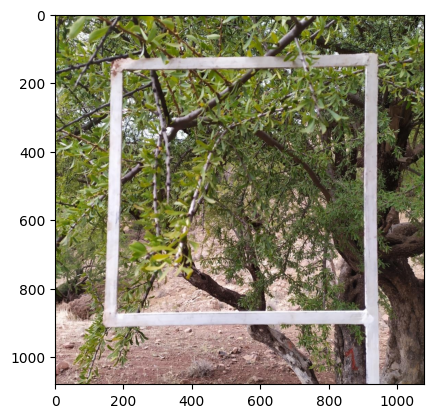

In [ ]:
plt.imshow(io.imread(img_p))

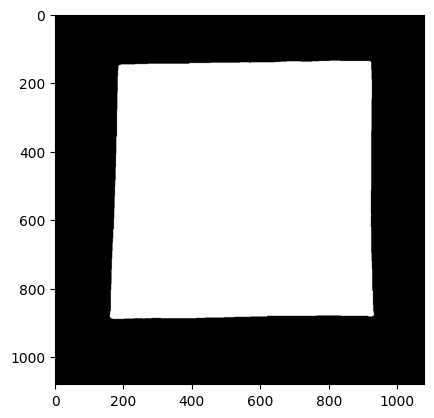

In [ ]:
plt.imshow(res, cmap="gray")

In [ ]:
tensor([[303012],
        [351207],
        [329277],
        [303880],
        [196818],
        [147953],
        [240006],
        [277514]], device='cuda:0')

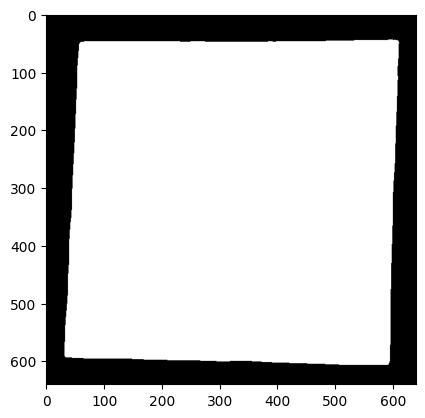

In [ ]:
a = np.squeeze(pred[0, ...].cpu(), axis=0)
plt.imshow(a, cmap="gray")

In [ ]:
# Valider le modèle
def EvalEpoch(model, val_loader):
  """
  model: model to evaluate
  val_loader: validation data loader

  return: metrics
  """
  model.eval()
  with torch.no_grad():
    loop_eval = tqdm(val_loader, desc="evaluating")
    TP, FP, FN, TN = 0, 0, 0, 0

    i = 0
    for images, masks in loop_eval:
      images, masks = images.to(DEVICE), masks.to(DEVICE)
      pred = model(images)
      pred = torch.nn.Sigmoid()(pred)
      pred = (pred >= 0.5).long()
      stats = smp.metrics.get_stats(output=pred, target=masks, mode="binary")
      if i == 0:
        TP = stats[0]
        FP = stats[1]
        FN = stats[2]
        TN = stats[3]
      else:
        TP = torch.cat((TP, stats[0]), dim=0)
        FP = torch.cat((FP, stats[1]), dim=0)
        FN = torch.cat((FN, stats[2]), dim=0)
        TN = torch.cat((TN, stats[3]), dim=0)
      i += 1

    stats = [TP, FP, FN, TN]

    # Compute metrics gobally and for each class : accuracy, f1_score, iou_score
    metrics = compute_metrics(stats)

    return metrics

In [ ]:
dataset_cfg = DatasetConfig(
    batch_size = 8, image_size = 640,
                 num_classes = 2, classes_pixels_values = [0, 255],
                 classes_names = ["background", "cadre"],
                 labels_mapping = {0: 0, 255: 1},
                 data_config={
                     "images": "/content/drive/MyDrive/ModelsTraining/Framedetection-13/valid/images",
                     "labels_masks": "/content/drive/MyDrive/ModelsTraining/Framedetection-13/valid/labels_masks"
                 }
)

dataloader = SegmentationDataset(dataset_cfg).load_data(drop_last=False, shuffle=False, batch_size=8)

In [ ]:
# =================================== Functions to run a epoch of training and validation ====================
from tqdm import tqdm



def TrainEpoch(model, train_loader, optimizer):
  """
  model: model to train
  train_loader: training data loader
  optimizer: optimizer to use
  epoch: current epoch
  """
  model.train()
  total_loss = 0
  loop_train = tqdm(train_loader, desc="training")
  for images, masks in loop_train:
    images, masks = images.to(DEVICE), masks.to(DEVICE)

    optimizer.zero_grad()
    loss = model(images, masks)
    loss.backward()   # Calculer les gradients de la fonction coût par rapport au paramètres du modèle
    optimizer.step() # Mettre à jour les paramètres du modèle

    total_loss += (loss.item() / len(train_loader))
    loop_train.set_description(f"Current train loss = {total_loss} ")
  return total_loss


def EvalEpoch(model, val_loader):
  """
  model: model to evaluate
  val_loader: validation data loader

  return: metrics
  """
  model.eval()
  with torch.no_grad():
    loop_eval = tqdm(val_loader, desc="evaluating")
    TP, FP, FN, TN = 0, 0, 0, 0

    i = 0
    for images, masks in loop_eval:
      images, masks = images.to(DEVICE), masks.to(DEVICE)
      stats = model.val(images, masks)
      if i == 0:
        TP = stats[0]
        FP = stats[1]
        FN = stats[2]
        TN = stats[3]
      else:
        TP = torch.cat((TP, stats[0]), dim=0)
        FP = torch.cat((FP, stats[1]), dim=0)
        FN = torch.cat((FN, stats[2]), dim=0)
        TN = torch.cat((TN, stats[3]), dim=0)
      i += 1

    stats = [TP, FP, FN, TN]

    # Compute metrics gobally and for each class : accuracy, f1_score, iou_score
    metrics = compute_metrics(stats)

    accuracy_all = metrics["accuracy_global"]

    f1_score_fruit = metrics["f1_score_fruit"]
    f1_score_all = metrics["f1_score_global"]

    loop_eval.set_description(f"Accuracy = {'{:.2f}'.format(accuracy_all)} \
     F1-score = {'{:.2f}'.format(f1_score_all)}  F1-score_fruits = {'{:.2f}'.format(f1_score_fruit)}")

    return metrics






In [ ]:
EPOCHS = 50
LR=0.005
optimizer = torch.optim.Adam(model_fruits.parameters(), lr=LR)

In [ ]:
"""
Metrics keys are like this : {'accuracy_global', 'accuracy_background', 'accuracy_fruit', 'accuracy_edge', 'iou_score_global'
 'iou_score_background', 'iou_score_fruit', 'iou_score_edge', 'f1_score_global', 'f1_score_background', 'f1_score_fruit', 'f1_score_edge'
 """
save_path = "/content/drive/MyDrive/MFE/Models/UnetTilling1/weights"

with open("/content/drive/MyDrive/MFE/Models/UnetTilling1/results.csv", 'w') as f:
  f.write("epoch,train_loss,accuracy,f1_score\n")
  best_accuracy_all = 0
  for epoch in range(EPOCHS):
    train_loss = TrainEpoch(model_fruits, train_dataset_loader, optimizer)
    metrics = EvalEpoch(model_fruits, val_dataset_loader)

    accuracy_all = metrics["accuracy_global"]
    f1_score_all = metrics["f1_score_global"]

    # -------------- Model evaluation Metrics ------------------
    torch.save(model_fruits.state_dict(), save_path + "/last.pt")
    if epoch == 0:
      best_accuracy_all = accuracy_all
    else:
      if accuracy_all < best_accuracy_all:
        best_accuracy_all = accuracy_all
        torch.save(model_fruits.state_dict(), save_path + "/best.pt")

    f.write(f"{epoch+1},{train_loss},{accuracy_all},{f1_score_all}\n")
    print()

## validation

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def compute_metrics(stats, dict_metrics={"accuracy": smp.metrics.functional.accuracy,\
    "iou_score": smp.metrics.functional.iou_score, "f1_score" :smp.metrics.functional.f1_score}, classes_names=["global", "background", "fruit", "edge"], classes_indexes=[-1, 0, 1, 2]):
  """
  Compute some metrics for all the classes and the overall score

  return a dict of metrics:
      {metric_name_class_name: metric_value}
  """
  metrics_keys = dict_metrics.keys()
  metrics_values = {f"{metrics_key}_{class_name}": None for metrics_key in metrics_keys for class_name in classes_names}

  for metric_key in metrics_keys:
    metric_function = dict_metrics[metric_key]
    for i, class_name in zip(classes_indexes, classes_names):
      if class_name == "global":
        global_metric = metric_function(stats[0], stats[1], stats[2], stats[3], reduction="micro")
        metrics_values[f"{metric_key}_{class_name}"] = global_metric.item()
      else:
        by_class_metric = metric_function(stats[0].sum(dim=0), stats[1].sum(dim=0), stats[2].sum(dim=0), stats[3].sum(dim=0), reduction=None)
        metrics_values[f"{metric_key}_{class_name}"] = by_class_metric[i].item()

  return metrics_values


def EvalEpoch(model, val_loader, device="cpu"):
    """
    model: model to evaluate
    val_loader: validation data loader

    return: metrics
    """
    model.eval()
    with torch.no_grad():
        loop_eval = tqdm(val_loader, desc="evaluating")
        TP, FP, FN, TN = 0, 0, 0, 0

        i = 0
        for images, masks in loop_eval:
            images, masks = images.to(device), masks.to(device)
            masks = torch.unsqueeze(masks, dim=1)

            results = model(images)
            results = torch.nn.Sigmoid()(results)
            results = (results >= 0.5).long()

            stats = smp.metrics.functional.get_stats(output=results, target=masks, mode="binary")
            print(stats)

            break

            """if i == 0:
                TP = stats[0]
                FP = stats[1]
                FN = stats[2]
                TN = stats[3]
            else:
                TP = torch.cat((TP, stats[0]), dim=0)
                FP = torch.cat((FP, stats[1]), dim=0)
                FN = torch.cat((FN, stats[2]), dim=0)
                TN = torch.cat((TN, stats[3]), dim=0)
                i += 1

            stats = [TP, FP, FN, TN]

            # Compute metrics gobally and for each class : accuracy, f1_score, iou_score
            metrics = compute_metrics(stats, classes_names=["global", "background", "cadre"], classes_indexes=[-1, 0, 255])

            accuracy_all = metrics["accuracy_global"]

            f1_score_fruit = metrics["f1_score_fruit"]
            f1_score_all = metrics["f1_score_global"]

            loop_eval.set_description(f"Accuracy = {'{:.2f}'.format(accuracy_all)} \
             F1-score = {'{:.2f}'.format(f1_score_all)}  F1-score_fruits = {'{:.2f}'.format(f1_score_fruit)}")

            return metrics"""

In [ ]:
val_data_config = DatasetConfig(batch_size=1, image_size=960, augmentations=None, num_classes=1,
                                classes_pixels_values=[0, 255], classes_names=["background", "Cadre"],
                                labels_mapping={0: 0, 255: 255},
                                data_config={"images": "Framedetection-13/valid/images", "labels_masks": "Framedetection-13/valid/labels_masks"})

# train_dataloader = getDataLoader(dataset_config=train_data_config, drop_last=True, batch_size=8, shuffle=True)
val_dataloader = getDataLoader(dataset_config=val_data_config, drop_last=False, batch_size=1, shuffle=False)
model_cadre = SegmentationModel("ModelsTraining/Train_FrameDetectionFinalAugs/weights/last.pt")
EvalEpoch(model_cadre, val_dataloader, device="cpu")

Nombre images : 199
Nombre annotations : 199


evaluating:   0%|                                                                              | 0/199 [00:00<?, ?it/s]

## Forget

In [ ]:
# Try to get the smp model configuration : model_f.get_submodule("model.encoder.blocks").named_children()
module = model_f.get_submodule("model")

In [ ]:
""" Variables recherchées

  # Voir encoder
encoder_name,
encoder_depth,
encoder_weights
in_channels

  # Voir decoder
decoder_use_batchnorm=True,
decoder_channels=(256, 128, 64, 32, 16),
decoder_attention_type=None, ,

  # Voir segmentation head
classes
activation


"""

In [ ]:
# =================== Récupérer des informations sur un module donné
# vars : name, _parameters, _modules
# module.name -> u-timm-efficientnet-b0
# module._modules.keys() -> odict_keys(['encoder', 'decoder', 'segmentation_head'])
encoder = model_f.get_submodule("model")._modules["encoder"]
# vars(encoder) : _modules ->
# encoder._in_channels = 3 (in_channels)

# Get number of classes
segmentation_head = model_f.get_submodule("model")._modules["segmentation_head"]
seg_head_keys = list(segmentation_head._modules.keys())
classes = segmentation_head._modules[seg_head_keys[-3]].out_channels


# get decoder stages channels, attention_type and decoder_use_batchnorm
decoder_blocks = model_f.get_submodule("model")._modules["decoder"]._modules["blocks"]
number_of_decoder_blocks = len(decoder_blocks) # or decoder_blocks.__len__()
decoder_stages_channels = []
decoder_use_batchnorm = None
for decoder_block in decoder_blocks:
  decoder_block_modules = decoder_block._modules
  out_channels = 0
  for module in decoder_block_modules:
    if module.__contains__("attention"):
      attention = decoder_block_modules[module].attention
      if isinstance(attention, torch.nn.modules.linear.Identity):
        decoder_attention_type = None
      else: decoder_attention_type = "scse"

    # If its not attention module, it is a convolution module
    else:
      out_channels = decoder_block_modules[module]._modules["0"].out_channels
      # Check if there is a batchnorm layer
      try:
        batchnorm_layer = decoder_block_modules[module]._modules["1"]
        if isinstance(batchnorm_layer, torch.nn.modules.batchnorm.BatchNorm2d):
          decoder_use_batchnorm = True
        else: decoder_use_batchnorm = False
      except KeyError:
        decoder_use_batchnorm = False

    break
  decoder_stages_channels.append(out_channels)


print("Decoder channels :", decoder_stages_channels)
print("Decoder attention type :", decoder_attention_type)
print("Decoder use batchnorm :", decoder_use_batchnorm)


Decoder channels : [256, 128, 64, 32, 16]
Decoder attention type : None
Decoder use batchnorm : True


In [ ]:
m = smp.Unet(decoder_attention_type="scse")
m._modules

OrderedDict([('encoder',
              ResNetEncoder(
                (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
                (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (relu): ReLU(inplace=True)
                (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
                (layer1): Sequential(
                  (0): BasicBlock(
                    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                    (relu): ReLU(inplace=True)
                    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  )
                  (1): Basic

# Modèle détection fruits

## Create masks for images

In [ ]:
# https://mypy.readthedocs.io/en/stable/cheat_sheet_py3.html#forward-references
from typing import List, Tuple, Dict, Any

In [ ]:
class MaskImageConfig(object):
  """
  A configuration class for the mask image.

  We can define its outline width, background color, fill color, and outline color.

  "#000000" -> 0 is the default background color.
  "#808080" -> 128 is the default fill color.
  "#ffffff" -> 255 is the default outline color.
  """
  def __init__(self, outline_width: int = 3, background_color: str = "#000000",
               fill_color: str = "#808080", outline_color: str = "#ffffff"):
    """
    Create a mask image configuration.
    Args:
      outline_width: the outline width of the objects in the mask image.
      background_color: the background color of the mask image. For what is not considered as objects
      fill_color: the fill color of the given objects in the mask image.
      outline_color: the outline color of the given objects mask image.

    """
    self.outline_width = outline_width
    self.background_color = background_color
    self.fill_color = fill_color
    self.outline_color = outline_color

In [ ]:
class DataPreparator(object):
  """
    A class representing annotated images
    It is characterised by its folder where we can find images and annotations in a specific format
  """
  def __init__(self, data_folder: str, mask_annotation_config: MaskImageConfig = None,\
               masks_folder_name: str = "labels_masks", tiled_data_folder_name: str = "tuiles", data_format: str = "yolov8"):
    self.data_format = data_format
    self.data_folder = data_folder
    self.images = None
    self.annotations = None
    self.mask_annotation_config = mask_annotation_config
    self.masks_folder_name = masks_folder_name
    self.tiled_data_folder_name = tiled_data_folder_name

  def get_images_annotations(self):
    """
      Get the images and annotations
    """
    if self.data_format == "yolov8":
      self.images = glob.glob(os.path.join(self.data_folder, "images")+"/*.jpg")
      self.annotations = glob.glob(os.path.join(self.data_folder, "labels")+"/*.txt")

      return self.images, self.annotations
    else:
      raise NotImplementedError


  def get_polygons(self, path_to_label_file: str, image_path: str):
    """
      Permet de récupérer les polygones présents dans un fichier donnée:
      return:
      polygones: [[(x, y), (x, y), (x, y)], ...]
    """
    if os.path.exists(path_to_label_file):
      if self.data_format == "yolov8":
        with open(path_to_label_file) as file:
          content = file.readlines()
          if len(content) > 0:
            polygones = []
            imArray = numpy.asarray(Image.open(image_path).convert("RGBA"))
            width, height = imArray.shape[0], imArray.shape[1]
            for e in content:
              pol = [float(i) for i in e.split(" ")[1:]]
              pol = [(int(pol[j]*width), int(pol[j+1]*height)) for j in range(0, len(pol), 2)]
              polygones.append(pol)

            return polygones
      else:
        raise NotImplementedError("The data format is not supported")

  def create_img_mask(self, img_path, polygones_path):
    """
    Créer un mask d'image à partir d'une image et des ses annotations en polygone

    img_path : chemin de l'image
    polygones_path: chemin des polygones de l'image

    background_color: the background color of the image
    fill_color: couleur de remplissage du polygone
    outline_color: couleur de la ligne de contour du polygone
    outline_width: epaisseur de la ligne de contour
    """

    # Récupération des polygones correspondant à l'image
    data_polygones = self.get_polygons(polygones_path, img_path)

    # Convertire l'image en numpy_array
    imArray = numpy.asarray(Image.open(img_path).convert("RGBA"))

    # Mask image to be created characteristics
    outline_width = self.mask_annotation_config.outline_width
    background_color = self.mask_annotation_config.background_color
    fill_color = self.mask_annotation_config.fill_color
    outline_color = self.mask_annotation_config.outline_color

    # Création du masque:
    # mode=L (8-bit pixels, grayscale)
    maskImage = Image.new(mode='L', size=(imArray.shape[1], imArray.shape[0]), color=background_color)
    for pol in data_polygones: # Dessiner chaque polygone sur l'image
      ImageDraw.Draw(maskImage).polygon(pol, outline=outline_color, fill=fill_color, width=outline_width)
      ImageDraw.Draw(maskImage).polygon(pol, outline=outline_color, fill=fill_color, width=outline_width)

    return maskImage

  def create_mask_annotations(self):
    """
    Create masks from polygon annotations
    """

    if self.data_format == "yolov8":
      images, annotations = self.get_images_annotations()
      print("len images :", len(images))
      print("len annotations :", len(annotations))
      if len(images) > 0 and len(annotations) > 0:
        if not os.path.exists(os.path.join(self.data_folder, "labels_masks")):
          # Créér un sous dossier pour sauvegarder les masks
          os.mkdir(os.path.join(self.data_folder, "labels_masks"))

        loop = tqdm(enumerate(images), total=len(images), desc="creating annotations ...")
        for idx, image_path in loop:
          image_name_sans_extension = image_path.split("/")[-1][:-4]
          label_path = os.path.join(self.data_folder, f"labels/{image_name_sans_extension}.txt")

          loop.set_postfix(processing_for = f"{image_name_sans_extension}")

          # Si l'image a une annotation et que cette annotation n'est pas vide
          if label_path in annotations and self.get_polygons(label_path, image_path):
            path_to_save = os.path.join(self.data_folder, f"labels_masks/{image_name_sans_extension}.png")
            mask_pil_image = self.create_img_mask(image_path, label_path)
            mask_pil_image.save(path_to_save)
          else:
            loop.set_postfix(skip_for = f"{image_name_sans_extension}")

  def create_tiled_data(self, n_rows=3, n_columns=3):
    """
    Create tiled data : will tile the images and masks into parts for training or validation
    """
    save_base_dir = os.path.join(self.data_folder, self.tiled_data_folder_name)
    save_imgs_path = os.path.join(save_base_dir, "images")
    save_masks_path = os.path.join(save_base_dir, "masks")

    # Create folders for the tiles
    if not os.path.exists(save_base_dir):
      os.mkdir(save_base_dir)
    if not os.path.exists(save_imgs_path):
      os.mkdir(save_imgs_path)
    if not os.path.exists(save_masks_path):
      os.mkdir(save_masks_path)

    images_path = os.path.join(self.data_folder, "images")
    annotations_path = os.path.join(self.data_folder, "labels_masks")

    paths = [images_path, annotations_path]
    save_paths = [save_imgs_path, save_masks_path]
    images_formats = [".jpg", ".png"]

    for images_path, save_path, images_format in zip(paths, save_paths, images_formats):
      loop = tqdm(glob.glob(os.path.join(images_path, "*"+images_format)), total = len(glob.glob(os.path.join(images_path, "*"+images_format))))
      for img_path in loop:
        loop.set_description(f"Processing images of : {images_path}")
        self.tile_image(img_path, n_rows=3, n_columns=3, save_path=save_path)



  def tile_image(self, image_path, n_rows, n_columns, save_path=None):
    """
    Tuiler une image : la diviser en blocks de n_rows et n_columns
    Les lignes ou colonnes restantes sont ré-attribuées au block les plus proches
    """
    if os.path.exists(image_path):
      image = io.imread(image_path)

      # Calcul de la taille de chaque patch

      image_shape = image.shape

      path_height = image_shape[0] // n_rows
      patch_width = image_shape[1] // n_columns

      remainder_rows = image_shape[0] % n_rows
      remainder_columns = image_shape[1] % n_columns

      block_shape = []
      if len(image_shape) == 3:
        block_shape = (path_height, patch_width, image_shape[2])
      else:
        block_shape = (path_height, patch_width)

      # Tuiler l'image en pach : n_rows, n_columns, channels
      patches = view_as_blocks(image, block_shape=block_shape)

      if save_path != None:
        for r in range(n_rows):
          for c in range(n_columns):
            file_name = image_path.split("/")[-1][:-4] + f"_row{r}_column{c}" + '.' + image_path.split('.')[-1]
            io.imsave(os.path.join(save_path, file_name), patches[r, c].reshape(block_shape))
      else:
        patchs = []
        for r in range(n_rows):
          for c in range(n_columns):
            patchs.append(patches[r, c].reshape(block_shape))

        return patchs

    else:
      raise FileNotFoundError("Can't find the file")

  def getData(self, type: str="tuiles"):
    """
    Get the list of data : images and masks
    to build a dataset
    """
    if type == "tuiles":
      if os.path.exists(self.data_folder):
        images_paths = glob.glob(os.path.join(self.data_folder, "tuiles", "images")+"/*.jpg")
        labels_paths = glob.glob(os.path.join(self.data_folder, "tuiles", "masks")+"/*.png")

        liste_images = []
        liste_annotations = []
        for img_path in images_paths:
          label_path = os.path.join(self.data_folder, "tuiles", "masks", img_path.split("/")[-1][:-4]+".png")
          if label_path in labels_paths:
            liste_images.append(img_path)
            liste_annotations.append(label_path)

        return sorted(liste_images), sorted(liste_annotations)
    else:
      raise NotImplementedError("Not implemented")

In [ ]:
"""
la dataset preparator est une classe pour préparer les données pour l'entraînement et la validation

Elle prend un dossier et une configuration de masque pour créer des masks à partir des annotations.

La création peut se faire sous forme de tuiles.
Il y a aussi la possibilité de choisir où mettre les données annotées.

Pour la création de données en tuiles, on spécifie le nombre de lignes et de colonnes des images.
Dans ce cas, les images d'origines sont aussi tuilées et placées dans le répertoire donnée selon
la structure suivante :
  train
    |----images
    |----masks
  val
    |----images
    |----masks
"""

In [ ]:
from typing import Union
import PIL

In [ ]:
(Path("/content") / "yolov8" / "data").exists()

False

In [ ]:
i=Image.open('/content/atf-1/train/labels_masks/BIG_11_CadreFruitEst_ArbreEch_1_V1_2022-03-26_jpg.rf.054bf9c00ec24c166b583e7d4080615c.png')
type(i)

PIL.PngImagePlugin.PngImageFile

In [ ]:
"""
=================================== Best data preparation function===================================
"""
class DataPreparator(object):
  """
    A class to prepare data for training and validation
    It is characterised by its folder where we can find images and annotations in a specific format
  """
  def __init__(self, data_folder: str, mask_annotation_config: MaskImageConfig = None, data_format: str = "yolov8"):
    self.data_format = data_format
    self.data_folder = data_folder
    self.images = None
    self.annotations = None
    self.mask_annotation_config = mask_annotation_config

  def get_images_annotations(self):
    """
      Get the images and annotations
    """
    if self.data_format == "yolov8":
      self.images = glob.glob(os.path.join(self.data_folder, "images")+"/*.jpg")
      self.annotations = glob.glob(os.path.join(self.data_folder, "labels")+"/*.txt")

      return self.images, self.annotations
    else:
      raise NotImplementedError


  def get_polygons(self, path_to_label_file: str, image_path: str):
    """
      Permet de récupérer les polygones présents dans un fichier donnée:
      return:
      polygones: [[(x, y), (x, y), (x, y)], ...]
    """
    if os.path.exists(path_to_label_file):
      if self.data_format == "yolov8":
        with open(path_to_label_file) as file:
          content = file.readlines()
          if len(content) > 0:
            polygones = []
            imArray = numpy.asarray(Image.open(image_path).convert("RGBA"))
            width, height = imArray.shape[0], imArray.shape[1]
            for e in content:
              pol = [float(i) for i in e.split(" ")[1:]]
              pol = [(int(pol[j]*width), int(pol[j+1]*height)) for j in range(0, len(pol), 2)]
              polygones.append(pol)

            return polygones
      else:
        raise NotImplementedError("The data format is not supported")

  def create_img_mask(self, img_path, polygones_path):
    """
    Créer un mask d'image à partir d'une image et des ses annotations en polygone

    img_path : chemin de l'image
    polygones_path: chemin des polygones de l'image

    background_color: the background color of the image
    fill_color: couleur de remplissage du polygone
    outline_color: couleur de la ligne de contour du polygone
    outline_width: epaisseur de la ligne de contour
    """

    # Récupération des polygones correspondant à l'image
    data_polygones = self.get_polygons(polygones_path, img_path)

    # Convertire l'image en numpy_array
    imArray = numpy.asarray(Image.open(img_path).convert("RGBA"))

    # Mask image to be created characteristics
    outline_width = self.mask_annotation_config.outline_width
    background_color = self.mask_annotation_config.background_color
    fill_color = self.mask_annotation_config.fill_color
    outline_color = self.mask_annotation_config.outline_color

    # Création du masque:
    # mode=L (8-bit pixels, grayscale)
    maskImage = Image.new(mode='L', size=(imArray.shape[1], imArray.shape[0]), color=background_color)
    for pol in data_polygones: # Dessiner chaque polygone sur l'image
      ImageDraw.Draw(maskImage).polygon(pol, outline=outline_color, fill=fill_color, width=outline_width)
      ImageDraw.Draw(maskImage).polygon(pol, outline=outline_color, fill=fill_color, width=outline_width)

    return maskImage

  def create_mask_annotations(self, tile: bool = True, n_rows=2, n_cols=2, save_path=None, sub_folder=None):
    """
    Create masks from polygon annotations
    tile: if True, the images will be tiled
    n_rows: number of rows
    n_cols: number of columns
    save_path: path to save the masks
    sub_folder: sub folder to save the data in case the data is tiled
    """
    if save_path == None:
      save_path = self.data_folder
    if self.data_format == "yolov8":
      images, annotations = self.get_images_annotations()
      if len(images) > 0 and len(annotations) > 0:

        # Gestion des dossiers pour le stockage des données
        if tile:
          if sub_folder == None and save_path == self.data_folder:
            raise Exception("The save path is the same as the data folder. you must enter a sub_folder!")
          else:
            Path(save_path).mkdir(exist_ok=True)
            save_path = str(Path(save_path) / sub_folder)
            Path(save_path).mkdir(exist_ok=True)
        else:
          (Path(save_path) / "labels_masks").mkdir(exist_ok=True)
          save_path = str(Path(save_path) / "labels_masks")

        loop = tqdm(enumerate(images), total=len(images), desc=f"creating annotations to {save_path}...")
        for idx, image_path in loop:
          image_name_sans_extension = image_path.split("/")[-1][:-4]
          label_path = os.path.join(self.data_folder, f"labels/{image_name_sans_extension}.txt")

          loop.set_postfix(processing_for = f"{image_name_sans_extension}")

          # Si l'image a une annotation et que cette annotation n'est pas vide
          if label_path in annotations and self.get_polygons(label_path, image_path):
            mask_pil_image = self.create_img_mask(image_path, label_path)
            if tile:
              # Create the save path for images and labels_masks
              save_images_path = str(Path(save_path) / "images")
              save_masks_path = str(Path(save_path) / "labels_masks")

              # Create these paths if they do not exists
              (Path(save_path) / "images").mkdir(exist_ok=True)
              (Path(save_path) / "labels_masks").mkdir(exist_ok=True)

              # Tile images and save them in their paths
              image_name = image_name_sans_extension + ".png"
              self.tile_image(mask_pil_image, image_name=image_name, n_rows=n_rows, n_columns=n_cols, save_path=save_masks_path)
              self.tile_image(image_path, image_name=None, n_rows=n_rows, n_columns=n_cols, save_path=save_images_path)
            else:
              path_to_save = os.path.join(save_path, f"{image_name_sans_extension}.png")
              mask_pil_image.save(path_to_save)
          else:
            loop.set_postfix(skip_for = f"{image_name_sans_extension}")

  def create_tiled_data(self, n_rows=3, n_columns=3):
    """
    Create tiled data : will tile the images and masks into parts for training or validation
    """
    save_base_dir = os.path.join(self.data_folder, self.tiled_data_folder_name)
    save_imgs_path = os.path.join(save_base_dir, "images")
    save_masks_path = os.path.join(save_base_dir, "masks")

    # Create folders for the tiles
    if not os.path.exists(save_base_dir):
      os.mkdir(save_base_dir)
    if not os.path.exists(save_imgs_path):
      os.mkdir(save_imgs_path)
    if not os.path.exists(save_masks_path):
      os.mkdir(save_masks_path)

    images_path = os.path.join(self.data_folder, "images")
    annotations_path = os.path.join(self.data_folder, "labels_masks")

    paths = [images_path, annotations_path]
    save_paths = [save_imgs_path, save_masks_path]
    images_formats = [".jpg", ".png"]

    for images_path, save_path, images_format in zip(paths, save_paths, images_formats):
      loop = tqdm(glob.glob(os.path.join(images_path, "*"+images_format)), total = len(glob.glob(os.path.join(images_path, "*"+images_format))))
      for img_path in loop:
        loop.set_description(f"Processing images of : {images_path}")
        self.tile_image(img_path, n_rows=3, n_columns=3, save_path=save_path)



  def tile_image(self, image: Union[str, PIL.JpegImagePlugin.JpegImageFile, PIL.PngImagePlugin.PngImageFile, PIL.Image.Image, np.ndarray], image_name=None, n_rows=None, n_columns=None, save_path=None):
    """
    Tuiler une image : la diviser en blocks de n_rows et n_columns
    Les lignes ou colonnes restantes sont ré-attribuées au block les plus proches

    image_name: name of the image with its extension
    n_rows: number of rows
    n_columns: number of columns
    save_path: path to save the image
    """
    save_file_name = ""
    if isinstance(image, str):
      if os.path.exists(image):
        save_file_name = image
        image = io.imread(image)
      else:
        raise FileNotFoundError("Can't find the file")

    elif isinstance(image, PIL.JpegImagePlugin.JpegImageFile | PIL.PngImagePlugin.PngImageFile | PIL.Image.Image):
      if image_name == None:
        raise ValueError("image_name must be defined")
      save_file_name = image_name
      image = np.asarray(image)

    elif isinstance(image, np.ndarray):
      if image_name == None:
        raise ValueError("image_name must be defined")
      save_file_name = image_name
    else:
      raise TypeError("image must be a str, PIL.JpegImagePlugin.JpegImageFile, PIL.PngImagePlugin.PngImageFile, PIL.Image.Image or np.ndarray")

    # Calcul de la taille de chaque patch

    image_shape = image.shape

    path_height = image_shape[0] // n_rows
    patch_width = image_shape[1] // n_columns

    remainder_rows = image_shape[0] % n_rows
    remainder_columns = image_shape[1] % n_columns

    block_shape = []
    if len(image_shape) == 3:
      block_shape = (path_height, patch_width, image_shape[2])
    else:
      block_shape = (path_height, patch_width)

    # Tuiler l'image en pach : n_rows, n_columns, channels
    patches = view_as_blocks(image, block_shape=block_shape)

    if save_path != None:
      for r in range(n_rows):
        for c in range(n_columns):
          file_name = save_file_name.split("/")[-1][:-4] + f"_row{r}_column{c}" + '.' + save_file_name.split('.')[-1]
          io.imsave(os.path.join(save_path, file_name), patches[r, c].reshape(block_shape), check_contrast=False)
    else:
      patchs = []
      for r in range(n_rows):
        for c in range(n_columns):
          patchs.append(patches[r, c].reshape(block_shape))

      return patchs

  def getData(self, type: str="tuiles"):
    """
    Get the list of data : images and masks
    to build a dataset
    """
    if type == "tuiles":
      if os.path.exists(self.data_folder):
        images_paths = glob.glob(os.path.join(self.data_folder, "tuiles", "images")+"/*.jpg")
        labels_paths = glob.glob(os.path.join(self.data_folder, "tuiles", "masks")+"/*.png")

        liste_images = []
        liste_annotations = []
        for img_path in images_paths:
          label_path = os.path.join(self.data_folder, "tuiles", "masks", img_path.split("/")[-1][:-4]+".png")
          if label_path in labels_paths:
            liste_images.append(img_path)
            liste_annotations.append(label_path)

        return sorted(liste_images), sorted(liste_annotations)
    else:
      raise NotImplementedError("Not implemented")

NameError: name 'MaskImageConfig' is not defined

In [ ]:
train_data_folder = "/content/atf-1/train"
train_data = DataPreparator(train_data_folder, mask_annotation_config=MaskImageConfig())

val_data_folder = "/content/atf-1/valid"
val_data = DataPreparator(train_data_folder, mask_annotation_config=MaskImageConfig())

In [ ]:
# creation d'annotations
val_data.create_mask_annotations(tile=True, save_path="/content/data", sub_folder="train")

creating annotations to /content/data/train...:   6%|▌         | 33/578 [00:10<02:52,  3.16it/s, processing_for=BIG_8_CadreFruitOuest_ArbreEch_2_V1_2022-03-26_jpg.rf.2a16de7bb8050d7d9a56a3e1711e7f84]


KeyboardInterrupt: 

In [ ]:
def get_polygons(path_to_label_file, image_path):
  """
  Permet de récupérer les polygones présents dans un fichier donnée:
   return:
   polygones: [[(x, y), (x, y), (x, y)], ...]
  """
  if os.path.exists(path_to_label_file):
    with open(path_to_label_file) as file:
      content = file.readlines()
      if len(content) > 0:
        polygones = []
        imArray = numpy.asarray(Image.open(image_path).convert("RGBA"))
        width, height = imArray.shape[0], imArray.shape[1]
        for e in content:
          pol = [float(i) for i in e.split(" ")[1:]]
          pol = [(int(pol[j]*width), int(pol[j+1]*height)) for j in range(0, len(pol), 2)]
          polygones.append(pol)

        return polygones

In [ ]:
# create a mask image
# Colors:  #808080 (gray) value stored is 128| #ffffff (white) value stored is 255 {128: 1, 255: 2}
# black : value stored is 0
def create_img_mask(img_path, polygones_path, background_color="#000000", fill_color="#808080", outline_color="#ffffff", outline_width=3):
  """
  Créer un mask d'image à partir d'une image et des ses annotations en polygone

  img_path : chemin de l'image
  polygones_path: chemin des polygones de l'image
  background_color: the background color of the image
  fill_color: couleur de remplissage du polygone
  outline_color: couleur de la ligne de contour du polygone
  outline_width: epaisseur de la ligne de contour
  """

  # Récupération des polygones correspondant à l'image
  data_polygones = get_polygons(polygones_path, img_path)

  # Convertire l'image en numpy_array
  imArray = numpy.asarray(Image.open(img_path).convert("RGBA"))

  # Création du masque:
  # mode=L (8-bit pixels, grayscale)
  maskImage = Image.new(mode='L', size=(imArray.shape[1], imArray.shape[0]), color=background_color)
  for pol in data_polygones: # Dessiner chaque polygone sur l'image
    ImageDraw.Draw(maskImage).polygon(pol, outline=outline_color, fill=fill_color, width=outline_width)
    ImageDraw.Draw(maskImage).polygon(pol, outline=outline_color, fill=fill_color, width=outline_width)

  return maskImage

def createMasksAnnotations(data_folder, background_color="#000000", fill_color="#808080", outline_color="#ffffff", outline_width=0):
  """
  Créér et sauvegarder les masks d'annotation des différents images
  data_folder: le chemin des données (Assume que c'est l'arborescence de YOLO)
  """

  images = glob.glob(os.path.join(data_folder, "images")+"/*.jpg")
  annotations = glob.glob(os.path.join(data_folder, "labels")+"/*.txt")
  if len(images) > 0 and len(annotations) > 0:
    if not os.path.exists(os.path.join(data_folder, "labels_masks")):
      # Créér un sous dossier pour sauvegarder les masks
      os.mkdir(os.path.join(data_folder, "labels_masks"))

    loop = tqdm(enumerate(images), total=len(images))
    for idx, image_path in loop:

      # loop.set_description(f"Image [{idx} / {len(images)}]")

      image_name_sans_extension = image_path.split("/")[-1][:-4]
      label_path = os.path.join(data_folder, f"labels/{image_name_sans_extension}.txt")

      # Si l'image a une annotation et que cette annotation n'est pas vide
      if label_path in annotations and get_polygons(label_path, image_path):
        path_to_save = os.path.join(data_folder, f"labels_masks/{image_name_sans_extension}.png")
        mask_pil_image = create_img_mask(image_path, label_path, background_color, fill_color, outline_color, outline_width)
        mask_pil_image .save(path_to_save)
        loop.set_postfix(processing_for = f"{image_name_sans_extension}")
      else:
        loop.set_postfix(skip_for = f"{image_name_sans_extension}")


In [ ]:
# Extract images
import zipfile
data_path = "/content/drive/MyDrive/MFE/Datasets/SegmentArg-3.zip"

with zipfile.ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall('/content/SegmentArg-3')

## Tiling images

In [ ]:
def tile_image(image_path, n_rows, n_columns, save_path=None):
  """
  Tuiler une image : la diviser en blocks de n_rows et n_columns
  Les lignes ou colonnes restantes sont ré-attribuées au block les plus proches
  """
  if os.path.exists(image_path):
    image = io.imread(image_path)

    # Calcul de la taille de chaque patch

    image_shape = image.shape

    path_height = image_shape[0] // n_rows
    patch_width = image_shape[1] // n_columns

    remainder_rows = image_shape[0] % n_rows
    remainder_columns = image_shape[1] % n_columns

    block_shape = []
    if len(image_shape) == 3:
      block_shape = (path_height, patch_width, image_shape[2])
    else:
      block_shape = (path_height, patch_width)

    # Tuiler l'image en pach : n_rows, n_columns, channels
    patches = view_as_blocks(image, block_shape=block_shape)

    if save_path != None:
      for r in range(n_rows):
        for c in range(n_columns):
          file_name = image_path.split("/")[-1][:-4] + f"_row{r}_column{c}" + '.' + image_path.split('.')[-1]
          io.imsave(os.path.join(save_path, file_name), patches[r, c].reshape(block_shape))
    else:
      patchs = []
      for r in range(n_rows):
        for c in range(n_columns):
          patchs.append(patches[r, c].reshape(block_shape))

      return patchs

  else:
    raise FileNotFoundError("Can't find the file")

In [ ]:
def concat_tiles(tiles_list, n_rows, n_cols):
  """
  Concatenate tiles

  input:
    tiles_list : list of tiles [t1, t2, t3]
    n_rows : number of rows
    n_cols : number of columns

    n_rows * n_cols = len(tiles_list)
    """

  # Create a list of blocks concatenated horizontally
  h_blocks = [numpy.hstack(tiles_list[i*n_cols:(i+1)*n_cols]) for i in range(n_rows)]

  # Créér l'image finale en empilant ces blocks horizontal verticalement
  final_image = numpy.vstack(h_blocks)

  return final_image

In [ ]:
save_base_dir = "/content/data"

if not os.path.exists(save_base_dir):
  os.mkdir(save_base_dir)

os.mkdir("/content/data/train")
os.mkdir("/content/data/train/images")
os.mkdir("/content/data/train/masks")

os.mkdir("/content/data/valid")
os.mkdir("/content/data/valid/images")
os.mkdir("/content/data/valid/masks")

In [ ]:
# ============== Create tiles for the model ====================
train_images_path = "/content/SegmentArg-3/content/SegmentArg-3/train/images"
train_annotations_path = "/content/SegmentArg-3/content/SegmentArg-3/train/labels_masks"
val_images_path = "/content/SegmentArg-3/content/SegmentArg-3/valid/images"
val_annotations_path = "/content/SegmentArg-3/content/SegmentArg-3/valid/labels_masks"

save_train_imgs = os.path.join(save_base_dir, "train", "images")
save_train_labels = os.path.join(save_base_dir, "train", "masks")
save_val_imgs = os.path.join(save_base_dir, "valid", "images")
save_val_labels = os.path.join(save_base_dir, "valid", "masks")

paths = [train_images_path, train_annotations_path, val_images_path, val_annotations_path]
save_paths = [save_train_imgs, save_train_labels, save_val_imgs, save_val_labels]
images_formats = [".jpg", ".png", ".jpg", ".png"]

for images_path, save_path, images_format in zip(paths, save_paths, images_formats):
  loop = tqdm(glob.glob(os.path.join(images_path, "*"+images_format)), total = len(glob.glob(os.path.join(images_path, "*"+images_format))))
  for img_path in loop:
    loop.set_description(f"Processing images of : {images_path}")
    tile_image(img_path, n_rows=2, n_columns=3, save_path=save_path)

Streaming output truncated to the last 5000 lines.
  io.imsave(os.path.join(save_path, file_name), patches[r, c].reshape(block_shape))
Processing images of : /content/SegmentArg-3/content/SegmentArg-3/train/labels_masks:  20%|██        | 120/596 [00:03<00:14, 33.26it/s]<ipython-input-9-ef3b94433bb5>:32: UserWarning: /content/data/train/masks/BIG_11_CadreFruitOuest_ArbreEch_2_V1_2022-03-26_jpg.rf.9e00bdcc1c3ec50e1317193e4ed5d38d_row1_column2.png is a low contrast image
  io.imsave(os.path.join(save_path, file_name), patches[r, c].reshape(block_shape))
Processing images of : /content/SegmentArg-3/content/SegmentArg-3/train/labels_masks:  20%|██        | 120/596 [00:03<00:14, 33.26it/s]<ipython-input-9-ef3b94433bb5>:32: UserWarning: /content/data/train/masks/SHH_3_CadreFruitNord_ArbreEch_1_V1_2022-03-17_jpg.rf.c28c4f1bccfdd4792f739bd13cddcb14_row0_column0.png is a low contrast image
  io.imsave(os.path.join(save_path, file_name), patches[r, c].reshape(block_shape))
<ipython-input-9-ef3b94

## Dataset preparation and Dataloader building

In [ ]:
from typing import List, Dict
from torch.utils.data import Dataset, DataLoader

In [ ]:
class DatasetConfig(object):
  """
  Configuration for loading datasets
  """

  def __init__(self, batch_size: int = 8, image_size: int = 640, augmentations: A.Compose = None, \
               num_classes: int = 3, classes_pixels_values: List[int] = [0, 128, 255], \
               classes_names: List[str] = ["background", "fruit", "edge"],
               labels_mapping: Dict[int, int] = {0: 0, 128: 1, 255: 2},
               data: Data = None):
    self.BATCH_SIZE = batch_size
    self.IMAGE_SIZE = image_size
    self.AUGMENTATIONS = augmentations(self.IMAGE_SIZE)
    self.NUM_CLASSES = num_classes
    self.CLASSES_PIXELS_VALUES = classes_pixels_values
    self.CLASSES_NAMES = classes_names
    self.LABELS_MAPPING = labels_mapping

    self.LIST_IMAGES, self.LIST_ANNOTATIONS = data.getData()


In [ ]:
# Batch size and the image size(target image size)
BATCH_SIZE = 8
IMAGE_SIZE = 640 # 224   1120

In [ ]:
"""Data Aumentation"""
def get_train_augs(image_size):
  return A.Compose([
      A.Resize(image_size, image_size)
      # A.HorizontalFlip(p=0.5)
      # A.VerticalFlip(p=0.5)
      ])

def get_val_augs(image_size):
  return A.Compose([
      A.Resize(image_size, image_size)
      ])

In [ ]:
def process_mask(mask, classes_pixels_values=[0, 128, 255]):
  """
  Convert un mask RGB ver une image onehot ou chaque cannal représente une classe
  Pour chaque cannal:
    les pixels correspondants à la classe ont la valeur 255, 0 sinon
  """
  out_mask = []
  for val in classes_pixels_values:
    channel = numpy.equal(mask, val).astype(numpy.int8)
    out_mask.append(channel)

  # Rassembler les différents cannaux dans une même image
  output_mask = numpy.stack(out_mask, axis=-1) * 255

  return output_mask

In [ ]:
"""CUSTOM DATASET"""
class SegmentationDataset(Dataset):

  def __init__(self, dataset_config: DatasetConfig):
    """
    liste_images: liste des chemins absolus vers les images
    liste_annotations; liste des chemins absolus vers les annotations
    classes_pixels_values: valeurs de pixels correspondant aux différentes classes. 0 -> background | 128: fruit | 255: contour

    """
    self.liste_images = dataset_config.LIST_IMAGES
    self.liste_annotations = dataset_config.LIST_ANNOTATIONS
    self.mapping = dataset_config.LABELS_MAPPING
    self.classes_pixels_values = dataset_config.CLASSES_PIXELS_VALUES
    self.augmentations = dataset_config.AUGMENTATIONS
    self.BATCH_SIZE = dataset_config.BATCH_SIZE
    self.IMAGE_SIZE = dataset_config.IMAGE_SIZE

  def __len__(self):
    return len(self.liste_images)

  def mask_to_class_f(self, mask):
    """
    Replaces each pixel with its class index.
    e.g: 0 by 0, 128 by 1 and 255 by 2
    """
    masque = numpy.copy(mask)
    for k in self.mapping:
        masque[mask==k] = self.mapping[k]
    return masque.astype(dtype=numpy.int8)

  def __getitem__(self, index):
    image_array = numpy.asarray(Image.open(self.liste_images[index]))
    f_label_array = numpy.asarray(Image.open(self.liste_annotations[index]))
    label_array = numpy.copy(f_label_array)

    # One hot coding of the classes within the mask
    #label_array = process_mask(label_array, self.classes_pixels_values)
    #label_array = numpy.expand_dims(label_array, axis=-1)
    label_array = self.mask_to_class_f(label_array)

    if self.augmentations:
      data = self.augmentations(image=image_array, mask=label_array)
      image_array, label_array = data["image"], data["mask"]

    # Transpose to change the dimensions : (height, width, channels) -> (channels, height, width)
    image_array = numpy.transpose(image_array, (2, 0, 1)).astype(numpy.float32)
    #label_array = numpy.transpose(label_array, (2, 0, 1)).astype(numpy.int64)

    image_array = torch.Tensor(image_array)/255.0
    label_array = torch.Tensor(label_array).long()

    return image_array, label_array

  def load_data(self, drop_last=True, shuffle=True, batch_size=None):
    if batch_size is None:
      batch_size = self.BATCH_SIZE
    return DataLoader(dataset=self, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)

def getDataLoader(dataset_config=None, drop_last=True, shuffle=True, batch_size=None):
    """
    Get the data loader that the trainer and the validator will use to train the model
    """

    dataset = SegmentationDataset(dataset_config)

    return dataset.load_data(drop_last=True, shuffle=True, batch_size=None)

In [ ]:
# ========================== Loading the data =====================
train_dataset_config = DatasetConfig(augmentations=get_train_augs, data=train_data)
train_dataset_loader = SegmentationDataset(dataset_config=train_dataset_config).load_data()

val_dataset_config = DatasetConfig(augmentations=get_val_augs, data=val_data)
val_dataset_loader = SegmentationDataset(dataset_config=val_dataset_config).load_data()

In [ ]:
# =================================== Functions to run a epoch of training and validation ====================
from tqdm import tqdm

def compute_metrics(stats, dict_metrics={"accuracy": smp.metrics.functional.accuracy,\
    "iou_score": smp.metrics.functional.iou_score, "f1_score" :smp.metrics.functional.f1_score}, classes_names=["global", "background", "fruit", "edge"], classes_indexes=[-1, 0, 1, 2]):
  """
  Compute some metrics for all the classes and the overall score

  return a dict of metrics:
      {metric_name_class_name: metric_value}
  """
  metrics_keys = dict_metrics.keys()
  metrics_values = {f"{metrics_key}_{class_name}": None for metrics_key in metrics_keys for class_name in classes_names}

  for metric_key in metrics_keys:
    metric_function = dict_metrics[metric_key]
    for i, class_name in zip(classes_indexes, classes_names):
      if class_name == "global":
        global_metric = metric_function(stats[0], stats[1], stats[2], stats[3], reduction="micro")
        metrics_values[f"{metric_key}_{class_name}"] = global_metric.item()
      else:
        by_class_metric = metric_function(stats[0].sum(dim=0), stats[1].sum(dim=0), stats[2].sum(dim=0), stats[3].sum(dim=0), reduction=None)
        metrics_values[f"{metric_key}_{class_name}"] = by_class_metric[i].item()

  return metrics_values

def TrainEpoch(model, train_loader, optimizer):
  """
  model: model to train
  train_loader: training data loader
  optimizer: optimizer to use
  epoch: current epoch
  """
  model.train()
  total_loss = 0
  loop_train = tqdm(train_loader, desc="training")
  for images, masks in loop_train:
    images, masks = images.to(DEVICE), masks.to(DEVICE)

    optimizer.zero_grad()
    loss = model(images, masks)
    loss.backward()   # Calculer les gradients de la fonction coût par rapport au paramètres du modèle
    optimizer.step() # Mettre à jour les paramètres du modèle

    total_loss += (loss.item() / len(train_loader))
    loop_train.set_description(f"Current train loss = {total_loss} ")
  return total_loss

In [ ]:
"""Requirements to train a model"""
"""
epochs : number of epochs to train the model
batch_size : number of images in each batch
data_path = the path to the data
save_path = the path to save the model and the training results

"""
TAIN_CONFIG = {
    "epochs": 20,
    "batch_size": 16,
    "data_path": "data",
    "save_path": "model",
    "device": "cpu",
    "validator": None,
    "train_dataset_config": {},
    "val_dataset_config": {}
}

TRAIN_CONFIG = {
    "batch_size": 16,
    "device": "cpu
}

VALIDATION_CONFIG = {
    "batch_size": 16,
    "device": "cpu",
    "metrics": {"accuracy": smp.metrics.functional.accuracy}, # Dict of callbacks
    "classes": [-1, 0, 1, 2],
    "classes_names": ["global", "background", "fruit", "edge"]
}

In [ ]:
class Validator:
  """A class to validate a model
  model=None, data_loader=None
  """
  def __init__(self, config=None, model=None, data_loader=None):
    self.model_to_validate = model
    self.config = config
    self.train_loader = None
    self.val_data_loader = None

  def validate(self):
    """
    validate the model after each epoch
    """
    device = self.config["device"]
    val_loader = self.data_loader
    model = self.model_to_validate
    metrics = self.config["metrics"]
    classes = self.config["classes"]
    classes_names = self.config["classes_names"]
    val_loader = self.data_loader

    self.model_to_validate.eval()

    with torch.no_grad():
      TP, FP, FN, TN = 0, 0, 0, 0
      i = 0
      loop_eval = tqdm(val_loader, desc="evaluating")
      for images, masks in loop_eval:
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        stats = model.val(images, masks)
        if i == 0:
          TP = stats[0]
          FP = stats[1]
          FN = stats[2]
          TN = stats[3]
        else:
          TP = torch.cat((TP, stats[0]), dim=0)
          FP = torch.cat((FP, stats[1]), dim=0)
          FN = torch.cat((FN, stats[2]), dim=0)
          TN = torch.cat((TN, stats[3]), dim=0)
        i += 1

      stats = [TP, FP, FN, TN]

      # Compute metrics gobally and for each class : accuracy, f1_score, iou_score
      metrics = compute_metrics(stats)

      accuracy_all = metrics["accuracy_global"]

      f1_score_fruit = metrics["f1_score_fruit"]
      f1_score_all = metrics["f1_score_global"]

      loop_eval.set_description(f"Accuracy = {'{:.2f}'.format(accuracy_all)} \
      F1-score = {'{:.2f}'.format(f1_score_all)}  F1-score_fruits = {'{:.2f}'.format(f1_score_fruit)}")

      return metrics



class Trainer:
  """A class to train a model
  model=None, validator=None, save_dir=None, csv_train_file=None
  """
  def __init__(self, config=None, model=None):
    self.model_to_train = model
    self.config = config
    self.validator = None

    self.train_loader = None
    self.val_data_loader = None


  def _do_train_epoch(self, epoch, optimizer):
    """
    Logg informations about the number of training images, validation images,
    number of epochs, or the time

    train the model on the number of epochs given
    """
    train_loader = self.train_loader
    model = self.model_to_train

    self.model.train()
    model.train()
    total_loss = 0
    loop_train = tqdm(train_loader, desc="training")
    for images, masks in loop_train:
      images, masks = images.to(DEVICE), masks.to(DEVICE)

      optimizer.zero_grad()
      loss = model(images, masks)
      loss.backward()   # Calculer les gradients de la fonction coût par rapport au paramètres du modèle
      optimizer.step() # Mettre à jour les paramètres du modèle

      total_loss += (loss.item() / len(train_loader))
      loop_train.set_description(f"Current train loss = {total_loss} ")
    return total_loss

  def save_model(self):
    """
    save the model after training
    """

  def get_validator(self):
    """
    return the validator
    """
    self.validator = Validator(config=self.config, model=self.model)
    return self.validator

  def validate(self):
    """
    validate the model after each epoch
    """



  def set_data_loaders(self):
    """
    Sets the values of the train_loader and val_loader
    """
    batch_size=8, image_size=640, augmentations=None
    train_dataset_config = self.config["train_dataset"]
    train_dataset  = SegmentationDataset()


  def progress_string(self):
    """
    return a string that shows the progress of the training
    """

  def resume_training(self, resume_path):
    """
    resume training from a checkpoint
    """

  def train(self):
    """
    train the model
    """

## Model preparation
segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

- Model: <a href="https://smp.readthedocs.io/en/latest/models.html#unet">Unet</a>
- Loss function : <a href="https://smp.readthedocs.io/en/latest/losses.html#diceloss">Dice loss</a>

In [ ]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") #'cuda' if torch.cuda.is_available() else 'cpu'
ENCODER = "timm-efficientnet-b0"
WEIGHTS = "imagenet"
NUM_CLASSES = 3 # 0 : background, 1: Fruit, 2: Edge

In [ ]:
class AB:
  def __init__(self, a=None, b=None):
    self = 2

In [ ]:
class ModelFruits(nn.Module):
  """
  Model de segmentation de fruit

  Il peut être initialiser à partir d'une version pré-entrainé ou à partir des
  poids issue de l'entrainement sur imagenet.

  Supporte différentes architectures :
    - Unet
    - DeepLabV3
    - FPN

  """
  def __init__(self, pretrained_path=None, architecture=None):
    super(ModelFruits, self).__init__()

    if architecture == "unet":
      self = UnetModel(in_channels=3, num_classes=NUM_CLASSES, encoder=ENCODER, activation=None)
    if architecture == "deeplabv3":
      self = DeepLabV3Model(in_channels=3, num_classes=NUM_CLASSES, encoder=ENCODER, activation=None)
    if architecture == "fpn":
      self = FPNModel(in_channels=3, num_classes=NUM_CLASSES, encoder=ENCODER, activation=None)
    if pretrained_path is not None:
      self.load_state_dict(torch.load(pretrained_path))

    self.to(DEVICE)

In [ ]:
"""   Construction du modèle Unet   """
class UnetModel(nn.Module):
  def __init__(self, in_channels, num_classes, encoder, activation=None):
    super(UnetModel, self).__init__()

    self.model = smp.Unet(
        encoder_name=encoder, encoder_weights="imagenet",
        in_channels=in_channels, classes=num_classes, activation=activation
    )

  def forward(self, images, masks=None):
    logits = self.model(images)
    if masks != None:
      loss_1 = DiceLoss(mode="multiclass", from_logits=True)(logits, masks)
      # loss_2 = nn.CrossEntropyLoss(reduction="mean")(logits, masks)

      return logits, loss_1

    return logits


class DeepLabV3Model(nn.Module):
  def __init__(self, in_channels, num_classes, encoder, activation=None):
    super(DeepLabV3Model, self).__init__()

    self.model = smp.DeepLabV3(
        encoder_name=encoder, encoder_weights="imagenet",
        in_channels=in_channels, classes=num_classes, activation=activation
    )

  def forward(self, images, masks=None):
    logits = self.model(images)
    if masks != None:
      loss_1 = DiceLoss(mode="multiclass", from_logits=True)(logits, masks)
      # loss_2 = nn.CrossEntropyLoss(reduction="mean")(logits, masks)

      return logits, loss_1

    return logits

In [ ]:
"""   Construction du modèle FPN   """
class FPNModel(nn.Module):
  def __init__(self, in_channels, num_classes, encoder, activation=None):
    super(FPNModel, self).__init__()

    self.model = smp.FPN(
        encoder_name=encoder, encoder_weights="imagenet",
        in_channels=in_channels, classes=num_classes, activation=activation
    )

  def forward(self, images, masks=None):
    """
    Différents modes :
      train : dans ce cas on retourne
    """
    logits = self.model(images)
    if masks != None:
      loss_1 = DiceLoss(mode="multiclass", from_logits=True)(logits, masks)
      # loss_2 = nn.CrossEntropyLoss(reduction="mean")(logits, masks)

      return loss_1
    return logits

  def predict(self, images):
    """
    Prédiction sur les images : une ou plusieurs images
    """
    logits = self.model(images)
    soft_max = torch.nn.functional.softmax(logits, dim=1)
    prediction = torch.argmax(input=soft_max, dim=1)

    return prediction

  def val(self, images, masks=None):
    """
    Validation du modèle : prends les images et les masks et retourne
    les métriques telles que Accuracy, Precision, Recall et F1-score pour chaque classe
    """
    logits = self.model(images)
    soft_max = torch.nn.functional.softmax(logits, dim=1)
    if masks != None:
      prediction = torch.argmax(input=soft_max, dim=1)
      prediction_flattened = torch.flatten(prediction)
      masks_flattened = torch.flatten(masks)
      f1_scores = multiclass_f1_score(input=prediction_flattened, target=masks_flattened, num_classes=3, average=None)
      accuracies = multiclass_accuracy(input=prediction_flattened, target=masks_flattened, num_classes=3, average=None)
      precisions = multiclass_precision(input=prediction_flattened, target=masks_flattened, num_classes=3, average=None)
      recalls = multiclass_recall(input=prediction_flattened, target=masks_flattened, num_classes=3, average=None)

      f1_all = torch.mean(f1_scores)
      accuracy_all = torch.mean(accuracies)
      precision_all = torch.mean(precisions)
      recall_all = torch.mean(recalls)

      stats = smp.metrics.get_stats(prediction, masks, mode="multiclass", num_classes=3)

      return accuracies, precisions, recalls, f1_scores, accuracy_all, precision_all, recall_all, f1_all, stats

In [ ]:
"""   Construction du modèle Unet   """
class UnetModel(nn.Module):
  def __init__(self, in_channels, num_classes, encoder, activation=None):
    super(UnetModel, self).__init__()

    self.model = smp.Unet(
        encoder_name=encoder, encoder_weights="imagenet",
        in_channels=in_channels, classes=num_classes, activation=activation
    )

  def forward(self, images, masks=None):
    """
    Différents modes :
      train : dans ce cas on retourne
    """
    logits = self.model(images)
    if masks != None:
      loss_1 = DiceLoss(mode="multiclass", from_logits=True)(logits, masks)
      # loss_2 = nn.CrossEntropyLoss(reduction="mean")(logits, masks)

      return loss_1

    soft_max = torch.nn.functional.softmax(logits, dim=1)
    prediction = torch.argmax(input=soft_max, dim=1)
    return prediction

  def predict(self, images):
    """
    Prédiction sur les images : une ou plusieurs images
    """
    logits = self.model(images)
    soft_max = torch.nn.functional.softmax(logits, dim=1)
    prediction = torch.argmax(input=soft_max, dim=1)

    return prediction

  def val(self, images, masks=None):
    """
    Validation du modèle : prends les images et les masks et retourne
    les métriques telles que Accuracy, Precision, Recall et F1-score pour chaque classe
    """
    logits = self.model(images)
    soft_max = torch.nn.functional.softmax(logits, dim=1)
    if masks != None:
      prediction = torch.argmax(input=soft_max, dim=1)

      stats = smp.metrics.get_stats(prediction, masks, mode="multiclass", num_classes=3)

      return stats

In [ ]:
model_fruits = UnetModel(in_channels=3, num_classes=3, encoder=ENCODER)
# model_fruits.to(DEVICE)

In [ ]:
model_fruits

UnetModel(
  (model): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv

In [ ]:
!pip install torchview

In [ ]:
from torchview import draw_graph
# summary(model_fruits, (3, 960, 960), device="cpu")

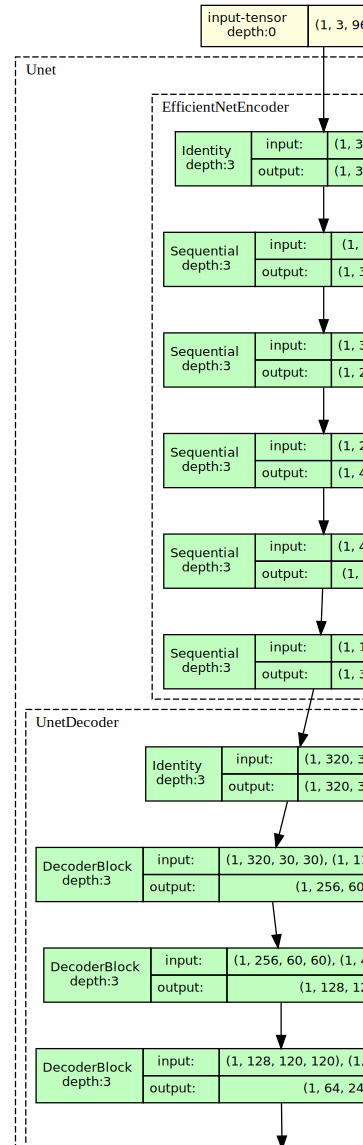

In [ ]:
model_graph = draw_graph(model_fruits, input_size=(1, 3, 960, 960), depth=3, save_graph=True, expand_nested=True,
                         #graph_dir="LR"
                         )
model_graph.visual_graph

In [ ]:
EPOCHS = 50
LR=0.005
optimizer = torch.optim.Adam(model_fruits.parameters(), lr=LR)

In [ ]:
# =================================== Functions to run a epoch of training and validation ====================
from tqdm import tqdm

def compute_metrics(stats, dict_metrics={"accuracy": smp.metrics.functional.accuracy,\
    "iou_score": smp.metrics.functional.iou_score, "f1_score" :smp.metrics.functional.f1_score}, classes_names=["global", "background", "fruit", "edge"], classes_indexes=[-1, 0, 1, 2]):
  """
  Compute some metrics for all the classes and the overall score

  return a dict of metrics:
      {metric_name_class_name: metric_value}
  """
  metrics_keys = dict_metrics.keys()
  metrics_values = {f"{metrics_key}_{class_name}": None for metrics_key in metrics_keys for class_name in classes_names}

  for metric_key in metrics_keys:
    metric_function = dict_metrics[metric_key]
    for i, class_name in zip(classes_indexes, classes_names):
      if class_name == "global":
        global_metric = metric_function(stats[0], stats[1], stats[2], stats[3], reduction="micro")
        metrics_values[f"{metric_key}_{class_name}"] = global_metric.item()
      else:
        by_class_metric = metric_function(stats[0].sum(dim=0), stats[1].sum(dim=0), stats[2].sum(dim=0), stats[3].sum(dim=0), reduction=None)
        metrics_values[f"{metric_key}_{class_name}"] = by_class_metric[i].item()

  return metrics_values

def TrainEpoch(model, train_loader, optimizer):
  """
  model: model to train
  train_loader: training data loader
  optimizer: optimizer to use
  epoch: current epoch
  """
  model.train()
  total_loss = 0
  loop_train = tqdm(train_loader, desc="training")
  for images, masks in loop_train:
    images, masks = images.to(DEVICE), masks.to(DEVICE)

    optimizer.zero_grad()
    loss = model(images, masks)
    loss.backward()   # Calculer les gradients de la fonction coût par rapport au paramètres du modèle
    optimizer.step() # Mettre à jour les paramètres du modèle

    total_loss += (loss.item() / len(train_loader))
    loop_train.set_description(f"Current train loss = {total_loss} ")
  return total_loss


def EvalEpoch(model, val_loader):
  """
  model: model to evaluate
  val_loader: validation data loader

  return: metrics
  """
  model.eval()
  with torch.no_grad():
    loop_eval = tqdm(val_loader, desc="evaluating")
    TP, FP, FN, TN = 0, 0, 0, 0

    i = 0
    for images, masks in loop_eval:
      images, masks = images.to(DEVICE), masks.to(DEVICE)
      stats = model.val(images, masks)
      if i == 0:
        TP = stats[0]
        FP = stats[1]
        FN = stats[2]
        TN = stats[3]
      else:
        TP = torch.cat((TP, stats[0]), dim=0)
        FP = torch.cat((FP, stats[1]), dim=0)
        FN = torch.cat((FN, stats[2]), dim=0)
        TN = torch.cat((TN, stats[3]), dim=0)
      i += 1

    stats = [TP, FP, FN, TN]

    # Compute metrics gobally and for each class : accuracy, f1_score, iou_score
    metrics = compute_metrics(stats)

    accuracy_all = metrics["accuracy_global"]

    f1_score_fruit = metrics["f1_score_fruit"]
    f1_score_all = metrics["f1_score_global"]

    loop_eval.set_description(f"Accuracy = {'{:.2f}'.format(accuracy_all)} \
     F1-score = {'{:.2f}'.format(f1_score_all)}  F1-score_fruits = {'{:.2f}'.format(f1_score_fruit)}")

    return metrics

In [ ]:
model_fruits.load_state_dict(torch.load("/content/drive/MyDrive/MFE/Models/UnetTilling/weights/best.pt", map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [ ]:
os.mkdir("/content/drive/MyDrive/MFE/Models/UnetTilling1/")
os.mkdir("/content/drive/MyDrive/MFE/Models/UnetTilling1/weights")

In [ ]:
"""
Metrics keys are like this : {'accuracy_global', 'accuracy_background', 'accuracy_fruit', 'accuracy_edge', 'iou_score_global'
 'iou_score_background', 'iou_score_fruit', 'iou_score_edge', 'f1_score_global', 'f1_score_background', 'f1_score_fruit', 'f1_score_edge'
 """
save_path = "/content/drive/MyDrive/MFE/Models/UnetTilling1/weights"

with open("/content/drive/MyDrive/MFE/Models/UnetTilling1/results.csv", 'w') as f:
  f.write("epoch,train_loss,accuracy,f1_score\n")
  best_accuracy_all = 0
  for epoch in range(EPOCHS):
    train_loss = TrainEpoch(model_fruits, train_dataset_loader, optimizer)
    metrics = EvalEpoch(model_fruits, val_dataset_loader)

    accuracy_all = metrics["accuracy_global"]
    f1_score_all = metrics["f1_score_global"]

    # -------------- Model evaluation Metrics ------------------
    torch.save(model_fruits.state_dict(), save_path + "/last.pt")
    if epoch == 0:
      best_accuracy_all = accuracy_all
    else:
      if accuracy_all < best_accuracy_all:
        best_accuracy_all = accuracy_all
        torch.save(model_fruits.state_dict(), save_path + "/best.pt")

    f.write(f"{epoch+1},{train_loss},{accuracy_all},{f1_score_all}\n")
    print()


Current train loss = 0.006855928897857666 :   1%|          | 5/650 [51:25<110:04:04, 614.33s/it]

In [ ]:
met_calc = metrics[0]
met_calc

{'accuracy_global': 0.41038066148757935,
 'accuracy_background': 0.12505553662776947,
 'accuracy_fruit': 0.9130309820175171,
 'accuracy_edge': 0.1930554211139679,
 'iou_score_global': 0.061329443007707596,
 'iou_score_background': 0.11159306764602661,
 'iou_score_fruit': 0.009984227828681469,
 'iou_score_edge': 0.005903233774006367,
 'f1_score_global': 0.11557098478078842,
 'f1_score_background': 0.20078042149543762,
 'f1_score_fruit': 0.01977105811238289,
 'f1_score_edge': 0.01173718087375164}

In [ ]:
""""Train and validation functions"""
from tqdm.notebook import tqdm

def train_fn(data_loader, model, optimizer, epoch, n_epoch):
  model.train()
  total_loss=0.0
  loop_train = tqdm(data_loader)
  for images, masks in loop_train:
    images, masks = images.to(DEVICE), masks.to(DEVICE)

    optimizer.zero_grad()
    loss = model(images, masks)
    loss.backward()   # Calculer les gradients de la fonction coût par rapport au paramètres du modèle
    optimizer.step() # Mettre à jour les paramètres du modèle

    total_loss += (loss.item() / len(data_loader))
    loop_train.set_description(f"EPOCH {epoch} / {n_epoch}:             train_loss = {total_loss} ")
  return total_loss


def eval_fn(data_loader, model):
  model.eval()

  with torch.no_grad():
    # images, masks = data_loader.__iter__().__next__()
    loop_eval = tqdm(data_loader, total=len(data_loader))

    TP, FP, FN, TN = 0, 0, 0, 0
    i = 0
    for images, masks in loop_eval:


      images, masks = images.to(DEVICE), masks.to(DEVICE)

      stats = model.val(images, masks)

      true_positives = stats[0]
      false_positives = stats[1]
      false_negatives = stats[2]
      true_negatives = stats[3]

      if i == 0:
        TP = true_positives
        FP = false_positives
        FN = false_negatives
        TN = true_negatives
      else:
        TP = torch.cat((TP, true_positives), dim=0)
        FP = torch.cat((FP, false_positives), dim=0)
        FN = torch.cat((FN, false_negatives), dim=0)
        TN = torch.cat((TN, true_negatives), dim=0)

      i += 1
    final_TP = torch.sum(TP, dim=0)
    final_FP = torch.sum(FP, dim=0)
    final_FN = torch.sum(FN, dim=0)
    final_TN = torch.sum(TN, dim=0)

    overall_TP = torch.sum(final_TP)
    overall_FP = torch.sum(final_FP)
    overall_FN = torch.sum(final_FN)
    overall_TN = torch.sum(final_TN)


    overall_accuracy = smp.metrics.functional.accuracy(overall_TP, overall_FP, overall_FN, overall_TN, reduction=None)

    print("Overall accuracy :", overall_accuracy)

    return overall_accuracy

In [ ]:
# ============== Load the state of a pretrained model =============
# model.load_state_dict(torch.load("/content/drive/MyDrive/Models/model_unet_big.pt"))
if DEVICE == "cuda":
  model_fruits.load_state_dict(torch.load("/content/drive/MyDrive/MFE/Models/UnetTilling/weights/best.pt"))
else:
  model_fruits.load_state_dict(torch.load("/content/drive/MyDrive/MFE/Models/UnetTilling/weights/best.pt", map_location=torch.device('cpu')))

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/MFE/Models/UnetTilling/weights/best.pt'

In [ ]:
save_path = "/content/drive/MyDrive/MFE/Models/ModelFPN/weights"

with open("/content/drive/MyDrive/MFE/Models/ModelFPN/results.csv", 'w') as f:
  f.write("epoch,train_loss,accuracy_all\n")
  best_accuracy_all = 0
  for epoch in range(EPOCHS):
    train_loss = train_fn(train_data_loader, model_fruits, optimizer, epoch + 1, EPOCHS)

    # -------------- Model evaluation Metrics ------------------
    accuracy_all= eval_fn(val_data_loader, model_fruits)
    torch.save(model_fruits.state_dict(), save_path + "/last1.pt")
    if epoch == 0:
      best_accuracy_all = accuracy_all
    else:
      if accuracy_all < best_accuracy_all:
        best_accuracy_all = accuracy_all
        torch.save(model_fruits.state_dict(), save_path + "/best1.pt")

    f.write(f"{epoch+1},{train_loss},{accuracy_all}\n")
    print()


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.
        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.
        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.
        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.
        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.
        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.
        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.
        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.
        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.
        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.
        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.
        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.
        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.
        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.
        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.
        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.
        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

        [2]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


  0%|          | 0/447 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

In [ ]:
import pandas as pd

In [ ]:
file = "/content/drive/MyDrive/MFE/Models/UnetTilling/results.csv"
df = pd.read_csv(file)
df.head()

epoch  train_loss  val_loss
0      1    0.402476  0.379192
1      2    0.334985  0.346583
2      3    0.322041  0.331069
3      4    0.319942  0.329423
4      5    0.314293  0.334646

from matplotlib import pyplot as plt
_df_0['epoch'].plot(kind='hist', bins=20, title='epoch')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['train_loss'].plot(kind='hist', bins=20, title='train_loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['val_loss'].plot(kind='hist', bins=20, title='val_loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='epoch', y='train_loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='train_loss', y='val_loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['train_loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('train_loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['val_loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('val_loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['epoch']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'epoch'}, axis=1)
              .sort_values('epoch', ascending=True))
  xs = counted['epoch']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_8['epoch'].plot(kind='line', figsize=(8, 4), title='epoch')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['train_loss'].plot(kind='line', figsize=(8, 4), title='train_loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['val_loss'].plot(kind='line', figsize=(8, 4), title='val_loss')
plt.gca().spines[['top', 'right']].set_visible(False)

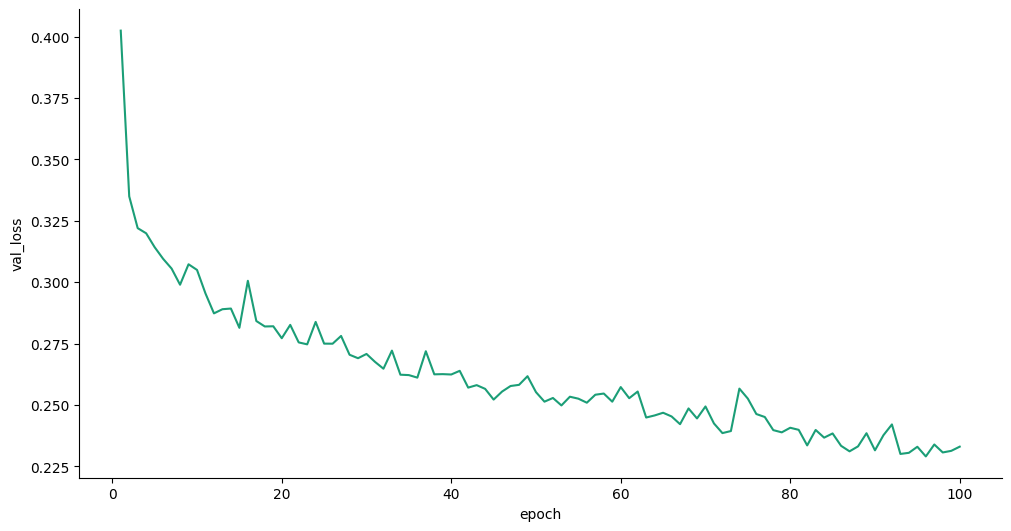

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['train_loss']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('val_loss')

In [ ]:
if not os.path.exists("/content/drive/MyDrive/Models/"):
  os.mkdir("/content/drive/MyDrive/Models/")

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Models/model_unet_big_retrained1.pt")

## Prédire des données

In [ ]:
def preprocess(img, image_size):
  if isinstance(img, str):
    img_arr = img = numpy.asarray(Image.open(img_path))
  else:
    img_arr = img
  img = A.Resize(image_size, image_size)(image=img)["image"]
  img = numpy.transpose(img, (2, 0, 1)).astype(numpy.float32)
  img = torch.Tensor(img)/255.0
  return img

def predict_mask(img, model):
  """
  Predict and returns the result as numpy array of 3 channels (0: background, 1: fruits, 2: edge)
  """
  logits = model(img.to(DEVICE).unsqueeze(0))  # unsqueeze -> (c, h, w) to (1, c, h, w)
  pred_mask = torch.nn.functional.softmax(logits, dim=1)
  array_mask = pred_mask.numpy(force=True) # (1, channel, h, w)
  array_mask = numpy.squeeze(array_mask, axis=0) # (1, channel, h, w) -> (channel, h, w)
  array_mask = numpy.transpose(array_mask, (1, 2, 0)) # (h, w, channel)
  return array_mask

def postprocess(prediction, colormap):
  """
  Transform the 3-channel prediction into one-channel image where each class has its color value
  e.g:
    0: background, 128: fruit, 255: edge
  """
  final_mask = numpy.copy(prediction)
  for channel in colormap:
    final_mask[:,:,channel] = numpy.multiply(prediction[:,:,channel], colormap[channel])

  final_mask = numpy.sum(final_mask, axis=2)

  return final_mask

def get_single_channel(prediction):
  """
  Gets the individual channel corresponding to each class
  """
  background = prediction[:,:,0]
  fruit = prediction[:,:,1]
  edge = prediction[:,:,2]

  return background, fruit, edge

In [ ]:
# ========== Load the model ====================
# torch.load("/content/drive/MyDrive/Models/model_unet_big.pt", map_location=torch.device('cpu'))
# model.load_state_dict(torch.load("/content/drive/MyDrive/Models/model_unet_big.pt"))

<All keys matched successfully>

In [ ]:
os.mkdir("/content/SegmentArg-2/prediction")

In [ ]:
def visualize_images_predictions(liste_images, liste_annotations, colormap={0: 0, 1:128, 2: 255}):
  n_rows = len(liste_images)
  plt.figure(figsize=(30*n_rows, 60), facecolor="gray")

  end_idx = 0
  for i, img_path in enumerate(liste_images):

    my_img = numpy.asarray(Image.open(img_path))
    true_mask = numpy.asarray(Image.open(liste_annotations[i]))

    preprocessed_img = preprocess(img_path, IMAGE_SIZE)
    predicted_mask = predict_mask(preprocessed_img, model)
    final_mask = postprocess(predicted_mask, colormap)

    plt.subplot(n_rows, 3, end_idx+1, xticks=[], yticks=[]);plt.imshow(my_img);plt.title("Image")
    plt.subplot(n_rows, 3, end_idx+2, xticks=[], yticks=[]);plt.imshow(true_mask, cmap="gray");plt.title("Vrai mask")
    plt.subplot(n_rows, 3, end_idx+3, xticks=[], yticks=[]);plt.imshow(final_mask, cmap="gray");plt.title("Mask prédit")

    end_idx += 3

In [ ]:
"""# get five images
data_folder = "/content/fruits-3/valid/"
images, annotations = get_list_data(data_folder)
images, annotations = images[:2], annotations[:2]
visualize_images_predictions(images, annotations)"""

'# get five images\ndata_folder = "/content/fruits-3/valid/"\nimages, annotations = get_list_data(data_folder)\nimages, annotations = images[:2], annotations[:2]\nvisualize_images_predictions(images, annotations)'

## Save predicted masks

In [ ]:
# ====================== Tiling prediction =================================
from skimage.transform import resize
#tiles_masks_predicted = []
def predict_tile_mask(tile):
  color_map = {0: 0, 1:128, 2: 255}
  preprocessed_img = preprocess(tile, IMAGE_SIZE)
  predicted_mask = predict_mask(preprocessed_img, model_fruits)
  rescal = resize(predicted_mask, (tile.shape[0], tile.shape[1]),anti_aliasing=True)
  final_mask = postprocess(rescal, color_map)
  fruit = (numpy.argmax(rescal, axis=2) == 1).astype(numpy.int8)

  return fruit

In [ ]:
img_2_path = "/content/SegmentArg-2/train/images/BIG_11_CadreFruitEst_ArbreEch_2_V1_2022-03-26_jpg.rf.2b0850e3b1bd663a6e9e5411f95d082c.jpg"
img2 = skimage.io.imread(img_2_path)

# Prediction without tiling
prediction2 = predict_tile_mask(img2)

# Prediction with tiling
n_rows = 2
n_cols = 2
liste_tiles_img2 = tile_image(img_2_path, n_rows, n_cols)

predictions = []

for tile in liste_tiles_img2:
  predictions.append(predict_tile_mask(tile))
prediction_tiled = concat_tiles(predictions, n_rows, n_cols)

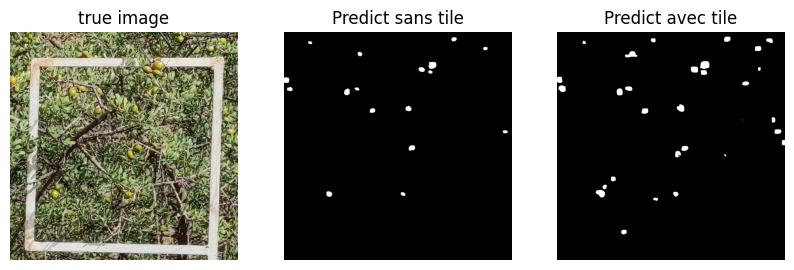

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 10))
images = [img2, prediction2, prediction_tiled]
titles = ["true image", "Predict sans tile", "Predict avec tile"]

i = 0
for ax, title, img in zip(axes, titles, images):
  if i == 0:
    ax.imshow(img)
  else:
    ax.imshow(img, cmap="gray")
  ax.set_title(title)
  ax.axis("off")

  i += 1

In [ ]:
def getNumberObjects_from_mask(mask):
  contours = find_contours(mask)
  return len(contours)

def getTrueFruitsNumber(image_label_path):
  """
  Récupérer le nombre réel de fruits d'une image à partir de son fichier
       d'annotation

  input:
      image_label_path: chemin du fichier annoté correspondant à l'image donnée

  return:
      n_fruits: nombre de fruits trouvés dans l'image
  """
  import os
  if os.path.exists(image_label_path):
    n_fruits = 0
    with open(image_label_path, "r") as file:
      file_content = file.readlines()
      n_fruits = len(file_content)
      return n_fruits
  else:
    return 0

def predict_tile_mask(tile, model=model_fruits):
  color_map = {0: 0, 1:128, 2: 255}
  preprocessed_img = preprocess(tile, IMAGE_SIZE)
  predicted_mask = predict_mask(preprocessed_img, model)
  rescal = resize(predicted_mask, (tile.shape[0], tile.shape[1]),anti_aliasing=True)
  final_mask = postprocess(rescal, color_map)
  fruit = (numpy.argmax(rescal, axis=2) == 1).astype(numpy.int8)

  return fruit

In [ ]:
#save_path = "/content/drive/MyDrive/MFE/Models/UnetTilling"
save_path = "/content/drive/MyDrive/MFE/Models/ModelFPN"
val_image = "/content/SegmentArg-3/content/SegmentArg-3/valid/images"
val_labels = "/content/SegmentArg-3/content/SegmentArg-3/valid/labels"
from skimage.transform import resize

with open(os.path.join(save_path, "predictions_nombre_tile_2_by_2_new_data.csv"), "w+") as file:
  file.writelines(["image,true_number,number_with_tiling,number_without_tiling\n"])
  list_images = glob.glob(os.path.join(val_image, "*.jpg"))
  loop = tqdm(list_images, total=len(list_images), desc="Prediction des masks ...")
  for image in loop:
    img_array = skimage.io.imread(image)

    # Prediction sans tuilage
    prediction_sans_tuilage = predict_tile_mask(img_array)

    # Prediction with tiling
    n_rows = 3
    n_cols = 3
    liste_tiles_img2 = tile_image(image, n_rows, n_cols)

    predictions = []

    for tile in liste_tiles_img2:
      predictions.append(predict_tile_mask(tile))
    prediction_avec_tuilage = concat_tiles(predictions, n_rows, n_cols)

    label_path = os.path.join(val_labels, image.split("/")[-1][:-4]+".txt")
    n_fruit_reel = getTrueFruitsNumber(label_path)
    n_fruit_sans_tuilage = getNumberObjects_from_mask(prediction_sans_tuilage)
    n_fruits_avec_tuilage = getNumberObjects_from_mask(prediction_avec_tuilage)

    file.writelines([f"{image.split('/')[-1][:-4].split('.')[0]},{n_fruit_reel},{n_fruits_avec_tuilage},{n_fruit_sans_tuilage}\n"])

Prediction des masks ...: 100%|██████████| 246/246 [04:01<00:00,  1.02it/s]


In [ ]:
import shutil

In [ ]:
shutil.copy(os.path.join(save_path, "predictions_nombre_tile_2_by_2.csv"), "/content/drive/MyDrive/MFE/Models/UnetTilling")

'/content/drive/MyDrive/MFE/Models/UnetTilling/predictions_nombre_tile_2_by_2.csv'

In [ ]:
import pandas as pd

In [ ]:
# =========== Voir le fichier csv ===================

# ------------------------------------- Image resized is 640 -----------------------------------------
file_1 = "/content/drive/MyDrive/MFE/Models/UnetTilling/predictions_nombre_tile_2_by_2_new_data.csv"
file_2 = "/content/drive/MyDrive/MFE/Models/UnetTilling/predictions_nombre_tile_3_by_3_new_data.csv"
file_3 = "/content/drive/MyDrive/MFE/Models/UnetTilling/predictions_nombre_tile_2_by_2.csv"
file_4 = "/content/drive/MyDrive/MFE/Models/UnetTilling/predictions_nombre_tile_3_by_3.csv"

df_val = pd.read_csv(file_4)

In [ ]:
df_val.head()

image  true_number  \
0  SAA_25_CadreFruitOuest_ArbreEch_1_V1_2022-03-3...           16   
1   LQL_3_CadreFruitEst_ArbreEch_2_V1_2022-03-21_jpg            9   
2  BOU_1_CadreFruitOuest_ArbreEch_3_V1_2022-03-31...            1   
3  BOU_29_CadreFruitOuest_ArbreEch_1_V1_2022-04-0...           28   
4   BOU_6_CadreFruitEst_ArbreEch_3_V1_2022-04-02_jpg            3   

   number_with_tiling  number_without_tiling  
0                  12                      9  
1                   7                      5  
2                   2                      1  
3                  26                      1  
4                   5                      3

Text(0.5, 1.0, 'Nuage de points - sans tuilage')

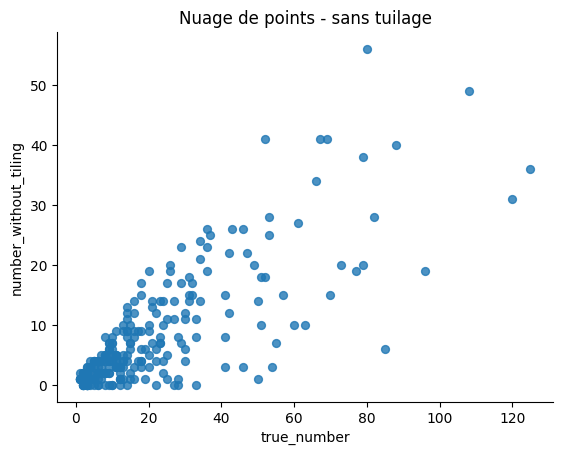

In [ ]:
from matplotlib import pyplot as plt
df_val.plot(kind='scatter', x='true_number', y='number_without_tiling', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title("Nuage de points - sans tuilage")

Text(0.5, 1.0, 'Nuage de points - avec tuilage')

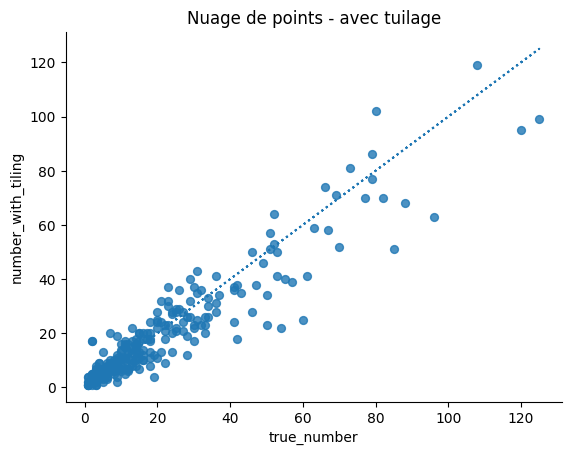

In [ ]:
from matplotlib import pyplot as plt
df_val.plot(kind='scatter', x='true_number', y='number_with_tiling', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.plot(df_val['true_number'], df_val['true_number'], linestyle = 'dotted')
plt.title("Nuage de points - avec tuilage")

In [ ]:
new_data_frame = pd.DataFrame(df_val, columns=["true_number",	"number_with_tiling"])
new_data_frame["abs_error"] = abs(new_data_frame["true_number"] - new_data_frame["number_with_tiling"])
new_data_frame.sort_values(by="true_number", ascending=True, inplace=True)
new_data_frame.head()

true_number  number_with_tiling  abs_error
2              1                   2          1
149            1                   1          0
130            1                   2          1
21             1                   1          0
84             1                   1          0

In [ ]:
from sklearn.metrics import mean_absolute_error

mae_tilling = mean_absolute_error(df_val["number_with_tiling"], df_val["true_number"])
mae_no_tilling = mean_absolute_error(df_val["number_without_tiling"], df_val["true_number"])

print("MAE sans tuilage :", mae_no_tilling)
print("MAE avec tuilage :", mae_tilling)

# Voir la corrélation : true_number,number_with_tiling,number_without_tiling
coor_sans_tuilage = df_val["true_number"].corr(df_val["number_without_tiling"])
coor_avec_tuilage = df_val["true_number"].corr(df_val["number_with_tiling"])

print("Corrélation sans tuilage :", coor_sans_tuilage)
print("Corrélation avec tuilage :", coor_avec_tuilage)

MAE sans tuilage : 13.248
MAE avec tuilage : 5.324
Corrélation sans tuilage : 0.7845321990866013
Corrélation avec tuilage : 0.9333891583312984


In [ ]:
img_label_path = "/content/SegmentArg-2/train/labels/BIG_11_CadreFruitEst_ArbreEch_2_V1_2022-03-26_jpg.rf.2b0850e3b1bd663a6e9e5411f95d082c.txt"
n_tuilage = getNumberObjects_from_mask(prediction_tiled)
n_sans_tuilage = getNumberObjects_from_mask(prediction2)
n_reel = getTrueFruitsNumber(img_label_path)

print("Nombre réel :", n_reel)
print("Nombre predit - tuilage :", n_tuilage)
print("Nombre predit sans tuilage :", n_sans_tuilage)

Nombre réel : 34
Nombre predit - tuilage : 29
Nombre predit sans tuilage : 11


(-0.5, 1079.5, 1079.5, -0.5)

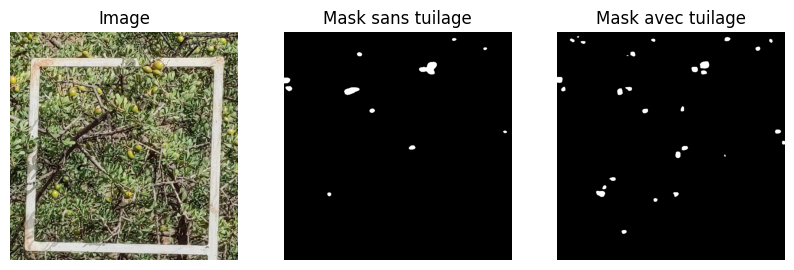

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))

ax1.set_title("Image")
ax1.imshow(img2)
ax1.axis('off')
ax2.set_title("Mask sans tuilage")
ax2.imshow(prediction2, cmap="gray")
ax2.axis('off')
ax3.set_title("Mask avec tuilage")
ax3.imshow(prediction_tiled, cmap="gray")
ax3.axis('off')

## Convert masks to bounding boxes

In [ ]:
# Récupérer le nombre de fruits pour une image donnée

def getTrueFruitsNumber(image_label_path):
  """
  Récupérer le nombre réel de fruits d'une image à partir de son fichier
       d'annotation

  input:
      image_label_path: chemin du fichier annoté correspondant à l'image donnée

  return:
      n_fruits: nombre de fruits trouvés dans l'image
  """
  import os
  if os.path.exists(image_label_path):
    n_fruits = 0
    with open(image_label_path, "r") as file:
      file_content = file.readlines()
      n_fruits = len(file_content)
      return n_fruits
  else:
    return 0

def getNumberObjects_from_mask(mask):
  contours = find_contours(mask, 100)
  return len(contours)

def fruits_number_toCSV(predicted_folder, annotations_folder, path_to_save):
  import csv
  with open(path_to_save, "w", newline="") as f:
    my_writer = csv.writer(f)
    my_writer.writerow(["image", "nombre_predit", "nombre_reel"])
    images_paths = glob.glob(os.path.join(predicted_folder, "*.png"))
    loop_write = tqdm(images_paths)
    for img_name in loop_write:
      image_name_sans_extension = img_name.split("/")[-1][:-4]
      loop_write.set_description(f"Processing for ::: {image_name_sans_extension.split('.')[0]}")
      label_path = os.path.join(annotations_folder, image_name_sans_extension + ".txt")


      mask = numpy.asarray(Image.open(img_name))
      pred_number = getNumberObjects_from_mask(mask)
      true_number = getTrueFruitsNumber(label_path)

      row_to_write = [image_name_sans_extension.split(".")[0][:-4]+".jpg", pred_number, true_number]
      my_writer.writerow(row_to_write)

In [ ]:
# ================ Save numbers in csv file =======================
csv_val_path = "/content/drive/MyDrive/Models/numberFruitsValidation_good_mrt.csv"
csv_train_path = "/content/drive/MyDrive/Models/numberFruitstrain_good.csv"
pred_folder = "/content/SegmentArg-2/prediction"
train_pred_folder = "/content/SegmentArg-2/prediction_train"
annots_folder = "/content/SegmentArg-2/valid/labels"
train_annot_folder = "/content/SegmentArg-2/train/labels"
fruits_number_toCSV(pred_folder, annots_folder, csv_val_path )

Processing for ::: BIG_35_CadreFruitEst_ArbreEch_3_V1_2022-03-28_jpg: 100%|██████████| 250/250 [00:06<00:00, 40.40it/s]


In [ ]:
import pandas as pd

In [ ]:
df_val = pd.read_csv(csv_val_path)

In [ ]:
df_val.head()

image  nombre_predit  \
0   TAF_1_CadreFruitSud_ArbreEch_1_V1_2022-03-27.jpg             46   
1  SAA_31_CadreFruitOuest_ArbreEch_1_V1_2022-03-3...             35   
2  LQL_4_CadreFruitNord_ArbreEch_3_V1_2022-03-22.jpg              6   
3  BOU_5_CadreFruitNord_ArbreEch_1_V1_2022-04-01.jpg             20   
4  DRA_33_CadreFruitSud_ArbreEch_2_V1_2022-03-18.jpg              4   

   nombre_reel  
0           52  
1           46  
2           11  
3           30  
4            5

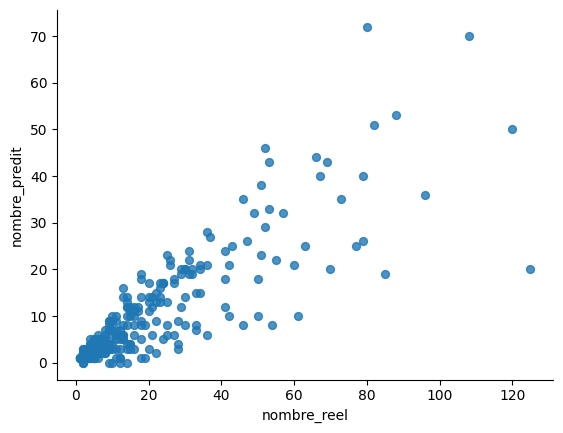

In [ ]:
# @title nombre_predit vs nombre_reel

from matplotlib import pyplot as plt
df_val.plot(kind='scatter', x='nombre_reel', y='nombre_predit', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df_val["nombre_reel"].corr(df_val["nombre_predit"])

0.8383833312737844

## Other stuff

Mounted at /content/drive


# Segmentation Frame

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="zo0Wg6dezQz5Cy8SwFm0")
project = rf.workspace("mesmodels").project("framedetection-tjodz")
version = project.version(11)
dataset = version.download("yolov8")

Dependency ultralytics==8.0.196 is required but found version=8.1.34, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to Framedetection-11 in yolov8:: 100%|██████████| 1870/1870 [00:00<00:00, 2751.89it/s]


In [ ]:
import shutil
shutil.rmtree("/content/Framedetection-10")

## Helper functions

In [ ]:
def get_polygons(path_to_label_file, image_path):
  """
  Permet de récupérer les polygones présents dans un fichier donnée:
   return:
   polygones: [[(x, y), (x, y), (x, y)], ...]
  """
  if os.path.exists(path_to_label_file):
    with open(path_to_label_file) as file:
      content = file.readlines()
      if len(content) > 0:
        polygones = []
        imArray = numpy.asarray(Image.open(image_path).convert("RGBA"))
        width, height = imArray.shape[0], imArray.shape[1]
        for e in content:
          pol = [float(i) for i in e.split(" ")[1:]]
          pol = [(int(pol[j]*width), int(pol[j+1]*height)) for j in range(0, len(pol), 2)]
          polygones.append(pol)

        return polygones


# create a mask image
# Colors:  #808080 (gray) value stored is 128| #ffffff (white) value stored is 255 {128: 1, 255: 2}
# black : value stored is 0
def create_img_mask(img_path, polygones_path, background_color="#000000", fill_color="#808080", outline_color="#ffffff", outline_width=3):
  """
  Créer un mask d'image à partir d'une image et des ses annotations en polygone

  img_path : chemin de l'image
  polygones_path: chemin des polygones de l'image
  background_color: the background color of the image
  fill_color: couleur de remplissage du polygone
  outline_color: couleur de la ligne de contour du polygone
  outline_width: epaisseur de la ligne de contour
  """

  # Récupération des polygones correspondant à l'image
  data_polygones = get_polygons(polygones_path, img_path)

  # Convertire l'image en numpy_array
  imArray = numpy.asarray(Image.open(img_path).convert("RGBA"))

  # Création du masque:
  # mode=L (8-bit pixels, grayscale)
  maskImage = Image.new(mode='L', size=(imArray.shape[1], imArray.shape[0]), color=background_color)
  for pol in data_polygones: # Dessiner chaque polygone sur l'image
    ImageDraw.Draw(maskImage).polygon(pol, outline=outline_color, fill=fill_color, width=outline_width)
    ImageDraw.Draw(maskImage).polygon(pol, outline=outline_color, fill=fill_color, width=outline_width)

  return maskImage

def createMasksAnnotations(data_folder, background_color="#000000", fill_color="#808080", outline_color="#ffffff", outline_width=0):
  """
  Créér et sauvegarder les masks d'annotation des différents images
  data_folder: le chemin des données (Assume que c'est l'arborescence de YOLO)
  """

  images = glob.glob(os.path.join(data_folder, "images")+"/*.jpg")
  annotations = glob.glob(os.path.join(data_folder, "labels")+"/*.txt")
  if len(images) > 0 and len(annotations) > 0:
    if not os.path.exists(os.path.join(data_folder, "labels_masks")):
      # Créér un sous dossier pour sauvegarder les masks
      os.mkdir(os.path.join(data_folder, "labels_masks"))

    loop = tqdm(enumerate(images), total=len(images))
    for idx, image_path in loop:

      # loop.set_description(f"Image [{idx} / {len(images)}]")

      image_name_sans_extension = image_path.split("/")[-1][:-4]
      label_path = os.path.join(data_folder, f"labels/{image_name_sans_extension}.txt")

      # Si l'image a une annotation et que cette annotation n'est pas vide
      if label_path in annotations and get_polygons(label_path, image_path):
        path_to_save = os.path.join(data_folder, f"labels_masks/{image_name_sans_extension}.png")
        mask_pil_image = create_img_mask(image_path, label_path, background_color, fill_color, outline_color, outline_width)
        mask_pil_image .save(path_to_save)
        loop.set_postfix(processing_for = f"{image_name_sans_extension}")
      else:
        loop.set_postfix(skip_for = f"{image_name_sans_extension}")


## Load data

In [ ]:
# ===================  Création des masks pour les différentes images ===================
valid_data_folder = "/content/Framedetection-11/train"
train_data_folder = "/content/Framedetection-11/valid"

createMasksAnnotations(train_data_folder, fill_color="#ffffff", outline_width=0)
createMasksAnnotations(valid_data_folder, fill_color="#ffffff", outline_width=0)

100%|██████████| 681/681 [00:39<00:00, 17.39it/s, processing_for=SAA_4_CadreFruitNord_ArbreEch_3_V1_2022-03-31_jpg.rf.239d3f0cd7b6fcd3d56300461224aab9]


## Dataset preparation

In [ ]:
# Batch size and the image size(target image size)
BATCH_SIZE = 16
IMAGE_SIZE = 640 # 224   1120  640

"""Data Aumentation"""
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE)
      # A.HorizontalFlip(p=0.5)
      # A.VerticalFlip(p=0.5)
      ])

def get_val_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE)
      ])


"""CUSTOM DATASET"""
class SegmentationDataset(Dataset):

  def __init__(self, liste_images, liste_annotations, mapping_label={0: 0, 255: 1}, augmentations=None, classes_pixels_values=[0, 128, 255]):
    """
    liste_images: liste des chemins absolus vers les images
    liste_annotations; liste des chemins absolus vers les annotations
    classes_pixels_values: valeurs de pixels correspondant aux différentes classes. 0 -> background | 128: fruit | 255: contour

    """
    self.liste_images = liste_images
    self.liste_annotations = liste_annotations
    self.mapping = mapping_label
    self.classes_pixels_values = classes_pixels_values
    self.augmentations = augmentations

  def __len__(self):
    return len(self.liste_images)

  def mask_to_class_f(self, mask):
    """
    Replaces each pixel with its class index.
    e.g: 0 by 0, 255 by 1
    """
    masque = numpy.copy(mask)
    for k in self.mapping:
        masque[mask==k] = self.mapping[k]
    return masque.astype(dtype=numpy.int8)

  def __getitem__(self, index):
    image_array = numpy.asarray(Image.open(self.liste_images[index]))
    f_label_array = numpy.asarray(Image.open(self.liste_annotations[index]))
    label_array = numpy.copy(f_label_array)

    # One hot coding of the classes within the mask
    #label_array = process_mask(label_array, self.classes_pixels_values)
    #label_array = numpy.expand_dims(label_array, axis=-1)
    label_array = self.mask_to_class_f(label_array)

    if self.augmentations:
      data = self.augmentations(image=image_array, mask=label_array)
      image_array, label_array = data["image"], data["mask"]

    # Transpose to change the dimensions : (height, width, channels) -> (channels, height, width)
    image_array = numpy.transpose(image_array, (2, 0, 1)).astype(numpy.float32)
    #label_array = numpy.transpose(label_array, (2, 0, 1)).astype(numpy.int64)

    image_array = torch.Tensor(image_array)/255.0
    label_array = torch.Tensor(label_array).long()

    return image_array, label_array


def get_list_data(images_folder, labels_folder):
  """
  Récupère la liste des images ainsi que leur annotations à partir d'un dossier
  le dossier doit avoir deux sous dossiers: images et labels_masks
  """

  images_paths = glob.glob(os.path.join(images_folder, "*.jpg"))
  labels_paths = glob.glob(os.path.join(labels_folder, "*.png"))

  liste_images = []
  liste_annotations = []
  for img_path in images_paths:
    label_path = os.path.join(labels_folder, img_path.split("/")[-1][:-4]+".png")
    if label_path in labels_paths:
      liste_images.append(img_path)
      liste_annotations.append(label_path)

  return liste_images, liste_annotations




In [ ]:
# Chargement du dataset
# ======================== Datasets for training and validation ==================================
list_img_train, list_label_train = get_list_data(images_folder="/content/Framedetection-11/train/images", labels_folder="/content/Framedetection-11/train/labels_masks")
list_img_val, list_label_val = get_list_data(images_folder="/content/Framedetection-11/valid/images", labels_folder="/content/Framedetection-11/valid/labels_masks")
train_dataset = SegmentationDataset(list_img_train, list_label_train, augmentations=get_train_augs())
val_dataset = SegmentationDataset(list_img_val, list_label_val, augmentations=get_val_augs())

In [ ]:
# ================== Making data loader for train and val ====================================
BATCH_SIZE = 16
train_data_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_data_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)

print("Nombre de batch dans train_loader :", len(train_data_loader))
print("Nombre de batch dans val_loader :", len(val_data_loader))

Nombre de batch dans train_loader : 42
Nombre de batch dans val_loader : 16


## Model

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
ENCODER = "timm-efficientnet-b0"
WEIGHTS = "imagenet"
NUM_CLASSES = 1 # 0 : background, 1: Fruit, 2: Edge

In [ ]:
"""   Construction du modèle Unet   """
class UnetModelFrame(nn.Module):
  def __init__(self, in_channels=3, num_classes=1, encoder=ENCODER, activation="sigmoid"):
    super(UnetModelFrame, self).__init__()
    self.encoder = encoder
    self.activation = activation
    self.num_classes = num_classes

    self.model = smp.Unet(
        encoder_name=self.encoder, encoder_weights="imagenet",
        in_channels=in_channels, classes=self.num_classes, activation=self.activation
    )

  def forward(self, images, masks=None):
    """
    Différents modes :
      train : dans ce cas on retourne
    """
    logits = self.model(images)
    if masks != None:
      dice_loss = smp.losses.DiceLoss(mode="binary", from_logits=False)(logits, masks)

      return dice_loss

  def predict(self, images):
    """
    Prédiction sur les images : une ou plusieurs images
    """
    self.model.eval()
    prediction = self.model(images)

    prediction = (prediction >= 0.5).long()

    # prediction = torch.nn.functional.threshold(input=prediction, threshold=0.5, value=1, inplace=False)

    return prediction

  def val(self, images, masks=None):
    """
    Validation du modèle : prends les images et les masks et retourne
    les métriques telles que Accuracy, Precision, Recall et F1-score pour chaque classe
    """
    predictions = self.model(images)
    if masks != None:
      masks = torch.unsqueeze(masks, dim=1)
      stats = smp.metrics.get_stats(predictions, masks, mode="binary", threshold=0.5)

      return stats

In [ ]:
model_frame = UnetModelFrame(in_channels=3, num_classes=1, encoder=ENCODER, activation="sigmoid")
model_frame.to(DEVICE)

UnetModelFrame(
  (model): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            

## Model training

In [ ]:
""""Train and validation functions"""
from tqdm import tqdm

def train_fn(data_loader, model, optimizer, epoch, n_epoch):
  model.train()
  total_loss=0.0
  loop_train = tqdm(data_loader)
  for images, masks in loop_train:
    images, masks = images.to(DEVICE), masks.to(DEVICE)

    optimizer.zero_grad()
    loss = model(images, masks)
    loss.backward()   # Calculer les gradients de la fonction coût par rapport au paramètres du modèle
    optimizer.step() # Mettre à jour les paramètres du modèle

    total_loss += (loss.item() / len(data_loader))
    loop_train.set_description(f"EPOCH {epoch} / {n_epoch}:             train_loss = {total_loss} ")
  return total_loss


def eval_fn(data_loader, model):
  model.eval()

  with torch.no_grad():


    TP, FP, FN, TN = 0, 0, 0, 0
    i = 0

    loop_eval = tqdm(data_loader)
    for images, masks in loop_eval:
      loop_eval.set_description("Validating and computing metrics ...")
      images, masks = images.to(DEVICE), masks.to(DEVICE)
      stats = model.val(images, masks)

      true_positives = stats[0]
      false_positives = stats[1]
      false_negatives = stats[2]
      true_negatives = stats[3]
      if i == 0:
        TP = true_positives
        FP = false_positives
        FN = false_negatives
        TN = true_negatives
      else:
        TP = torch.cat((TP, true_positives), dim=0)
        FP = torch.cat((FP, false_positives), dim=0)
        FN = torch.cat((FN, false_negatives), dim=0)
        TN = torch.cat((TN, true_negatives), dim=0)
      i += 1

    final_TP = torch.sum(TP, dim=0)
    final_FP = torch.sum(FP, dim=0)
    final_FN = torch.sum(FN, dim=0)
    final_TN = torch.sum(TN, dim=0)

    overall_TP = torch.sum(final_TP)
    overall_FP = torch.sum(final_FP)
    overall_FN = torch.sum(final_FN)
    overall_TN = torch.sum(final_TN)

    # ========== Compute metrics like accuracy, precision, recall and f1_score =========
    overall_accuracy = smp.metrics.functional.accuracy(overall_TP, overall_FP, overall_FN, overall_TN, reduction=None)
    overall_precision = smp.metrics.functional.precision(overall_TP, overall_FP, overall_FN, overall_TN, reduction=None)
    overall_recall = smp.metrics.functional.recall(overall_TP, overall_FP, overall_FN, overall_TN, reduction=None)
    overall_f1_score = smp.metrics.functional.f1_score(overall_TP, overall_FP, overall_FN, overall_TN, reduction=None)

    return overall_accuracy.item(), overall_precision.item(), overall_recall.item(), overall_f1_score.item()

In [ ]:
# ===== LOAD the model ====
model.load_state_dict(torch.load("/content/drive/MyDrive/MFE/Models/UnetFrameSegmentation/weights/last.pt"))

In [ ]:
path_to_save = "/content/drive/MyDrive/MFE/Models/UnetFrameSegmentation1"
if not os.path.exists(path_to_save):
  os.mkdir(path_to_save)

if not os.path.exists(path_to_save + "/weights"):
  os.mkdir(path_to_save + "/weights")

In [ ]:
EPOCHS = 50
LR=0.005
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:

results_csv = "/content/drive/MyDrive/MFE/Models/UnetFrameSegmentation1/results.csv"
save_path = "/content/drive/MyDrive/MFE/Models/UnetFrameSegmentation1/weights"
with open(results_csv, 'w') as f:
  f.write("epoch,train_loss,accuracy_all,precision_all,recall_all,f1_score_all\n")
  best_f1_score_all = 0
  for epoch in range(EPOCHS):
    train_loss = train_fn(train_data_loader, model, optimizer, epoch + 1, EPOCHS)

    # -------------- Model evaluation Metrics ------------------
    (accuracy_all, precision_all, recall_all, f1_score_all) = eval_fn(val_data_loader, model)
    torch.save(model.state_dict(), save_path + "/last.pt")
    if epoch == 0:
      best_f1_score_all = f1_score_all
    else:
      if f1_score_all < best_f1_score_all:
        best_f1_score_all = f1_score_all
        torch.save(model.state_dict(), save_path + "/best.pt")
    metrics = f"{accuracy_all},{precision_all},{recall_all},{f1_score_all}"

    f.write(f"{epoch+1},{train_loss}, {metrics}\n")

    print(f"Accuracy : {'{:.2f}'.format(accuracy_all)}\nPrecision : {'{:.2f}'.format(precision_all)}\nRecall : {'{:.2f}'.format(recall_all)}\nF1-score : {'{:.2f}'.format(f1_score_all)}")
    print()


EPOCH 1 / 50:             train_loss = 0.007921251512709119 : 100%|██████████| 42/42 [00:23<00:00,  1.75it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:05<00:00,  3.18it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 2 / 50:             train_loss = 0.007552329983030047 : 100%|██████████| 42/42 [00:23<00:00,  1.77it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.37it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 3 / 50:             train_loss = 0.00727917750676473 : 100%|██████████| 42/42 [00:23<00:00,  1.76it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.28it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 4 / 50:             train_loss = 0.007367134094238285 : 100%|██████████| 42/42 [00:23<00:00,  1.77it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.22it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 5 / 50:             train_loss = 0.007835169633229572 : 100%|██████████| 42/42 [00:23<00:00,  1.76it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.35it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.98
F1-score : 0.99



EPOCH 6 / 50:             train_loss = 0.007962628489448913 : 100%|██████████| 42/42 [00:23<00:00,  1.76it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.29it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 7 / 50:             train_loss = 0.008965065081914265 : 100%|██████████| 42/42 [00:23<00:00,  1.77it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.35it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 8 / 50:             train_loss = 0.007848925533748809 : 100%|██████████| 42/42 [00:23<00:00,  1.76it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.23it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.98
F1-score : 0.99



EPOCH 9 / 50:             train_loss = 0.008252766870317006 : 100%|██████████| 42/42 [00:23<00:00,  1.76it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.29it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 10 / 50:             train_loss = 0.007994285651615687 : 100%|██████████| 42/42 [00:23<00:00,  1.77it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.22it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 11 / 50:             train_loss = 0.007511685291926065 : 100%|██████████| 42/42 [00:23<00:00,  1.76it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.26it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.98
F1-score : 0.99



EPOCH 12 / 50:             train_loss = 0.00726454598563058 : 100%|██████████| 42/42 [00:23<00:00,  1.77it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.29it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 13 / 50:             train_loss = 0.0074608084701356416 : 100%|██████████| 42/42 [00:23<00:00,  1.77it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.33it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 14 / 50:             train_loss = 0.007030471449806576 : 100%|██████████| 42/42 [00:23<00:00,  1.77it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.33it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 15 / 50:             train_loss = 0.007104324442999702 : 100%|██████████| 42/42 [00:23<00:00,  1.77it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.30it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 16 / 50:             train_loss = 0.007314686264310564 : 100%|██████████| 42/42 [00:23<00:00,  1.77it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.29it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 17 / 50:             train_loss = 0.0069468943845658075 : 100%|██████████| 42/42 [00:23<00:00,  1.76it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.29it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 18 / 50:             train_loss = 0.006921453135354178 : 100%|██████████| 42/42 [00:23<00:00,  1.77it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.38it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 19 / 50:             train_loss = 0.00683689968926566 : 100%|██████████| 42/42 [00:23<00:00,  1.76it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.24it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 20 / 50:             train_loss = 0.006866822640101113 : 100%|██████████| 42/42 [00:23<00:00,  1.78it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.33it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 21 / 50:             train_loss = 0.006791937918890092 : 100%|██████████| 42/42 [00:23<00:00,  1.77it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.24it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 22 / 50:             train_loss = 0.010511134352002825 : 100%|██████████| 42/42 [00:23<00:00,  1.75it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.36it/s]


Accuracy : 0.96
Precision : 0.97
Recall : 0.96
F1-score : 0.97



EPOCH 23 / 50:             train_loss = 0.013397690795716784 : 100%|██████████| 42/42 [00:23<00:00,  1.77it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.26it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.98
F1-score : 0.99



EPOCH 24 / 50:             train_loss = 0.012237382786614553 : 100%|██████████| 42/42 [00:23<00:00,  1.76it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.33it/s]


Accuracy : 0.98
Precision : 0.98
Recall : 0.99
F1-score : 0.98



EPOCH 25 / 50:             train_loss = 0.009693042153403874 : 100%|██████████| 42/42 [00:23<00:00,  1.76it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.28it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.98
F1-score : 0.98



EPOCH 26 / 50:             train_loss = 0.007775610401516868 : 100%|██████████| 42/42 [00:23<00:00,  1.77it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.32it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 27 / 50:             train_loss = 0.008004926499866305 : 100%|██████████| 42/42 [00:23<00:00,  1.78it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.39it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 28 / 50:             train_loss = 0.00756995167051043 : 100%|██████████| 42/42 [00:23<00:00,  1.78it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.29it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 29 / 50:             train_loss = 0.007007235572451637 : 100%|██████████| 42/42 [00:23<00:00,  1.78it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.36it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 30 / 50:             train_loss = 0.007200601555052258 : 100%|██████████| 42/42 [00:23<00:00,  1.78it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.30it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 31 / 50:             train_loss = 0.007013621784391858 : 100%|██████████| 42/42 [00:23<00:00,  1.77it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.32it/s]


Accuracy : 0.99
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 32 / 50:             train_loss = 0.007245884055183047 : 100%|██████████| 42/42 [00:23<00:00,  1.76it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.25it/s]


Accuracy : 0.99
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 33 / 50:             train_loss = 0.007149368524551392 : 100%|██████████| 42/42 [00:23<00:00,  1.77it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.29it/s]


Accuracy : 0.99
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 34 / 50:             train_loss = 0.008870397295270647 : 100%|██████████| 42/42 [00:23<00:00,  1.77it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.27it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 35 / 50:             train_loss = 0.008395131145204817 : 100%|██████████| 42/42 [00:23<00:00,  1.77it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.30it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 36 / 50:             train_loss = 0.007052397444134668 : 100%|██████████| 42/42 [00:23<00:00,  1.76it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.31it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 37 / 50:             train_loss = 0.007336017631349109 : 100%|██████████| 42/42 [00:23<00:00,  1.75it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.24it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 38 / 50:             train_loss = 0.00680237440835862 : 100%|██████████| 42/42 [00:23<00:00,  1.76it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.26it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 39 / 50:             train_loss = 0.006941548415592739 : 100%|██████████| 42/42 [00:23<00:00,  1.76it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.25it/s]


Accuracy : 0.99
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 40 / 50:             train_loss = 0.006573379039764404 : 100%|██████████| 42/42 [00:23<00:00,  1.76it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.31it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 41 / 50:             train_loss = 0.006454846688679286 : 100%|██████████| 42/42 [00:23<00:00,  1.77it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.29it/s]


Accuracy : 0.99
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 42 / 50:             train_loss = 0.006594017857596988 : 100%|██████████| 42/42 [00:23<00:00,  1.76it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.32it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 43 / 50:             train_loss = 0.006424601588930402 : 100%|██████████| 42/42 [00:23<00:00,  1.76it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.30it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 44 / 50:             train_loss = 0.00638479845864432 : 100%|██████████| 42/42 [00:23<00:00,  1.76it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.26it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.30it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 46 / 50:             train_loss = 0.006202665113267445 : 100%|██████████| 42/42 [00:23<00:00,  1.76it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.24it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 47 / 50:             train_loss = 0.006237951062974477 : 100%|██████████| 42/42 [00:23<00:00,  1.76it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.37it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



EPOCH 48 / 50:             train_loss = 0.006684496289207824 : 100%|██████████| 42/42 [00:23<00:00,  1.77it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.30it/s]


Accuracy : 0.97
Precision : 0.98
Recall : 0.97
F1-score : 0.98



EPOCH 49 / 50:             train_loss = 0.010121666249774751 : 100%|██████████| 42/42 [00:23<00:00,  1.76it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.29it/s]


Accuracy : 0.97
Precision : 0.97
Recall : 0.99
F1-score : 0.98



EPOCH 50 / 50:             train_loss = 0.008419347660882131 : 100%|██████████| 42/42 [00:23<00:00,  1.76it/s]
Validating and computing metrics ...: 100%|██████████| 16/16 [00:04<00:00,  3.24it/s]


Accuracy : 0.98
Precision : 0.99
Recall : 0.99
F1-score : 0.99



## Prediction et validation des résultats

In [ ]:
# ===== LOAD the model ====
model_frame.load_state_dict(torch.load("/content/drive/MyDrive/MFE/Models/UnetFrameSegmentation/weights/last.pt"))

<All keys matched successfully>

In [ ]:
from skimage.transform import resize
import skimage.io as io
import numpy as np

In [ ]:

def preprocess_(img, target_shape):
  img_array = io.imread(img)

  img_tensor = A.Compose([A.Resize(target_shape[0], target_shape[1])])(image=img_array)['image'] / 255
  img = numpy.transpose(img_tensor, (2, 0, 1)).astype(numpy.float32)
  img = numpy.expand_dims(img, axis=0)
  img_tensor = torch.Tensor(img)

  return img_tensor, img_array.shape

# ============ MAKE a prediction ==================
def predict_(img_tensor, model):
  """
  Predict the mask using an image and the model

  return the prediction of shape (height, width)
  """
  with torch.no_grad():
    img_tensor = img_tensor.to(DEVICE)
    prediction = model.predict(img_tensor).cpu().numpy()
    prediction = np.transpose(prediction, (0, 2, 3, 1))
    prediction = np.squeeze(prediction, axis=0)
    prediction = np.squeeze(prediction, axis=2)
    return prediction


def postprocess_(prediction, target_shape):
  """
  Resize the prediction to the original shape
  """
  prediction = resize(prediction, target_shape, preserve_range=True)
  return prediction


def visualize_img_mask(image, true_mask, mask_predicted):
  """
  Visualize the image and the mask
  """
  fig, ax = plt.subplots(1, 3, figsize=(15, 10))

  ax[0].imshow(image)
  ax[0].axis('off')
  ax[0].set_title('Image')

  ax[1].imshow(mask_predicted, cmap="gray")
  ax[1].axis('off')
  ax[1].set_title('Mask predicted')

  ax[2].imshow(true_mask, cmap="gray")
  ax[2].axis('off')
  ax[2].set_title('Mask true')

  plt.show()

In [ ]:
TARGET_SHAPE = (640, 640, 3)

In [ ]:
images = sorted(glob.glob("/content/Framedetection-11/valid/images/*.jpg"))[:10]
masks = sorted(glob.glob("/content/Framedetection-11/valid/labels_masks/*.png"))[:10]

print(images[0])
print(masks[0])

/content/Framedetection-11/valid/images/BIG_10_CadreFruitSud_ArbreEch_2_V1_2022-03-26_jpg.rf.950fca19ecdc6f499ea554c287bf4802.jpg
/content/Framedetection-11/valid/labels_masks/BIG_10_CadreFruitSud_ArbreEch_2_V1_2022-03-26_jpg.rf.950fca19ecdc6f499ea554c287bf4802.png


In [ ]:
images = sorted(glob.glob("/content/Framedetection-11/valid/images/*.jpg"))
masks = sorted(glob.glob("/content/Framedetection-11/valid/labels_masks/*.png"))

for image, mask in zip(images, masks):

  img_tensor, img_shape = preprocess_(image, TARGET_SHAPE)

  prediction = predict_(img_tensor, model)
  prediction = postprocess_(prediction, img_shape)

  image = io.imread(image)
  true_mask = io.imread(mask)

  visualize_img_mask(image, true_mask, prediction)

# Combinaison Segmentation fruit - segmentation du cadre

## Extract data

In [ ]:
# Extract images
import zipfile
data_path = "/content/drive/MyDrive/MFE/Datasets/SegmentArg-3.zip"

with zipfile.ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall('/content/SegmentArg-3')

## Helper functions

In [ ]:
save_path = "/content/drive/MyDrive/MFE/Models/ModelFPN"
val_image = "/content/SegmentArg-3/content/SegmentArg-3/valid/images"
val_labels = "/content/SegmentArg-3/content/SegmentArg-3/valid/labels"
from skimage.transform import resize

with open(os.path.join(save_path, "predictions_nombre_tile_3_by_3_new_data.csv"), "w+") as file:
  file.writelines(["image,true_number,number_with_tiling,number_without_tiling\n"])
  list_images = glob.glob(os.path.join(val_image, "*.jpg"))
  loop = tqdm(list_images, total=len(list_images), desc="Prediction des masks ...")
  for image in loop:
    img_array = skimage.io.imread(image)

    # Prediction sans tuilage
    prediction_sans_tuilage = predict_tile_mask(img_array)

    # Prediction with tiling
    n_rows = 3
    n_cols = 3
    liste_tiles_img2 = tile_image(image, n_rows, n_cols)

    predictions = []

    for tile in liste_tiles_img2:
      predictions.append(predict_tile_mask(tile))
    prediction_avec_tuilage = concat_tiles(predictions, n_rows, n_cols)

    label_path = os.path.join(val_labels, image.split("/")[-1][:-4]+".txt")
    n_fruit_reel = getTrueFruitsNumber(label_path)
    n_fruit_sans_tuilage = getNumberObjects_from_mask(prediction_sans_tuilage)
    n_fruits_avec_tuilage = getNumberObjects_from_mask(prediction_avec_tuilage)

    file.writelines([f"{image.split('/')[-1][:-4].split('.')[0]},{n_fruit_reel},{n_fruits_avec_tuilage},{n_fruit_sans_tuilage}\n"])

Prediction des masks ...: 0it [00:00, ?it/s]


## Initialisation des modèles

In [ ]:
torch.device(DEVICE)

device(type='cuda')

In [ ]:
# ======= Load segmentation fruits model =====
model_fruits.load_state_dict(torch.load("/content/drive/MyDrive/MFE/Models/UnetTilling/weights/last.pt", map_location=torch.device(DEVICE)))

# ======== Load frame segmentation model =======
model_frame.load_state_dict(torch.load("/content/drive/MyDrive/MFE/Models/UnetFrameSegmentation1/weights/last.pt", map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [ ]:
def preprocess(img, image_size):
  if isinstance(img, str):
    img_arr = img = numpy.asarray(Image.open(img_path))
  else:
    img_arr = img
  img = A.Resize(image_size, image_size)(image=img)["image"]
  img = numpy.transpose(img, (2, 0, 1)).astype(numpy.float32)
  img = torch.Tensor(img)/255.0
  return img

def predict_mask(img, model):
  """
  Predict and returns the result as numpy array of 3 channels (0: background, 1: fruits, 2: edge)
  """
  with torch.no_grad():
    model.eval()
    logits = model(img.to(DEVICE).unsqueeze(0))  # unsqueeze -> (c, h, w) to (1, c, h, w)
    pred_mask = torch.nn.functional.softmax(logits, dim=1)
    array_mask = pred_mask.numpy(force=True) # (1, channel, h, w)
    array_mask = numpy.squeeze(array_mask, axis=0) # (1, channel, h, w) -> (channel, h, w)
    array_mask = numpy.transpose(array_mask, (1, 2, 0)) # (h, w, channel)
    return array_mask

def postprocess(prediction, colormap):
  """
  Transform the 3-channel prediction into one-channel image where each class has its color value
  e.g:
    0: background, 128: fruit, 255: edge
  """
  final_mask = numpy.copy(prediction)
  for channel in colormap:
    final_mask[:,:,channel] = numpy.multiply(prediction[:,:,channel], colormap[channel])

  final_mask = numpy.sum(final_mask, axis=2)

  return final_mask

def get_single_channel(prediction):
  """
  Gets the individual channel corresponding to each class
  """
  background = prediction[:,:,0]
  fruit = prediction[:,:,1]
  edge = prediction[:,:,2]

  return background, fruit, edge


# ====================== Tiling prediction =================================
from skimage.transform import resize
def predict_tile_mask(tile, input_img_size, model):
  color_map = {0: 0, 1:128, 2: 255}
  preprocessed_img = preprocess(tile, input_img_size)
  predicted_mask = predict_mask(preprocessed_img, model)
  rescal = resize(predicted_mask, (tile.shape[0], tile.shape[1]),anti_aliasing=True)
  final_mask = postprocess(rescal, color_map)
  fruit = (numpy.argmax(rescal, axis=2) == 1).astype(numpy.int8)

  return fruit

def getNumberObjects_from_mask(mask):
  contours = find_contours(mask)
  return len(contours)

def preprocess_(img, target_shape):
  img_array = io.imread(img)

  img_tensor = A.Compose([A.Resize(target_shape[0], target_shape[1])])(image=img_array)['image'] / 255
  img = numpy.transpose(img_tensor, (2, 0, 1)).astype(numpy.float32)
  img = numpy.expand_dims(img, axis=0)
  img_tensor = torch.Tensor(img)

  return img_tensor, img_array.shape

# ============ MAKE a prediction ==================
def predict_(img_tensor, model):
  """
  Predict the mask using an image and the model

  return the prediction of shape (height, width)
  """
  with torch.no_grad():
    img_tensor = img_tensor.to(DEVICE)
    prediction = model.predict(img_tensor).cpu().numpy()
    prediction = np.transpose(prediction, (0, 2, 3, 1))
    prediction = np.squeeze(prediction, axis=0)
    prediction = np.squeeze(prediction, axis=2)
    return prediction


def postprocess_(prediction, target_shape):
  """
  Resize the prediction to the original shape
  """
  prediction = resize(prediction, target_shape, preserve_range=True)
  return prediction

def visualize_images(images, titles):
  """
  Visualiser une liste d'images
  """
  n_imgs = len(images)
  fig, ax = plt.subplots(1, n_imgs, figsize=(15, 5))

  for i, img in enumerate(images):
    if i == 0:
      ax[i].imshow(img)
    else:
      ax[i].imshow(img, cmap="gray")
    ax[i].set_title(titles[i])
    ax[i].axis("off")
  plt.show()

def createMaskImagefromAnnotation(img_path, polygons_path):
  """
  Créer une image de masque à partir d'un fichier d'annotation
  """

  mask = create_img_mask(img_path, polygons_path, background_color="#000000", fill_color="#ffffff", outline_color="#ffffff", outline_width=0)
  mask = (numpy.asarray(mask) / 255).astype(numpy.uint8)

  return mask



In [ ]:
def denoiseImage(mask):
  """
  Blob detection using cv2
  """


  kernel = np.ones((5,5),np.uint8)
  prediction_avec_tuilage__ = cv2.erode(mask.astype(numpy.uint8),kernel,iterations = 1)
  prediction_avec_tuilage__ = cv2.dilate(prediction_avec_tuilage__.astype(numpy.uint8),kernel,iterations = 1)

  return prediction_avec_tuilage__

In [ ]:
prediction_avec_tuilage_ = denoiseImage(prediction_avec_tuilage.astype(numpy.uint8))
prediction_avec_tuilage_

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

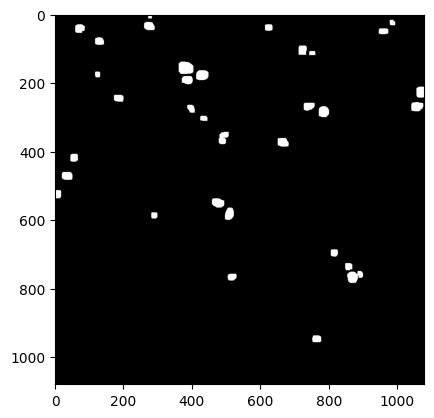

In [ ]:
plt.imshow(prediction_avec_tuilage_, cmap="gray")

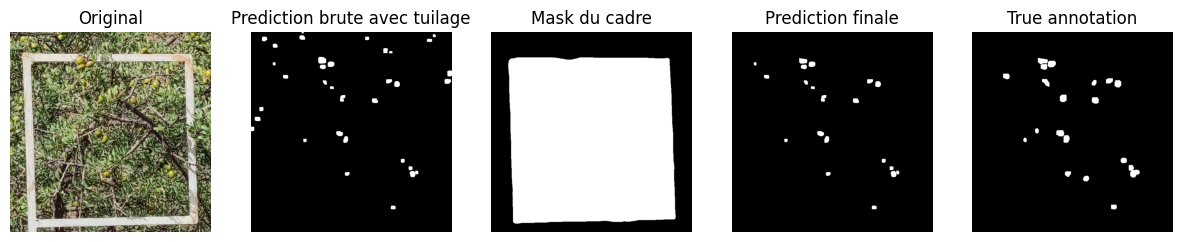

In [ ]:
# =============== INFERENCE ===================
# img_path_1 = "/content/SegmentArg-3/content/SegmentArg-3/valid/images/BIG_11_CadreFruitEst_ArbreEch_1_V1_2022-03-26_jpg.rf.4710410c4f01da4f488b701b75f6038e.jpg"
img_path_2 = "/content/SegmentArg-3/content/SegmentArg-3/train/images/BIG_11_CadreFruitEst_ArbreEch_2_V1_2022-03-26_jpg.rf.e87d1e9b3e023dff2a1be4529f427782.jpg"
labels_path = "/content/SegmentArg-3/content/SegmentArg-3/train/labels/"

for img_path in [img_path_2]:
  img_array = skimage.io.imread(img_path)
  # Prediction sans tuilage
  input_img_size = 640
  prediction_sans_tuilage = predict_tile_mask(img_array, input_img_size, model=model_fruits)

  # Prediction with tiling
  n_rows = 3
  n_cols = 3
  liste_tiles_img2 = tile_image(img_path, n_rows, n_cols)

  predictions = []

  for tile in liste_tiles_img2:
    predictions.append(predict_tile_mask(tile, input_img_size, model_fruits))
  prediction_avec_tuilage = concat_tiles(predictions, n_rows, n_cols)

  prediction_avec_tuilage = denoiseImage(prediction_avec_tuilage)
  # -- Cleaning the prediction -----
  #kernel = np.ones((10,10),np.uint8)
  #prediction_avec_tuilage = denoised = cv2.morphologyEx(prediction_avec_tuilage.astype(numpy.uint8), cv2.MORPH_CLOSE, kernel)

  #prediction_avec_tuilage = cv2.dilate(prediction_avec_tuilage.astype(numpy.uint8),kernel,iterations = 1)
  #prediction_avec_tuilage = cv2.erode(prediction_avec_tuilage.astype(numpy.uint8),kernel,iterations = 1)

  # ---- Prediction du mask du cadre
  TARGET_SHAPE = (640, 640, 3)
  img_tensor, img_shape = preprocess_(img_path, TARGET_SHAPE)
  prediction_frame_mask = predict_(img_tensor, model_frame)
  prediction_frame_mask = postprocess_(prediction_frame_mask, img_shape[:2])


  # Multiply fruits mask and frame mask
  pred_final = np.multiply(prediction_avec_tuilage, prediction_frame_mask)

  image_array = skimage.io.imread(img_path)
  # Get the labelled mask
  polygons_path = os.path.join(labels_path, img_path.split("/")[-1][:-4] + ".txt")

  labeled_annots = createMaskImagefromAnnotation(img_path, polygons_path)
  labeled_annots = numpy.multiply(labeled_annots, prediction_frame_mask)



  # ============ Visualisation ======
  visualize_images([image_array, prediction_avec_tuilage, prediction_frame_mask, pred_final, labeled_annots], ["Original", "Prediction brute avec tuilage", "Mask du cadre", "Prediction finale", "True annotation"])

In [ ]:
prediction_avec_tuilage

()

In [ ]:
# ================= ECriture de la prédiction en fichier csv =============
save_path = "/content/drive/MyDrive/MFE/Models/UnetTilling"
images_path = "/content/SegmentArg-3/content/SegmentArg-3/train/images/"
labels_path = "/content/SegmentArg-3/content/SegmentArg-3/train/labels/"

file_csv_path = "/content/drive/MyDrive/MFE/Models/UnetTilling/predictions_avec_mask_cadre_traindata.csv"

with open(file_csv_path, "w") as f:

  f.write("image,nombre_fruit,nombre_predit_tuilage,nombre_predit_sans_tuilage\n")
  for img_path in tqdm(glob.glob(images_path + "*.jpg"), desc="Processing ..."):
    img_array = skimage.io.imread(img_path)
    # Prediction sans tuilage
    input_img_size = 896
    prediction_sans_tuilage = predict_tile_mask(img_array, input_img_size, model=model_fruits)

    # Prediction with tiling
    n_rows = 3
    n_cols = 3
    liste_tiles_img2 = tile_image(img_path, n_rows, n_cols)

    predictions = []

    for tile in liste_tiles_img2:
      predictions.append(predict_tile_mask(tile, input_img_size, model_fruits))
    prediction_avec_tuilage = concat_tiles(predictions, n_rows, n_cols)

    # -- Cleaning the prediction -----
    #kernel = np.ones((5,5),np.uint8)
    #prediction_avec_tuilage = cv2.erode(prediction_avec_tuilage.astype(numpy.uint8), kernel, iterations=1)
    #prediction_sans_tuilage = cv2.dilate(prediction_sans_tuilage.astype(numpy.uint8), kernel, iterations=1)
    #prediction_avec_tuilage = cv2.morphologyEx(prediction_avec_tuilage.astype(numpy.uint8), cv2.MORPH_CLOSE, kernel)

    # ---- Prediction du mask du cadre
    TARGET_SHAPE = (896, 896, 3)
    img_tensor, img_shape = preprocess_(img_path, TARGET_SHAPE)
    prediction_frame_mask = predict_(img_tensor, model_frame)
    prediction_frame_mask = postprocess_(prediction_frame_mask, img_shape[:2])

    # Multiply fruits mask and frame mask
    pred_final_avec_tuilage = np.multiply(prediction_avec_tuilage, prediction_frame_mask)
    pred_final_sans_tuilage = np.multiply(prediction_sans_tuilage, prediction_frame_mask)
    #pred_final_sans_tuilage = denoiseImage(pred_final_sans_tuilage)
    #pred_final_avec_tuilage = denoiseImage(pred_final_avec_tuilage)

    image_array = skimage.io.imread(img_path)
    # Get the labelled mask
    polygons_path = os.path.join(labels_path, img_path.split("/")[-1][:-4] + ".txt")
    labeled_annots = createMaskImagefromAnnotation(img_path, polygons_path)
    labeled_annots_mask = numpy.multiply(labeled_annots, prediction_frame_mask)

    # ---------------- Get number of fruits ----------------
    true_number = getNumberObjects_from_mask(labeled_annots_mask)
    pred_number_sans_tuilage = getNumberObjects_from_mask(pred_final_sans_tuilage)
    pred_number_avec_tuilage = getNumberObjects_from_mask(pred_final_avec_tuilage)

    nom_img = img_path.split("/")[-1].split(".")[0][:-4] + ".jpg"

    # ------------------------- Ecriture ------------------
    f.write(f"{nom_img}" + "," + str(true_number) + "," + str(pred_number_avec_tuilage) + "," + str(pred_number_sans_tuilage) + "\n")


Processing ...: 100%|██████████| 596/596 [13:37<00:00,  1.37s/it]


## Analyse des résultats

In [ ]:
import pandas as pd
# f 640
# file_csv_path = "/content/drive/MyDrive/MFE/Models/UnetTilling/predictions_avec_mask_cadre.csv"

df = pd.read_csv(file_csv_path)
df.head()

image  nombre_fruit  \
0  TIO_45_CadreFruitOuest_ArbreEch_1_V1_2022-03-2...            98   
1  DRA_29_CadreFruitNord_ArbreEch_1_V1_2022-03-21...             8   
2  TAF_34_CadreFruitSud_ArbreEch_2_V1_2022-03-27.jpg            17   
3  TIO_48_CadreFruitNord_ArbreEch_3_V1_2022-03-24...            12   
4  TAF_30_CadreFruitEst_ArbreEch_4_V1_2022-03-26.jpg            32   

   nombre_predit_tuilage  nombre_predit_sans_tuilage  
0                     72                          44  
1                      4                           7  
2                     11                           7  
3                     15                           0  
4                     33                          22

In [ ]:
# ============== Calcul de la corrélation et du MAE ======================
from sklearn.metrics import mean_absolute_error
# nombre_fruit,nombre_predit_tuilage,nombre_predit_sans_tuilage

mae_tilling = mean_absolute_error(df["nombre_predit_tuilage"], df["nombre_fruit"])
mae_no_tilling = mean_absolute_error(df["nombre_predit_sans_tuilage"], df["nombre_fruit"])

print("MAE sans tuilage :", '{:.2f}'.format(mae_no_tilling))
print("MAE avec tuilage :", '{:.2f}'.format(mae_tilling))

# Voir la corrélation : true_number,number_with_tiling,number_without_tiling
coor_sans_tuilage = df["nombre_fruit"].corr(df["nombre_predit_sans_tuilage"])
coor_avec_tuilage = df["nombre_fruit"].corr(df["nombre_predit_tuilage"])

print("Corrélation sans tuilage :", '{:.2f}'.format(coor_sans_tuilage))
print("Corrélation avec tuilage :", '{:.2f}'.format(coor_avec_tuilage))

MAE sans tuilage : 5.81
MAE avec tuilage : 4.65
Corrélation sans tuilage : 0.84
Corrélation avec tuilage : 0.92


Text(0.5, 1.0, 'Nuage de points - sans tuilage (corr = 0.84 et mae = 5.81)')

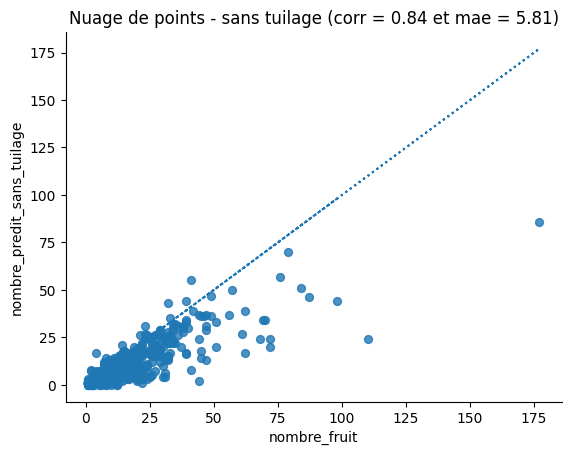

In [ ]:
from matplotlib import pyplot as plt
df.plot(kind='scatter', x='nombre_fruit', y='nombre_predit_sans_tuilage', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.plot(df['nombre_fruit'], df['nombre_fruit'], linestyle = 'dotted')
plt.title(f"Nuage de points - sans tuilage (corr = {'{:.2f}'.format(coor_sans_tuilage)} et mae = {'{:.2f}'.format(mae_no_tilling)})")



Text(0.5, 1.0, 'Nuage de points - avec tuilage (corr = 0.92 et mae = 4.65)')

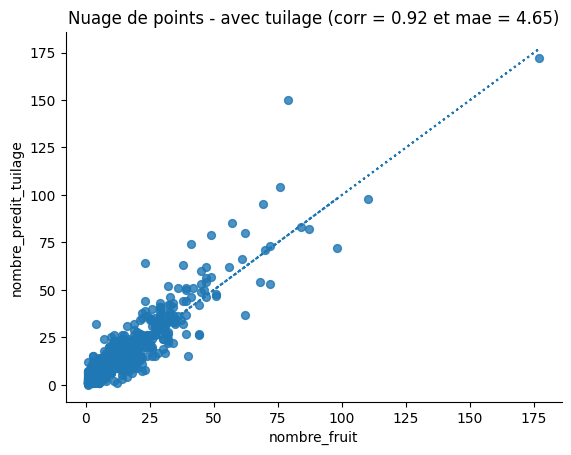

In [ ]:
from matplotlib import pyplot as plt
df.plot(kind='scatter', x='nombre_fruit', y='nombre_predit_tuilage', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.plot(df['nombre_fruit'], df['nombre_fruit'], linestyle = 'dotted')
plt.title(f"Nuage de points - avec tuilage (corr = {'{:.2f}'.format(coor_avec_tuilage)} et mae = {'{:.2f}'.format(mae_tilling)})")

# Implement U-Net

## Installs

In [ ]:
!pip install segmentation_models_pytorch
!pip install -U ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

## Imports

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torch import optim

from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import glob, os
from tqdm import tqdm

from segmentation_models_pytorch.losses import JaccardLoss
import segmentation_models_pytorch as smp

from pathlib import Path
import pandas as pd

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

from skimage import measure
import skimage
from skimage.morphology import remove_small_holes
from skimage import morphology
from skimage.morphology import diameter_closing
from scipy import ndimage

from ultralytics import YOLO
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Model architecture

In [ ]:
class DoubleConv(nn.Module):
  """
  Double Convolution : Implements two convolution layers with batch normalization and ReLU activation
  """
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        # First conv
        nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding="same", bias=False # Bias = False because even if we use it, it will be cancelled by BatchNorm
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.ReLU(inplace=True),

        # 2nd conv
        nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding="same", bias=False
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.ReLU(inplace=True),
    )

  def forward(self, x):
    """
    Forward pass : This function will be called once we call the DoubleConv class with the input x
    """
    return self.conv(x)


class Unet(nn.Module):
  """
  U-Net : Implements the U-Net architecture
  """
  def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
    """
    in_channels: Number of input channels
    out_channels: Number of output channels
    features: Number of features in each block. The number of features are doubled at each block
    """
    super(Unet, self).__init__()
    #
    self.ups = nn.ModuleList()
    self.downs = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # Downsample the size by 2 : W/2 and H/2

    # Down part of Unet : the encoder
    for feature in features:
      self.downs.append(
          DoubleConv(in_channels, feature)
      )
      in_channels = feature # For the next Block

    # Up part of Unet : the decoder
    for feature in reversed(features):
      self.ups.append(
          nn.ConvTranspose2d(
              in_channels=feature*2, out_channels=feature, kernel_size=2, stride=2 # Double height and width
          )
      )
      self.ups.append(
          DoubleConv(in_channels=feature*2, out_channels=feature)
      )

    # Bottleneck layer : transition between the encoder and the decoder
    self.bottleneck = DoubleConv(in_channels=features[-1], out_channels=features[-1]*2)
    # Conv layer that outputs the prediction
    self.final_conv = nn.Conv2d(in_channels=features[0], out_channels=out_channels, kernel_size=1)

  def forward(self, x):
    """
    Forward pass : This function will be called once we call the Unet class with the input x
    """
    skip_connections = []

    # For each block in the down part : do the forward pass and add the features
    # to the skip connexions before maxPooling
    for down in self.downs:
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x) # Downsample the H and W by 2

    x = self.bottleneck(x)

    # Up part :
    skip_connections = skip_connections[::-1] # Reverse the list
    for idx in range(0, len(self.ups), 2):
      x = self.ups[idx](x) # call the Transpose conv to double the spatial resolution

      # Concat with the skip connexion
      skip_connection = skip_connections[idx//2]

      if x.shape != skip_connection.shape:
        x = TF.resize(x, size=skip_connection.shape[2:]) # Resize the tensor to the shape of the skip connection
      concat_skip = torch.cat((skip_connection, x), dim=1)
      # Pass the concat to the DoubleConv
      x = self.ups[idx+1](concat_skip)

    # Final conv layer
    out = self.final_conv(x)

    return out

In [ ]:
def test():
  x = torch.randn((1, 3, 640, 640))
  model = Unet(in_channels=3, out_channels=3)
  preds = model(x)
  assert preds.shape == x.shape
  print("preds.shape :", preds.shape, "x.shape :", x.shape)
  print("Test passed")

## Dataset and DataLoader

In [ ]:

"""CUSTOM DATASET"""
class SegmentationDataset(Dataset):

  def __init__(
      self,
      liste_images,
      liste_annotations,
      mapping_label={0: 0, 255: 1},
      augmentations=None
      ):
    """
    liste_images: liste des chemins absolus vers les images
    liste_annotations; liste des chemins absolus vers les annotations
    classes_pixels_values: valeurs de pixels correspondant aux différentes classes. 0 -> background | 128: fruit | 255: contour

    """
    self.liste_images = liste_images
    self.liste_annotations = liste_annotations
    self.mapping = mapping_label
    self.augmentations = augmentations

  def __len__(self):
    return len(self.liste_images)

  def mask_to_class_f(self, mask):
    """
    Replaces each pixel with its class index.
    e.g: 0 by 0, 255 by 1
    """
    masque = np.copy(mask)
    for k in self.mapping:
        masque[mask==k] = self.mapping[k]
    return masque.astype(dtype=np.float32)

  def __getitem__(self, index):
    image_array = np.asarray(Image.open(self.liste_images[index]).convert("RGB"))
    f_label_array = np.asarray(Image.open(self.liste_annotations[index]).convert("L"))
    label_array = np.copy(f_label_array)

    # One hot coding of the classes within the mask
    label_array = self.mask_to_class_f(label_array)

    if self.augmentations:
      data = self.augmentations(image=image_array, mask=label_array)
      image_array, label_array = data["image"], data["mask"]

    image_array = np.transpose(image_array, axes=(2, 0, 1)).astype(np.float32)
    image_array = torch.Tensor(image_array)/255.0
    label_array = torch.Tensor(label_array).long()

    return image_array, label_array


def get_list_data(images_folder, labels_folder):
  """
  Récupère la liste des images ainsi que leur annotations à partir d'un dossier
  le dossier doit avoir deux sous dossiers: images et labels_masks
  """

  images_paths = [
      e.replace("\\", "/") for e in glob.glob(os.path.join(images_folder, "*.jpg"))
  ]
  labels_paths = [
      e.replace("\\", "/") for e in glob.glob(os.path.join(labels_folder, "*.png"))
  ]

  liste_images = []
  liste_annotations = []
  for img_path in images_paths:
    label_path = os.path.join(labels_folder, img_path.split("/")[-1][:-4]+".png").replace("\\", "/")
    if label_path in labels_paths:
      liste_images.append(img_path)
      liste_annotations.append(label_path)

  return liste_images, liste_annotations


## TRAIN CONFIG

In [ ]:
def train_fn(model, dataloader, optimizer, loss_fn, scaler, epoch, n_epochs, device):
  """
    Do one epoch of training
  """
  loop = tqdm(dataloader)
  total_loss = 0.
  for batch_idx, (images, masks) in enumerate(loop):
    images, masks = images.to(device), masks.to(device)

    # forward
    optimizer.zero_grad()
    with torch.cuda.amp.autocast():
      predictions = model(images)
      loss = loss_fn(predictions, masks)
      if isinstance(loss.cpu().item(), float):
        total_loss += (loss.cpu().item() / len(dataloader))

    # backward
    # scaler.scale(loss).backward()
    # scaler.step(optimizer)
    # scaler.update()
    loss.backward()
    optimizer.step()
    loss_format = "{:.5f}".format(total_loss)
    loop.set_description(f"Epoch {epoch}/{n_epochs}   train_loss = {loss_format}")
  return total_loss


def val_fn(model, dataloader, loss_fn, device):
  model.eval()
  with torch.no_grad():
    total_loss = 0.
    loop_eval = tqdm(dataloader, desc="evaluating")
    for images, masks in loop_eval:
      with torch.cuda.amp.autocast():
        images, masks = images.to(device), masks.to(device)
        logits = model(images)
        loss = loss_fn(logits, masks)
        if isinstance(loss.cpu().item(), float):
          total_loss += (loss.cpu().item() / len(dataloader))
      loss_format = "{:.5f}".format(total_loss)
      loop_eval.set_description(f" val_loss = {loss_format} ")
    model.train()
    return total_loss

def EvalEpoch(model, val_loader, device="cpu", post_process_func=None):
    """
    model: model to evaluate
    val_loader: validation data loader

    return: metrics
    """

    def appliquer_traitement_batch(batch):
      """
        Appliquer la fonction de post_traitement au batch
      """
      batch_traite = np.zeros_like(batch)
      for i in range(batch.shape[0]):
          batch_traite[i] = post_process_func(batch[i])
      return batch_traite

    model.eval()
    with torch.no_grad():
        loop_eval = tqdm(val_loader, desc="evaluating")
        TP, FP, FN, TN = 0, 0, 0, 0

        i = 0
        for images, masks in loop_eval:
            images, masks = images.to(device), masks.to(device)
            masks = torch.unsqueeze(masks, dim=1) # Add a new dimension a index 1 : batch, H, W to batch, C, H, W

            results = model(images)
            results = torch.nn.Sigmoid()(results)
            results = (results >= 0.5).long()

            # --------- Apply post processing ------------
            if post_process_func is not None:
              results = results.cpu().numpy() # shape : [8, 1, 960, 960]
              results = np.squeeze(results, axis=1) # Remove C dim
              results = appliquer_traitement_batch(results)
              results = np.expand_dims(results, axis=1) # Add the C dim
              results = torch.Tensor(results).long().to(device) # Transform to torch tensor and move to the device


            stats = smp.metrics.functional.get_stats(output=results, target=masks, mode="binary")
            if i == 0:
              TP, FP, FN, TN = stats[0], stats[1], stats[2], stats[3]
            else:
              TP, FP = torch.cat((TP, stats[0])), torch.cat((FP, stats[1]))
              FN, TN = torch.cat((FN, stats[2])), torch.cat((TN, stats[3]))
            i += 1


        accuracy = smp.metrics.functional.accuracy(TP, FP, FN, TN, reduction="micro")
        iou = smp.metrics.functional.iou_score(TP, FP, FN, TN, reduction="micro")
        fp_rate = smp.metrics.functional.false_negative_rate(TP, FP, FN, TN, reduction="micro") # False positive rate
        fn_rate = smp.metrics.functional.false_positive_rate(TP, FP, FN, TN, reduction="micro") # False negative rate

        return {
            "accuracy": accuracy.item(),
            "iou_score": iou.item(),
            "fp_rate": fp_rate.item(),
            "fn_rate": fn_rate.item()
        }

## Postprocess functions

In [ ]:
def remove_smallest_blobs(input_mask):
    """
    Remove all the smaller blobs and only keep the biggest one
    """
    labels_mask = measure.label(input_mask)
    regions = measure.regionprops(labels_mask)
    regions.sort(key=lambda x: x.area, reverse=True)
    if len(regions) > 1:
        for rg in regions[1:]:
            labels_mask[rg.coords[:,0], rg.coords[:,1]] = 0
    labels_mask[labels_mask!=0] = 1
    return labels_mask

def erode_mask(mask, kernel_size, n_iters=1):
    return cv2.erode(mask.astype(np.uint8), kernel=np.ones((kernel_size, kernel_size)), iterations=n_iters)

def dilate_mask(mask, kernel_size, n_iters=1):
    return cv2.dilate(mask.astype(np.uint8), kernel=np.ones((kernel_size, kernel_size)), iterations=n_iters)

def remove_small_holes(mask, threshold):
    return morphology.remove_small_holes(ar=mask, connectivity=2, area_threshold=threshold)

def post_process(input_mask):
    mask = remove_smallest_blobs(input_mask)
    # mask = remove_small_holes(mask, area_threshold=1000)
    mask = ndimage.binary_fill_holes(mask)
    # selem = morphology.disk(25)
    # mask = morphology.closing(mask, selem)
    mask = erode_mask(mask, kernel_size=11, n_iters=3)
    mask = remove_smallest_blobs(input_mask)
    mask = dilate_mask(mask, kernel_size=11, n_iters=2)
    mask = ndimage.binary_fill_holes(mask)
    return mask.astype(np.uint8)

def post_process_1(input_mask):
  """
    Ops :
      - ne retenir que le plus grand blob
      - remplir tous les trous
  """
  mask = remove_smallest_blobs(input_mask)
  mask_final = ndimage.binary_fill_holes(mask).astype(np.uint8)
  return mask_final

def post_process_2(input_mask):
  """
    Ops :
      - Erode mask : k = 11, n_iters=3
      - ne retenir que le plus grand blob
      - remplir tous les trous
      - Dilate mask : k = 11, n_iters=3
  """
  mask = erode_mask(input_mask, kernel_size=11, n_iters=3)
  mask = remove_smallest_blobs(mask)
  mask = ndimage.binary_fill_holes(mask).astype(np.uint8)
  mask_final = dilate_mask(mask, kernel_size=11, n_iters=3)
  return mask_final

## Training

In [ ]:
LR = 0.005
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
NUM_EPOCHS = 500
NUM_WORKERS = 2
IMG_WIDTH = 960
IMG_HEIGHT = 960
PIN_MEMORY = True

VAL_IMGS_DIR = "/content/drive/MyDrive/ModelsTraining/Framedetection-13/valid/images"
VAL_MASKS_DIR = "/content/drive/MyDrive/ModelsTraining/Framedetection-13/valid/labels_masks"
TRAIN_IMGS_DIR = "/content/drive/MyDrive/ModelsTraining/Framedetection-13/train/images"
TRAIN_MASKS_DIR = "/content/drive/MyDrive/ModelsTraining/Framedetection-13/train/labels_masks"
VALID_IMGS_PATHS, VALID_MASKS_PATHS = get_list_data(VAL_IMGS_DIR, VAL_MASKS_DIR)
# TRAIN_IMGS_PATHS, TRAIN_MASKS_PATHS = get_list_data(TRAIN_IMGS_DIR, TRAIN_MASKS_DIR)

In [ ]:
# ============== Augmentations ===============================
"""A.Normalize(
        mean=[0., 0., 0.],
        std=[1., 1., 1.],
        max_pixel_value=255.
    )"""
train_transforms = A.Compose([
    A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH),
    A.HorizontalFlip(p=0.5)
])
val_transforms = A.Compose([
    A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH)
])

In [ ]:

"""train_ds = SegmentationDataset(TRAIN_IMGS_PATHS, TRAIN_MASKS_PATHS, augmentations=train_transforms)
train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                          drop_last=True)"""
val_ds = SegmentationDataset(VALID_IMGS_PATHS, VALID_MASKS_PATHS, augmentations=val_transforms)
val_loader = DataLoader(dataset=val_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                          drop_last=False)

In [ ]:
EvalEpoch(model_cadre, val_loader, device=DEVICE, post_process_func=post_process_2)

evaluating: 100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


{'accuracy': 0.9878357648849487,
 'iou_score': 0.9808117151260376,
 'fp_rate': 0.009141817688941956,
 'fn_rate': 0.017256012186408043}

In [ ]:
img_path = "/content/drive/MyDrive/ModelsTraining/Framedetection-13/valid/images/LQL_8_CadreFruitNord_ArbreEch_2_V1_2022-03-18_jpg.rf.92c478ae4a806e0449cb8f422102615b.jpg"
res = model_cadre.predict(image=img_path, prediction_size=960, device=DEVICE)

In [ ]:
# ------------------ Validation du modèle ----------------------------
model_cadre = SegmentationModel("/content/drive/MyDrive/ModelsTraining/SegmentFrameFinale/NoAttention/weights/last.pt").to(DEVICE)
save_path = "/content/drive/MyDrive/ModelsTraining/Framedetection-13/valid/predict_postprocess1"
imgs = glob.glob("/content/drive/MyDrive/ModelsTraining/Framedetection-13/valid/images/*.jpg")
for img in imgs:
  name = img.split("/")[-1].replace(".jpg", ".png")
  res = model_cadre.predict(image=img, prediction_size=960, device=DEVICE)
  res = post_process_1(res)
  io.imsave(save_path + "/" + name, res * 255)

In [ ]:
raw_imgs_fold = "/content/drive/MyDrive/ModelsTraining/Framedetection-13/valid/images/"
file = raw_imgs_fold + "BIG_35_CadreFruitSud_ArbreEch_1_V1_2022-03-28_jpg.rf.b8fee57b595ca465b12ecfb5371c13f3.jpg"
model = YOLO("/content/drive/MyDrive/ModelsTraining/SegmentFrameFinale/yolov8s_seg_model_cadre_960/weights/best.pt")
res = model.predict(source=file, conf=0., imgsz=960, max_det=1, verbose=False)
masques = [e.tolist() for e in res[0].masks.xy]
img_mask = Image.new(mode="L", size=Image.open(file).size)
draw = ImageDraw.Draw(img_mask)
for pol in masques:
  draw.polygon(xy=[tuple(e) for e in pol], fill="white", outline=None, width=None)

pred_mask = np.asarray(img_mask)
pred_mask_post_processed = post_process_1(pred_mask)

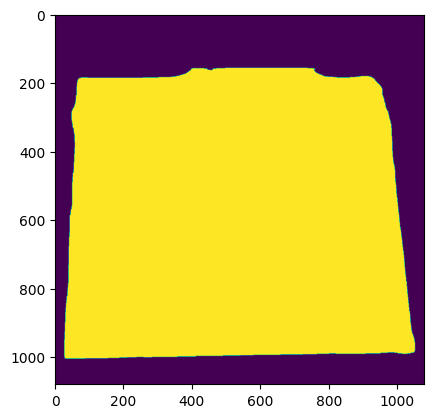

In [ ]:
plt.imshow(pred_mask_post_processed)

In [ ]:
# Présence de trou au niveau du cadre
img_path = "/content/drive/MyDrive/ModelsTraining/Framedetection-13/valid/"
pred_msk_no_post = "BIG_35_CadreFruitSud_ArbreEch_1_V1_2022-03-28_jpg.rf.b8fee57b595ca465b12ecfb5371c13f3.png"
arr_pred_msk_unet = io.imread(img_path + "predict_postprocess1/" + pred_msk_no_post)
arr_pred_msk_yolo = io.imread(img_path + "yolo_pred_post1/" + pred_msk_no_post)
arr_true_mask = io.imread(img_path + "labels_masks/" + pred_msk_no_post)

arr_pred_msk_unet = val_transforms(image=arr_pred_msk_unet, mask=arr_pred_msk_unet)["mask"][np.newaxis, ...] / 255
arr_pred_msk_yolo = val_transforms(image=arr_pred_msk_yolo, mask=arr_pred_msk_yolo)["mask"][np.newaxis, ...] / 255
arr_true_mask = val_transforms(image=arr_true_mask, mask=arr_true_mask)["mask"][np.newaxis, ...] / 255

tens_pred_msk_unet = torch.Tensor(arr_pred_msk_unet).long()
tens_pred_msk_yolo = torch.Tensor(arr_pred_msk_yolo).long()
tens_true_mask = torch.Tensor(arr_true_mask).long()

stats_unet = smp.metrics.functional.get_stats(output=tens_pred_msk_unet, target=tens_true_mask, mode="binary")
stats_yolo = smp.metrics.functional.get_stats(output=tens_pred_msk_yolo, target=tens_true_mask, mode="binary")

iou_unet = smp.metrics.functional.iou_score(stats_unet[0], stats_unet[1], stats_unet[2], stats_unet[3], reduction="micro")
iou_yolo = smp.metrics.functional.iou_score(stats_yolo[0], stats_yolo[1], stats_yolo[2], stats_yolo[3], reduction="micro")

print(iou_unet.item(), iou_yolo.item())

0.9857217073440552 0.9654837250709534


In [ ]:
"""
=================================== Modèle UNET =========================================
-------------------- Sans post-traitement ------------------
'accuracy': 0.9875773787498474,
'iou_score': 0.9804178476333618,
'fp_rate': 0.008846800774335861,
'fn_rate': 0.018446670845150948

------------- 1er post traitement : remove all smallest blobs and fill all holes ---------
'accuracy': 0.9878255724906921,
 'iou_score': 0.9808021187782288,
 'fp_rate': 0.008816875517368317,
 'fn_rate': 0.017830833792686462

 =================================== Modèle YOLOv8-seg ===================================
 -------------- Sans post-traitement ---------------------
 'accuracy': 0.9862661361694336,
 'iou_score': 0.9783952236175537,
 'fp_rate': 0.012970848008990288,
 'fn_rate': 0.01503381971269846,

 -------------- Avec post traitement ---------------------
 'accuracy_p': 0.9846623539924622,
 'iou_score_p': 0.9759331345558167,
 'fp_rate_p': 0.015476505272090435,
 'fn_rate_p': 0.015099288895726204
"""
data = {
    "model": ["unet", "unet", "yolov8s", "yolov8s"],
    "postprocess": ["Pas de traitement postérieur", "Traitement postérieur", "Pas de traitement postérieur", "Traitement postérieur"],
    "accuracy": [0.9875773787498474, 0.9878255724906921, 0.9862661361694336, 0.9846623539924622],
    "iou_score": [0.9804178476333618, 0.9808021187782288, 0.9783952236175537, 0.9759331345558167],
    "fp_rate": [0.008846800774335861, 0.008816875517368317, 0.012970848008990288, 0.015476505272090435],
    "fn_rate": [0.018446670845150948, 0.017830833792686462, 0.01503381971269846, 0.015099288895726204]
}
df = pd.DataFrame(data)
df.head()

model                   postprocess  accuracy  iou_score   fp_rate  \
0     unet  Pas de traitement postérieur  0.987577   0.980418  0.008847   
1     unet         Traitement postérieur  0.987826   0.980802  0.008817   
2  yolov8s  Pas de traitement postérieur  0.986266   0.978395  0.012971   
3  yolov8s         Traitement postérieur  0.984662   0.975933  0.015477   

    fn_rate  
0  0.018447  
1  0.017831  
2  0.015034  
3  0.015099

In [ ]:
df.to_csv("/content/drive/MyDrive/ModelsTraining/SegmentFrameFinale/validation_yolo_unet.csv")

In [ ]:
# ------------------ Validation du modèle ----------------------------
model = YOLO("/content/drive/MyDrive/ModelsTraining/SegmentFrameFinale/yolov8s_seg_model_cadre_960/weights/best.pt")
save_path_nopost = "/content/drive/MyDrive/ModelsTraining/Framedetection-13/valid/yolo_pred_no_post"
save_path_post = "/content/drive/MyDrive/ModelsTraining/Framedetection-13/valid/yolo_pred_post1"
imgs = glob.glob("/content/drive/MyDrive/ModelsTraining/Framedetection-13/valid/images/*.jpg")
for img in imgs:
  name = img.split("/")[-1].replace(".jpg", ".png")
  # --------- Prédire le masque et le transformer en numpy ndarray
  res = model.predict(source=img, conf=0., imgsz=960, max_det=1, verbose=False)
  masques = [e.tolist() for e in res[0].masks.xy]
  img_mask = Image.new(mode="L", size=Image.open(img).size)
  draw = ImageDraw.Draw(img_mask)
  for pol in masques:
    draw.polygon(xy=[tuple(e) for e in pol], fill="white", outline=None, width=None)

  pred_mask = np.asarray(img_mask)
  pred_mask_post_processed = post_process_1(pred_mask)


  io.imsave(save_path_nopost + "/" + name, pred_mask, ch)
  io.imsave(save_path_post + "/" + name, pred_mask_post_processed)

In [ ]:
from skimage import io

In [ ]:
save_path_post = "/content/drive/MyDrive/ModelsTraining/Framedetection-13/valid/yolo_pred_post1"
imgs = glob.glob("/content/drive/MyDrive/ModelsTraining/Framedetection-13/valid/yolo_pred_post1/*.png")
for img_p in imgs:
  img = io.imread(img_p) * 255
  img = Image.fromarray(img )
  img.save(img_p)


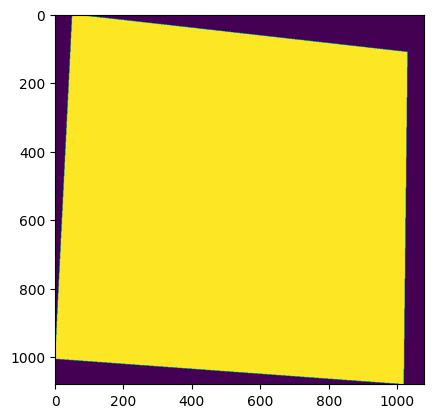

In [ ]:

i = 0
TP, FP, TN, FN = 0, 0, 0, 0
TP_p, FP_p, TN_p, FN_p = 0, 0, 0, 0
model = YOLO("/content/drive/MyDrive/ModelsTraining/SegmentFrameFinale/yolov8s_seg_model_cadre_960/weights/best.pt")
IOUs = []
Accs = []
FPr = []
FNr = []
for img_p, msk_p in zip(VALID_IMGS_PATHS, VALID_MASKS_PATHS):
  true_mask = np.asarray(Image.open(msk_p).convert("L"))
  plt.imshow(np.array(true_mask))
  true_mask = val_transforms(image=true_mask, mask=true_mask)["mask"][np.newaxis, ...] / 255
  true_mask_tensor = torch.Tensor(true_mask).long()

  # --------- Prédire le masque et le transformer en numpy ndarray
  res = model.predict(source=img_p, conf=0., imgsz=960, max_det=1, verbose=False)
  masques = [e.tolist() for e in res[0].masks.xy]
  img_mask = Image.new(mode="L", size=Image.open(img_p).size)
  draw = ImageDraw.Draw(img_mask)
  for pol in masques:
    draw.polygon(xy=[tuple(e) for e in pol], fill="white", outline=None, width=None)

  mask_array = np.asarray(img_mask)
  pred_mask = val_transforms(image=mask_array, mask=mask_array)["mask"] / 255
  msk_post_processed = post_process_1(pred_mask)

  pred_mask_tensor = torch.Tensor(pred_mask[np.newaxis, ...]).long()
  post_processed_mask_tensor = torch.Tensor(msk_post_processed[np.newaxis, ...]).long()


  stats = smp.metrics.functional.get_stats(output=true_mask_tensor, target=pred_mask_tensor, mode="binary")
  stats_p = smp.metrics.functional.get_stats(output=true_mask_tensor, target=post_processed_mask_tensor, mode="binary")
  if i == 0:
    TP, FP, FN, TN = stats[0], stats[1], stats[2], stats[3]
    TP_p, FP_p, TN_p, FN_p = stats_p[0], stats_p[1], stats_p[2], stats_p[3]
  else:
    TP, FP = torch.cat((TP, stats[0])), torch.cat((FP, stats[1]))
    FN, TN = torch.cat((FN, stats[2])), torch.cat((TN, stats[3]))

    TP_p, FP_p = torch.cat((TP_p, stats_p[0])), torch.cat((FP_p, stats_p[1]))
    FN_p, TN_p = torch.cat((FN_p, stats_p[2])), torch.cat((TN_p, stats_p[3]))
  i += 1

  tp, fp, fn, tn = stats[0], stats[1], stats[2], stats[3]
  tp_p, fp_p, tn_p, fn_p = stats_p[0], stats_p[1], stats_p[2], stats_p[3]

  IOUs.append([
      smp.metrics.functional.iou_score(tp, fp, fn, tn, reduction="micro").item(),
      smp.metrics.functional.iou_score(tp_p, fp_p, fn_p, tn_p, reduction="micro").item()
  ])
  Accs.append([
      smp.metrics.functional.accuracy(tp, fp, fn, tn, reduction="micro").item(),
      smp.metrics.functional.accuracy(tp_p, fp_p, fn_p, tn_p, reduction="micro").item()
  ])
  FPr.append([
      smp.metrics.functional.false_negative_rate(tp, fp, fn, tn, reduction="micro").item(),
      smp.metrics.functional.false_negative_rate(tp_p, fp_p, fn_p, tn_p, reduction="micro").item()
  ])
  FNr.append([
      smp.metrics.functional.false_positive_rate(tp, fp, fn, tn, reduction="micro").item(),
      smp.metrics.functional.false_positive_rate(tp_p, fp_p, fn_p, tn_p, reduction="micro").item()
  ])


accuracy = smp.metrics.functional.accuracy(TP, FP, FN, TN, reduction="micro")
iou = smp.metrics.functional.iou_score(TP, FP, FN, TN, reduction="micro")
fp_rate = smp.metrics.functional.false_negative_rate(TP, FP, FN, TN, reduction="micro") # False positive rate
fn_rate = smp.metrics.functional.false_positive_rate(TP, FP, FN, TN, reduction="micro") # False negative rate

accuracy_p = smp.metrics.functional.accuracy(TP_p, FP_p, FN_p, TN_p, reduction="micro")
iou_p = smp.metrics.functional.iou_score(TP_p, FP_p, FN_p, TN_p, reduction="micro")
fp_rate_p = smp.metrics.functional.false_negative_rate(TP_p, FP_p, FN_p, TN_p, reduction="micro") # False positive rate
fn_rate_p = smp.metrics.functional.false_positive_rate(TP_p, FP_p, FN_p, TN_p, reduction="micro") # False negative rate

final_res = {
    "accuracy": accuracy.item(),
    "iou_score": iou.item(),
    "fp_rate": fp_rate.item(),
    "fn_rate": fn_rate.item(),
    "accuracy_p": accuracy_p.item(),
    "iou_score_p": iou_p.item(),
    "fp_rate_p": fp_rate_p.item(),
    "fn_rate_p": fn_rate_p.item()
}

In [ ]:
IOUs_no_post = [e[0] for e in IOUs]
Accs_no_post = [e[0] for e in Accs]
FPr_no_post = [e[0] for e in FPr]
FNr_no_post = [e[0] for e in FNr]

IOUs_post = [e[1] for e in IOUs]
Accs_post = [e[1] for e in Accs]
FPr_post = [e[1] for e in FPr]
FNr_post = [e[1] for e in FNr]

In [ ]:
{
    "min_iou_no_post": min(IOUs_no_post),
    "max_iou_no_post": max(IOUs_no_post),
    "min_iou_post": min(IOUs_post),
    "max_iou_post": max(IOUs_post),

    "min_fp_rate_no_post": min(FPr_no_post),
    "max_fp_rate_no_post": max(FPr_no_post),
    "min_fp_rate_post": min(FPr_post),
    "max_fp_rate_post": max(FPr_post),

    "min_fn_rate_no_post": min(FNr_no_post),
    "max_fn_rate_no_post": max(FNr_no_post),
    "min_fn_rate_post": min(FNr_post),
    "max_fn_rate_post": max(FNr_post)
}

{'min_iou_no_post': 0.936307430267334,
 'max_iou_no_post': 0.9928925633430481,
 'min_iou_post': 0.26680856943130493,
 'max_iou_post': 0.9502377510070801,
 'min_fp_rate_no_post': 7.674063090234995e-05,
 'max_fp_rate_no_post': 0.05612059682607651,
 'min_fp_rate_post': 0.01943734474480152,
 'max_fp_rate_post': 0.7328001260757446,
 'min_fn_rate_no_post': 0.0,
 'max_fn_rate_no_post': 0.6214753985404968,
 'min_fn_rate_post': 0.0,
 'max_fn_rate_post': 0.9979227781295776}

In [ ]:
masques = [e.tolist() for e in res[0].masks.xy]
img_mask = Image.new(mode="L", size=true_mask.shape[1:])
draw = ImageDraw.Draw(img_mask)
for pol in masques:
  draw.polygon(xy=[tuple(e) for e in pol], fill="white", outline=None, width=None)


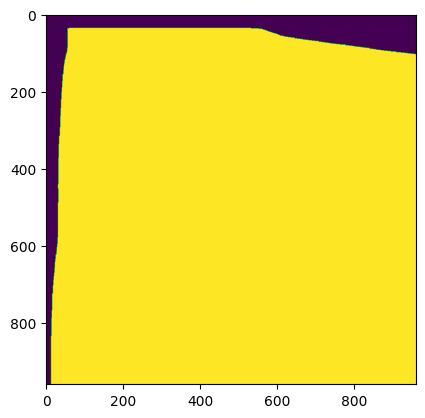

In [ ]:
plt.imshow(msk_post_processed)


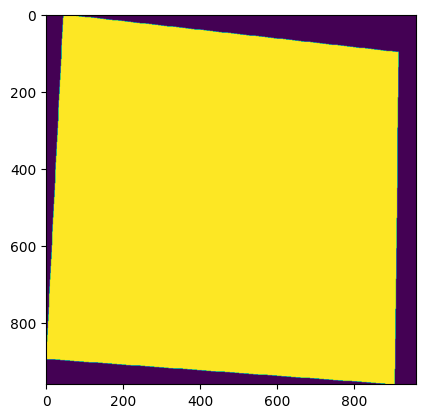

In [ ]:
plt.imshow(np.squeeze(true_mask, 0))

In [ ]:
res = model.predict(source=img_p, conf=0., imgsz=960, max_det=1, verbose=False)
plt.imshow(res[0].plot())

NameError: name 'img_p' is not defined

In [ ]:
img_mask

In [ ]:
# Batch tensor : torch.Size([8, 1, 960, 960]), dtype : torch.long()

In [ ]:


loss_fn = JaccardLoss(mode="binary", log_loss=True, from_logits=True, smooth=0.0, eps=1e-06)
model = Unet(in_channels=3, out_channels=1).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)
scaler = torch.cuda.amp.GradScaler()


save_dir = "/content/drive/MyDrive/ModelsTraining/SegmentFrameFinale/UNET_Implement"
(Path(save_dir) / "weights").mkdir(exist_ok=True)
weights_path = str(Path(save_dir) / "weights").replace("\\", "/")
save_dir = str(Path(save_dir)).replace("\\", "/")
train_checkpoint = weights_path + "/train_checkpoint.pt"

best_val_loss = 0.
start = 0
end = NUM_EPOCHS
df = pd.DataFrame({
    "epoch": [],
    "train_loss": [],
    "val_loss": []
})

cols = ["epoch", "train_loss", "val_loss"]
if train_checkpoint is not None:
  ckpt = torch.load(train_checkpoint, map_location=DEVICE)
  model.load_state_dict(ckpt["model_state_dict"])
  optimizer.load_state_dict(ckpt["optimizer_state_dict"])
  # scaler.load_state_dict(ckpt["scaler_state_dict"])

  start = ckpt["epoch"] + 1
  end = start + NUM_EPOCHS + 1
  best_val_loss = ckpt["best_val_loss"]
  df = pd.read_csv(save_dir + "/results.csv")
  df = df[cols]

# ---------------------- Start traning ------------------------------------
for epoch in range(start, end):
  train_loss = train_fn(model, train_loader, optimizer, loss_fn, scaler, epoch, NUM_EPOCHS, DEVICE)
  val_loss = val_fn(model, val_loader, loss_fn, DEVICE)

  # scheduler.step(val_loss)

  if epoch == 0:
    best_val_loss = val_loss
  elif val_loss < best_val_loss:
    best_val_loss = val_loss
    torch.save(model.state_dict(), weights_path + "/best.pt")


  df.loc[len(df.index)] = [epoch, train_loss, val_loss]
  df.to_csv(save_dir + "/results.csv", index=False)
  torch.save(model.state_dict(), weights_path + "/last.pt")
  torch.save({
              "epoch": epoch,
              "optimizer_state_dict": optimizer.state_dict(),
              "best_val_loss": best_val_loss,
              "model_state_dict": model.state_dict()
              # "scaler_state_dict": scaler.state_dict()
            },
             weights_path + "/train_checkpoint.pt",
                  )
  print()

 val_loss = 0.48221 : 100%|██████████| 24/24 [01:28<00:00,  3.69s/it]


 val_loss = 0.47879 : 100%|██████████| 24/24 [00:12<00:00,  1.87it/s]


 val_loss = 0.47936 : 100%|██████████| 24/24 [00:10<00:00,  2.24it/s]


 val_loss = 0.48465 : 100%|██████████| 24/24 [00:10<00:00,  2.24it/s]


 val_loss = 0.48158 : 100%|██████████| 24/24 [00:10<00:00,  2.23it/s]


 val_loss = 0.48281 : 100%|██████████| 24/24 [00:10<00:00,  2.22it/s]


 val_loss = 0.48152 : 100%|██████████| 24/24 [00:11<00:00,  2.12it/s]


 val_loss = 0.47517 : 100%|██████████| 24/24 [00:11<00:00,  2.01it/s]


 val_loss = 0.48370 : 100%|██████████| 24/24 [00:10<00:00,  2.19it/s]


 val_loss = 0.47289 : 100%|██████████| 24/24 [00:10<00:00,  2.24it/s]


 val_loss = 0.48712 : 100%|██████████| 24/24 [00:10<00:00,  2.28it/s]


 val_loss = 0.47923 : 100%|██████████| 24/24 [00:11<00:00,  2.18it/s]


 val_loss = 0.47848 : 100%|██████████| 24/24 [00:11<00:00,  2.14it/s]


 val_loss = 0.48216 : 100%|██████████| 24/24 [00:10<00:00,  2.20it/s]


 val_loss = 0.48202 : 100%|██████████| 24/24 [00:10<00:00,  2.19it/s]


 val_loss = 0.47967 : 100%|██████████| 24/24 [00:10<00:00,  2.20it/s]


 val_loss = 0.47615 : 100%|██████████| 24/24 [00:11<00:00,  2.12it/s]


 val_loss = 0.47856 : 100%|██████████| 24/24 [00:10<00:00,  2.19it/s]


 val_loss = 0.47534 : 100%|██████████| 24/24 [00:10<00:00,  2.19it/s]


 val_loss = 0.47540 : 100%|██████████| 24/24 [00:10<00:00,  2.23it/s]


 val_loss = 0.48435 : 100%|██████████| 24/24 [00:10<00:00,  2.21it/s]


 val_loss = 0.48062 : 100%|██████████| 24/24 [00:11<00:00,  2.16it/s]


 val_loss = 0.48418 : 100%|██████████| 24/24 [00:11<00:00,  2.18it/s]


 val_loss = 0.47162 : 100%|██████████| 24/24 [00:11<00:00,  2.05it/s]


 val_loss = 0.48270 : 100%|██████████| 24/24 [00:11<00:00,  2.02it/s]


 val_loss = 0.47577 : 100%|██████████| 24/24 [00:11<00:00,  2.06it/s]


 val_loss = 0.48730 : 100%|██████████| 24/24 [00:11<00:00,  2.05it/s]


 val_loss = 0.47503 : 100%|██████████| 24/24 [00:11<00:00,  2.13it/s]


 val_loss = 0.47834 : 100%|██████████| 24/24 [00:11<00:00,  2.08it/s]


 val_loss = 0.47874 : 100%|██████████| 24/24 [00:11<00:00,  2.06it/s]


 val_loss = 0.47505 : 100%|██████████| 24/24 [00:11<00:00,  2.14it/s]


 val_loss = 0.48479 : 100%|██████████| 24/24 [00:11<00:00,  2.01it/s]


 val_loss = 0.48419 : 100%|██████████| 24/24 [00:11<00:00,  2.03it/s]


Epoch 75/500   train_loss = 0.30060:  72%|███████▏  | 54/75 [01:03<00:24,  1.15s/it]

In [ ]:
"""
Olivie
Kalidou
cheikp5

"""

# Exemple de données pour le rapport

In [ ]:
from PIL import Image, ImageDraw
import os, glob
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A

In [ ]:
def get_polygons(path_to_label_file: str, image_path: str):
        """
          Permet de récupérer les polygones présents dans un fichier donnée:
          return:
            polygones: [[(x, y), (x, y), (x, y)], ...]
        """
        if os.path.exists(path_to_label_file):
            with open(path_to_label_file) as file:
                content = file.readlines()
                if len(content) > 0:
                    polygones = []
                    imArray = np.asarray(Image.open(image_path).convert("RGBA"))
                    width, height = imArray.shape[1], imArray.shape[0]
                    for e in content:
                        pol = [float(i) for i in e.split(" ")[1:]]
                        pol = [(int(pol[j] * width), int(pol[j + 1] * height)) for j in range(0, len(pol), 2)]
                        polygones.append(pol)

                    return polygones

def polygon_to_bbox(polygon):
    x_values = [e[0] for e in polygon]
    y_values = [e[1] for e in polygon]

    x_min, x_max = min(x_values), max(x_values)
    y_min, y_max = min(y_values), max(y_values)

    return x_min, x_max, y_min, y_max

In [ ]:
mask_path = "/content/drive/MyDrive/ModelsTraining/Framedetection-13/train/labels_masks/BIG_13_CadreFruitEst_ArbreEch_1_V1_2022-03-27_jpg.rf.e41ad2f17d30e3196ee7f1870d86922b.png"
img_path = "/content/drive/MyDrive/ModelsTraining/Framedetection-13/train/images/BIG_13_CadreFruitEst_ArbreEch_1_V1_2022-03-27_jpg.rf.e41ad2f17d30e3196ee7f1870d86922b.jpg"
label_path = "/content/drive/MyDrive/ModelsTraining/Framedetection-13/train/labels/BIG_13_CadreFruitEst_ArbreEch_1_V1_2022-03-27_jpg.rf.e41ad2f17d30e3196ee7f1870d86922b.txt"

In [ ]:
pols = get_polygons(path_to_label_file=label_path, image_path=img_path)
pols = pols[0]

In [ ]:
pil_img = Image.open(img_path)
pil_mask = Image.open(mask_path)
pil_img_annotated = Image.open(img_path)
draw = ImageDraw.Draw(pil_img_annotated)
draw.polygon(pols, outline=(93,48,175), fill=(93,48,175))

In [ ]:
raw_img = np.asarray(pil_img)
raw_mask = np.asarray(pil_mask)
yolo_annot_img = np.asarray(pil_img_annotated)

In [ ]:
save_path = "/content/drive/MyDrive/ModelsTraining/Framedetection-13/imagesRapport/"
pil_img.save(save_path + "image_brute.jpg")
pil_mask.save(save_path + "mask_brute.png")
pil_img_annotated.save(save_path + "image_annotated.jpg")

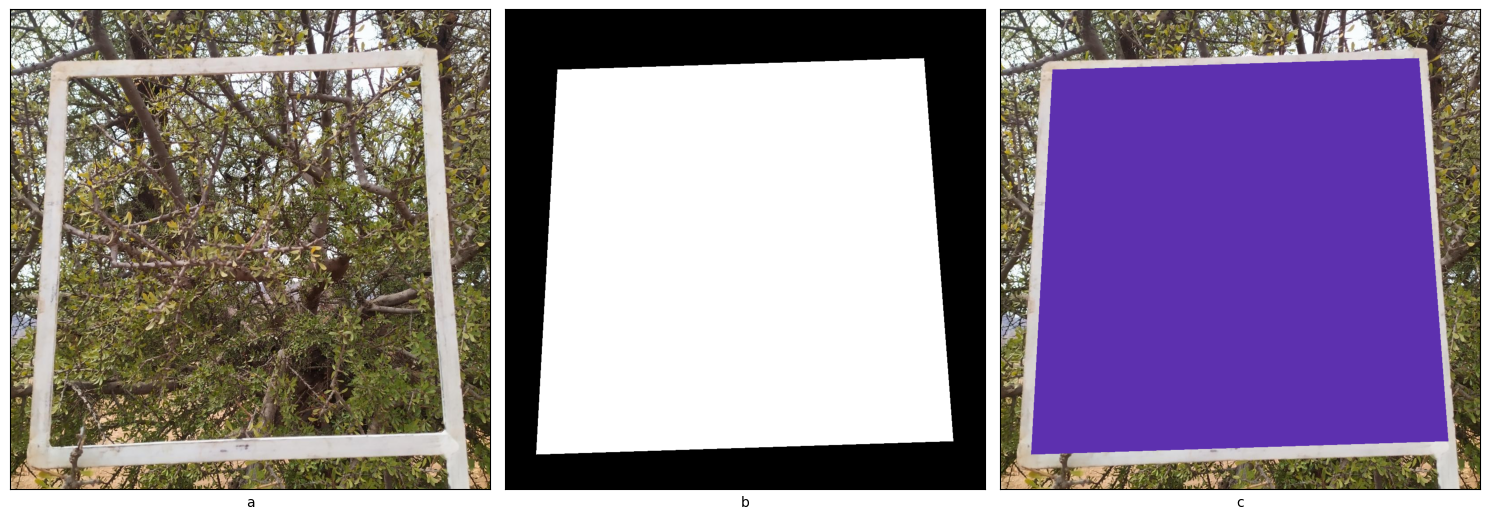

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(raw_img)
ax[1].imshow(raw_mask, cmap="gray")
ax[2].imshow(yolo_annot_img)

for i in range(3):
  ax[i].set_xticks([])
  ax[i].set_yticks([])

ax[0].set_xlabel("a")
ax[1].set_xlabel("b")
ax[2].set_xlabel("c")
plt.tight_layout()
plt.show()

In [ ]:
fig.savefig("/content/drive/MyDrive/ModelsTraining/Framedetection-13/img_annoatations.jpg")

In [ ]:
aug = A.HorizontalFlip(p=1)(image=raw_img, mask=raw_mask)
flip_img_pil = Image.fromarray(aug["image"])
flip_mask_pil = Image.fromarray(aug["mask"])

In [ ]:
flip_img_pil.save(save_path + "image_flip.jpg")
flip_mask_pil.save(save_path + "mask_flip.png")

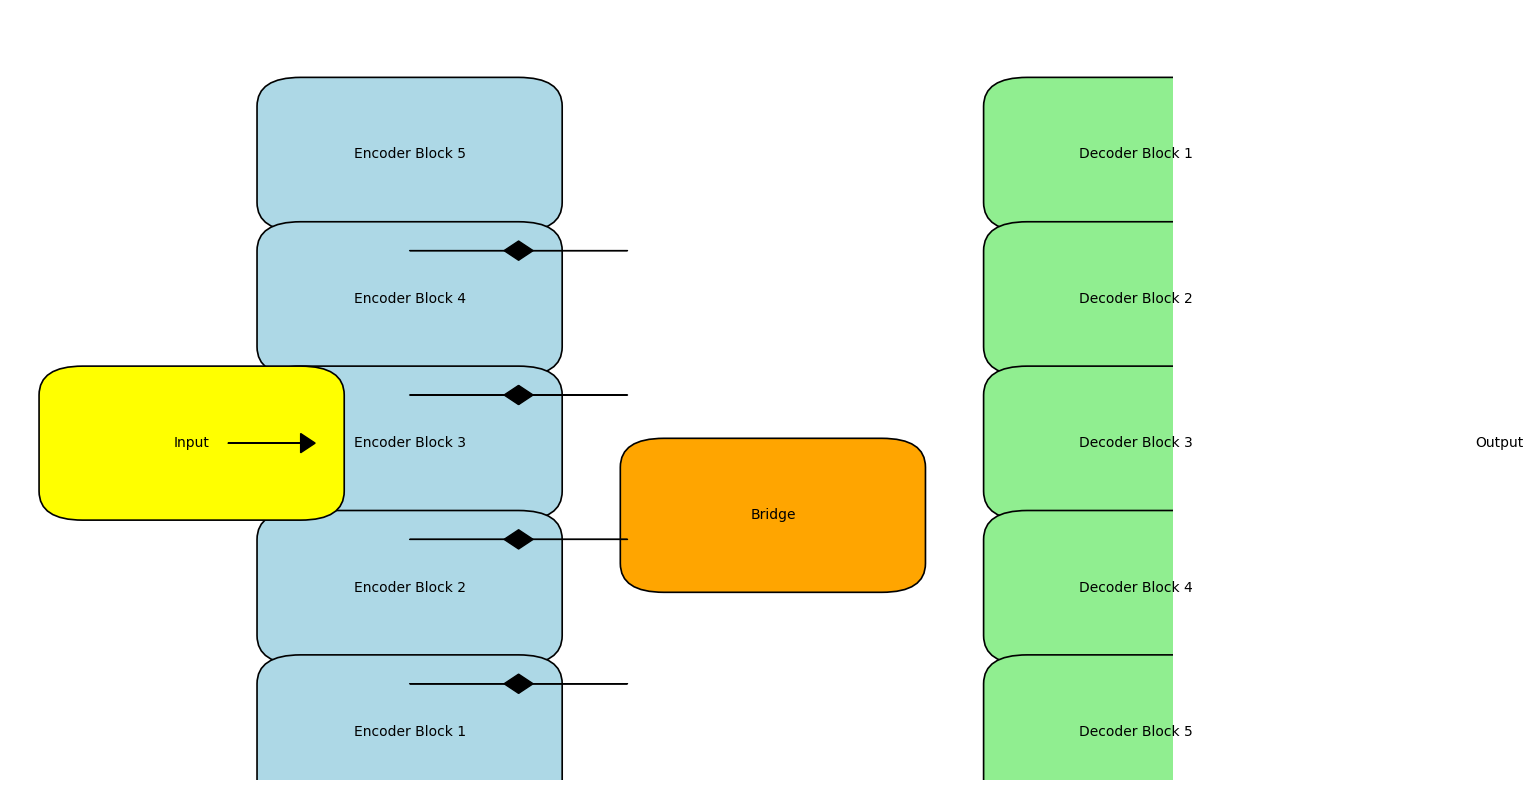

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_block(ax, x, y, width, height, label, color='lightblue'):
    rect = patches.FancyBboxPatch((x, y), width, height, boxstyle="round,pad=0.3", edgecolor='black', facecolor=color, linewidth=1.2)
    ax.add_patch(rect)
    ax.text(x + width / 2, y + height / 2, label, ha='center', va='center', fontsize=10, color='black')

fig, ax = plt.subplots(figsize=(15, 10))

# Encoder blocks
x_start = 0
y_start = 0
block_width = 1.5
block_height = 1

# Draw encoder blocks
for i in range(5):
    draw_block(ax, x_start, y_start - i*(block_height + 0.5), block_width, block_height, f'Encoder Block {5-i}', 'lightblue')

# Bridge
draw_block(ax, x_start + (block_width + 1), y_start - 5*(block_height + 0.5) / 2, block_width, block_height, 'Bridge', 'orange')

# Decoder blocks
x_start = 2*(block_width + 1)
for i in range(5):
    draw_block(ax, x_start, y_start - i*(block_height + 0.5), block_width, block_height, f'Decoder Block {i+1}', 'lightgreen')

# Input and Output
draw_block(ax, -block_width, y_start - 2*(block_height + 0.5), block_width, block_height, 'Input', 'yellow')
draw_block(ax, 3*(block_width + 1), y_start - 2*(block_height + 0.5), block_width, block_height, 'Output', 'yellow')

# Arrows between blocks
for i in range(5):
    ax.arrow(0.75, y_start - i*(block_height + 0.5) - 0.5, 0.75, 0, head_width=0.2, head_length=0.1, fc='k', ec='k')
    ax.arrow(2.25, y_start - i*(block_height + 0.5) - 0.5, -0.75, 0, head_width=0.2, head_length=0.1, fc='k', ec='k')

# Arrows from input to encoder and decoder to output
ax.arrow(-0.5, y_start - 2*(block_height + 0.5) + 0.5, 0.5, 0, head_width=0.2, head_length=0.1, fc='k', ec='k')
ax.arrow(3*(block_width + 1) - 0.5, y_start - 2*(block_height + 0.5) + 0.5, 0.5, 0, head_width=0.2, head_length=0.1, fc='k', ec='k')

ax.set_xlim(-2, 6)
ax.set_ylim(-6, 2)
ax.axis('off')

plt.show()
